# Trabalho Final

## Utilizando agrupamento nebuloso para analisar relação das vulnerabilidades demográficas e socioeconômicas dos municípios brasileiros com os efeitos da Covid-19

### Preparação dos dados 

In [165]:
import datetime
import pandas as pd
from scipy.stats import stats
from sklearn import preprocessing
import skfuzzy as fuzz
import skfuzzy.cluster as cluster
import skfuzzy.control as ctrl
import numpy as np
import matplotlib.pyplot as plt
import os
from random import randrange
import unidecode

#### Parâmetros gerais

In [166]:
data_maxima_considerada = datetime.datetime(year=2021, month=8, day=28)

#### Dados epidemiológicos - consolidado

In [167]:
directory_covid = os.fsencode('dados/covid')
df_covid = None
for file in os.listdir(directory_covid):
    filename = 'dados/covid/' + os.fsdecode(file)
    df_temp = pd.read_csv(filename, decimal=',', sep=';')
    if df_covid is None:
        df_covid = df_temp
    else:
        df_covid = pd.concat([df_covid, df_temp])

df_covid = df_covid[df_covid.municipio.isnull() == False]
df_covid.data = pd.to_datetime(df_covid.data, infer_datetime_format=True)

df_covid = df_covid.rename(
    columns={'regiao': 'REGIAO', 'estado': 'SIGLA_ESTADO', 'municipio': 'MUNICIPIO', 'coduf': 'CODIGO_ESTADO',
             'codmun': 'CODIGO_MUNICIPIO_6', 'codRegiaoSaude': 'CODIGO_REGIAO_SAUDE', 'nomeRegiaoSaude': 'REGIAO_SAUDE',
             'casosAcumulado': 'CASOS', 'obitosAcumulado': 'OBITOS', 'interior/metropolitana': 'REGIAO_METROPOLITANA',
             'casosNovos': 'CASOS_NOVOS', 'obitosNovos': 'OBITOS_NOVOS', 'data': 'DATA', 'semanaEpi': 'SEMANA_EPIDEMIOLOGICA'})
df_covid.CODIGO_MUNICIPIO_6 = df_covid.CODIGO_MUNICIPIO_6.astype('Int64').astype(str)

df_covid = df_covid[df_covid.DATA <= data_maxima_considerada]
df_covid_data_filtrada = df_covid[df_covid.DATA == data_maxima_considerada]

df_base = df_covid_data_filtrada[['MUNICIPIO', 'CODIGO_MUNICIPIO_6', 'SIGLA_ESTADO', 'CODIGO_ESTADO', 'REGIAO', 'REGIAO_SAUDE',
                    'CODIGO_REGIAO_SAUDE', 'REGIAO_METROPOLITANA', 'CASOS', 'OBITOS']]

#### Dados epidemiológicos - por semana epidemiológica

In [168]:
df_covid['ANO'] = df_covid.DATA.dt.year
df_covid_semana_epidemiologica = \
    df_covid.groupby(['MUNICIPIO','CODIGO_MUNICIPIO_6', 'ANO', 'SEMANA_EPIDEMIOLOGICA']).sum()['CASOS_NOVOS']
df_covid_semana_epidemiologica = df_covid_semana_epidemiologica.reset_index()

df_covid_2020_53 = df_covid_semana_epidemiologica[(df_covid_semana_epidemiologica.ANO == 2020) &
                                                  (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA == 53)]
df_covid_2021_53 = df_covid_semana_epidemiologica[(df_covid_semana_epidemiologica.ANO == 2021) &
                                                  (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA == 53)]
df_covid_2021_53 = df_covid_2021_53.drop(columns=['MUNICIPIO', 'ANO', 'SEMANA_EPIDEMIOLOGICA'])
df_covid_2021_53 = df_covid_2021_53.rename(columns={'CASOS_NOVOS': 'CASOS_NOVOS_2021'})

df_covid_2020_53 = pd.merge(df_covid_2020_53, df_covid_2021_53, how='left', on='CODIGO_MUNICIPIO_6')

df_covid_2020_53.CASOS_NOVOS = df_covid_2020_53.CASOS_NOVOS + df_covid_2020_53.CASOS_NOVOS_2021
df_covid_2020_53 = df_covid_2020_53.drop(columns=['CASOS_NOVOS_2021'])

df_covid_semana_epidemiologica = df_covid_semana_epidemiologica[df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA != 53]
df_covid_semana_epidemiologica = pd.concat([df_covid_semana_epidemiologica, df_covid_2020_53])

#### Nome dos estados

In [169]:
df_estados = pd.read_csv('dados/estados.csv', usecols=[1, 2])
df_estados.columns = ['ESTADO', 'SIGLA_ESTADO']
df_estados.SIGLA_ESTADO = df_estados.SIGLA_ESTADO.str.strip()
df_base = pd.merge(df_base, df_estados, how='left', on='SIGLA_ESTADO')

#### Aglomerados subnormais - Estimativa 2019

In [170]:
df_aglomerados_subnormais_estimativa = pd.read_excel('dados/IBGE/aglomerados_subnormais_estiamativa_2019.xls',
                                                     usecols=[1, 3, 4, 5, 8])
df_aglomerados_subnormais_estimativa.columns = \
    ['CODIGO_MUNICIPIO_7', 'POPULACAO_ESTIMADA', 'DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO',
     'DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO',
     'PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO']
df_aglomerados_subnormais_estimativa.CODIGO_MUNICIPIO_7 = df_aglomerados_subnormais_estimativa.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_aglomerados_subnormais_estimativa['CODIGO_MUNICIPIO_6'] = df_aglomerados_subnormais_estimativa.CODIGO_MUNICIPIO_7.str[0:6]
df_aglomerados_subnormais_estimativa = df_aglomerados_subnormais_estimativa.fillna(0)

df_base = pd.merge(df_base, df_aglomerados_subnormais_estimativa, how='left', on=['CODIGO_MUNICIPIO_6'])

#### Regiões imediatas e regiões intermediárias

In [171]:
df_regioes = pd.read_excel('dados/IBGE/regioes_geograficas_composicao_por_municipios_2017_20180911.ods',
                           usecols=[1, 2, 3, 4, 5])
df_regioes.columns = ['CODIGO_MUNICIPIO_7', 'CODIGO_REGIAO_IMEDIATA', 'REGIAO_IMEDIATA', 'CODIGO_REGIAO_INTERMEDIARIA', 'REGIAO_INTERMEDIARIA']
df_regioes.CODIGO_MUNICIPIO_7 = df_regioes.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_base = pd.merge(df_base, df_regioes, how='left', on=['CODIGO_MUNICIPIO_7'])

#### Censo 2010 - Dados IBGE

##### Faixa etária

In [172]:
df_percentual_faixa_etaria = pd.read_csv('dados/IBGE/tab2_percentual_faixa_etaria.csv', sep=';', decimal=',')
df_percentual_faixa_etaria = df_percentual_faixa_etaria.dropna()
df_percentual_faixa_etaria.columns = df_percentual_faixa_etaria.columns.str.replace(" ", "_")
df_percentual_faixa_etaria.columns = df_percentual_faixa_etaria.columns.str.upper()
df_percentual_faixa_etaria.CODMUN7 = df_percentual_faixa_etaria.CODMUN7.astype('Int64').astype(str)
df_percentual_faixa_etaria = df_percentual_faixa_etaria[
    ['CODMUN7', '0_A_5_ANOS', '6_A_14_ANOS', '15_A_24_ANOS', '25_A_39_ANOS', '40_A_59_ANOS',
     '60_ANOS_OU_MAIS']]
df_percentual_faixa_etaria.columns = \
    ['CODIGO_MUNICIPIO_7', 'PERCENTUAL_POPULACAO_0_A_5_ANOS', 'PERCENTUAL_POPULACAO_6_A_14_ANOS',
     'PERCENTUAL_POPULACAO_15_A_24_ANOS', 'PERCENTUAL_POPULACAO_25_A_39_ANOS', 'PERCENTUAL_POPULACAO_40_A_59_ANOS',
     'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS']
df_base = pd.merge(df_base, df_percentual_faixa_etaria, how="left", on=['CODIGO_MUNICIPIO_7'])

##### População sede municipal, área, densidade e domicílios

In [173]:
PATH_SINOPSE = 'dados/IBGE/SinopseEstados/'
directory_sinopse = os.fsencode(PATH_SINOPSE)
df_1_densidade = None
df_2_domicilios = None
for directory_state in os.listdir(directory_sinopse):
    directory_path = PATH_SINOPSE + '/' + os.fsdecode(directory_state)
    for file in os.listdir(directory_path):
        filename = os.fsdecode(file)

        if filename.startswith('tab2_1_'):
            relative_filename = directory_path + '/' + filename
            df_temp = pd.read_excel(relative_filename, header=None, usecols=[3, 7, 8, 9],
                                 skiprows=10, skipfooter=1)
            df_temp.columns = ['POPULACAO_SEDE_MUNICIPAL', 'AREA', 'DENSIDADE', 'CODIGO_MUNICIPIO_7']
            if df_1_densidade is None:
                df_1_densidade = df_temp
            else:
                df_1_densidade = pd.concat([df_1_densidade, df_temp])

        if filename.startswith('tab2_2_'):
            relative_filename = directory_path + '/' + filename
            df_temp = pd.read_excel(relative_filename, header=None, usecols=[2, 11],
                                 skiprows=10, skipfooter=2)
            df_temp.columns = ['DOMICILIOS_PARTICULARES_OCUPADOS', 'CODIGO_MUNICIPIO_7']
            if df_2_domicilios is None:
                df_2_domicilios = df_temp
            else:
                df_2_domicilios = pd.concat([df_2_domicilios, df_temp])
df_1_densidade.CODIGO_MUNICIPIO_7 = df_1_densidade.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_2_domicilios.CODIGO_MUNICIPIO_7 = df_2_domicilios.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)

df_base = pd.merge(df_base, df_1_densidade, how = 'left', on=['CODIGO_MUNICIPIO_7'])
df_base = pd.merge(df_base, df_2_domicilios, how = 'left', on=['CODIGO_MUNICIPIO_7'])

##### Aglomerados subnormais - Censo 2010

In [174]:
df_aglomerados_subnormais = pd.read_excel('dados/IBGE/aglomerados_subnormais.xls', header=None,
                                          usecols=[1, 2, 3, 4, 5, 6, 7], skiprows=8, skipfooter=3)
df_aglomerados_subnormais.columns = \
    ['AGLOMERADOS', 'DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS',
     'POPULACAO_AGLOMERADOS', 'AREA_AGLOMERADOS', 'DENSIDADE_DEMOGRAFICA_AGLOMERADOS',
     'DENSIDADE_DOMICILIOS_AGLOMERADOS','CODIGO_MUNICIPIO_7']
df_aglomerados_subnormais.CODIGO_MUNICIPIO_7 = df_aglomerados_subnormais.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_aglomerados_subnormais = df_aglomerados_subnormais[df_aglomerados_subnormais.CODIGO_MUNICIPIO_7.str.len() == 7]

df_base = pd.merge(df_base, df_aglomerados_subnormais, how='left', on=['CODIGO_MUNICIPIO_7'])

df_base.AGLOMERADOS = df_base.AGLOMERADOS.fillna(0)
df_base.DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS = df_base.DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS.fillna(0)
df_base.POPULACAO_AGLOMERADOS = df_base.POPULACAO_AGLOMERADOS.fillna(0)
df_base.AREA_AGLOMERADOS = df_base.AREA_AGLOMERADOS.fillna(0)
df_base.DENSIDADE_DEMOGRAFICA_AGLOMERADOS = df_base.DENSIDADE_DEMOGRAFICA_AGLOMERADOS.fillna(0)
df_base.DENSIDADE_DOMICILIOS_AGLOMERADOS = df_base.DENSIDADE_DOMICILIOS_AGLOMERADOS.fillna(0)

##### Atributos sistematizados pelo Atlas BR

In [175]:
df_censo = pd.read_csv('dados/AtlasBrasil/censo.csv', sep=';', decimal=',')
df_censo = df_censo[df_censo.ANO ==  2010]
df_censo.columns = df_censo.columns.str.upper()
df_censo = df_censo[['CODMUN7', 'IDHM','IDHM_E','IDHM_L','IDHM_R', 'FECTOT','CORTE1','CORTE2',
                    'CORTE3','CORTE4','CORTE9','GINI', 'PIND', 'PMPOB', 'PPOB', 'PREN10RICOS', 'PREN20','PREN20RICOS',
                    'PREN40','PREN60','PREN80', 'PRENTRAB','R1040','R2040', 'RDPC1','RDPC10','RDPC2','RDPC3','RDPC4',
                    'RDPC5','RIND','RMPOB','RPOB','THEIL', 'CPR','P_AGRO','P_COM','P_CONSTR','P_EXTR',
                    'P_FORMAL', 'P_SERV', 'P_SIUP', 'P_TRANSF', 'REN0','REN1','REN2','REN3','REN5', 'T_ATIV', 'T_DES',
                    'THEILTRAB', 'TRABPUB','T_BANAGUA', 'T_DENS', 'T_OCUPDESLOC_1', 'HOMEMTOT',
                     'MULHERTOT', 'PESO1', 'PESO13', 'PESO4', 'PESO5', 'PESO610',
                    'PESO1114', 'PESO1517', 'PESO18', 'PESO65', 'PESORUR','PESOTOT','PESOURB', 'RAZDEP', 'POP']]
df_censo = df_censo.rename(
    columns={'CODMUN7': 'CODIGO_MUNICIPIO_7', 'IDHM_E': 'IDHM_EDUCACAO','IDHM_L': 'IDHM_LONGEVIDADE','IDHM_R': 'IDHM_RENDA',
             'FECTOT': 'TAXA_FECUNDIDADE','CORTE1': 'RENDA_PER_CAPTA_MAXIMA_1_QUINTO_MAIS_POBRE',
             'CORTE2': 'RENDA_PER_CAPTA_MAXIMA_2_QUINTO_MAIS_POBRE', 'CORTE3': 'RENDA_PER_CAPTA_MAXIMA_3_QUINTO_MAIS_POBRE',
             'CORTE4': 'RENDA_PER_CAPTA_MAXIMA_4_QUINTO_MAIS_POBRE','CORTE9': 'RENDA_PER_CAPTA_MINIMA_10_PORCENTO_MAIS_RICOS',
             'PIND': 'PERCENTUAL_EXTREMAMENTE_POBRES', 'PMPOB': 'PERCENTUAL_POBRES', 'PPOB': 'PERCENTUAL_VULNERAVEIS_POBREZA',
             'PREN10RICOS': 'PERCENTUAL_RENDA_APROPRIADA_10_PORCENTO_MAIS_RICOS',
             'PREN20RICOS': 'PERCENTUAL_RENDA_APROPRIADA_20_PORCENTO_MAIS_RICOS',
             'PREN20': 'PERCENTUAL_RENDA_APROPRIADA_20_PORCENTO_MAIS_POBRES',
             'PREN40': 'PERCENTUAL_RENDA_APROPRIADA_40_PORCENTO_MAIS_POBRES',
             'PREN60': 'PERCENTUAL_RENDA_APROPRIADA_60_PORCENTO_MAIS_POBRES',
             'PREN80': 'PERCENTUAL_RENDA_APROPRIADA_80_PORCENTO_MAIS_POBRES',
             'PRENTRAB': 'PERCENTUAL_RENDA_PROVENIENTE_TRABALHO','R1040': 'RAZAO_10_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES',
             'R2040': 'RAZAO_20_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES',
             'RDPC1': 'RENDA_PER_CAPTA_MEDIA_1_QUINTO_MAIS_POBRE', 'RDPC2': 'RENDA_PER_CAPTA_MEDIA_2_QUINTO_MAIS_POBRE',
             'RDPC3': 'RENDA_PER_CAPTA_MEDIA_3_QUINTO_MAIS_POBRE','RDPC4': 'RENDA_PER_CAPTA_MEDIA_4_QUINTO_MAIS_POBRE',
             'RDPC5': 'RENDA_PER_CAPTA_MEDIA_20_PORCENTO_MAIS_RICOS', 'RDPC10': 'RENDA_PER_CAPTA_MEDIA_10_PORCENTO_MAIS_RICOS',
             'RIND': 'RENDA_PER_CAPTA_MEDIA_EXTREMAMENTE_POBRES','RMPOB': 'RENDA_PER_CAPTA_MEDIA_POBRES',
             'RPOB': 'RENDA_PER_CAPTA_MEDIA_VULNERAVEIS_POBREZA','CPR': 'PERCENTUAL_TRABALHADORES_CONTA_PROPRIA',
             'P_AGRO': 'PERCENTUAL_OCUPADOS_AGROPECUARIA','P_COM': 'PERCENTUAL_OCUPADOS_COMERCIO','P_CONSTR': 'PERCENTUAL_OCUPADOS_CONSTRUCAO',
             'P_EXTR': 'PERCENTUAL_OCUPADOS_MINERACAO', 'P_FORMAL': 'PERCENTUAL_TRABALHADORES_FORMALIZADOS',
             'P_SERV': 'PERCENTUAL_OCUPADOS_SERVICO', 'P_SIUP': 'PERCENTUAL_OCUPADOS_SERVICOS_INDUSTRIAIS_UTILIDADE_PUBLICA',
             'P_TRANSF': 'PERCENTUAL_OCUPADOS_INDUSTRIA', 'REN0': 'PERCENTUAL_OCUPADOS_SEM_RENDA',
             'REN1': 'PERCENTUAL_OCUPADOS_ATE_1_SALARIO_MINIMO','REN2': 'PERCENTUAL_OCUPADOS_ATE_2_SALARIOS_MINIMOS',
             'REN3': 'PERCENTUAL_OCUPADOS_ATE_3_SALARIOS_MINIMOS','REN5': 'PERCENTUAL_OCUPADOS_ATE_5_SALARIOS_MINIMOS',
             'T_ATIV': 'TAXA_ATIVIDADE', 'T_DES': 'TAXA_DESOCUPACAO', 'THEILTRAB': 'THEIL_TRABALHO', 'TRABPUB': 'PERCENTUAL_TRABALHADORES_PUBLICOS',
             'T_BANAGUA': 'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_BANHEIRO_AGUA',
             'T_DENS': 'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_DENSIDADE_MAIOR_2_POR_DORMITORIO',
             'T_OCUPDESLOC_1': 'PERCENTUAL_POPULACAO_VULNERAVEL_POBREZA_GASTAM_MAIS_UMA_HORA_ATE_TRABALHO',
             'HOMEMTOT': 'POPULACAO_MASCULINA', 'MULHERTOT': 'POPULACAO_FEMININA', 'PESO1': 'POPULACAO_ATE_1_ANO',
             'PESO13': 'POPULACAO_1_A_3_ANOS', 'PESO4': 'POPULACAO_4_ANOS', 'PESO5': 'POPULACAO_5_ANOS',
             'PESO610': 'POPULACAO_6_A_10_ANOS', 'PESO1114': 'POPULACAO_11_A_14_ANOS', 'PESO1517': 'POPULACAO_15_A_17_ANOS',
             'PESO18': 'POPULACAO_18_ANOS_OU_MAIS', 'PESO65': 'POPULACAO_65_ANOS_OU_MAIS', 'PESORUR': 'POPULACAO_RURAL',
             'PESOTOT': 'POPULACAO_TOTAL','PESOURB': 'POPULACAO_URBANA', 'RAZDEP': 'RAZAO_DEPENDENCIA', 'POP': 'POPULACAO_DOMICILIOS_PARTICULARES'})
df_censo = df_censo.astype({'CODIGO_MUNICIPIO_7': str})

df_base = pd.merge(df_base, df_censo, how='left', on='CODIGO_MUNICIPIO_7')

#### Registros administrativos sistematizados pelo Atlas BR

In [176]:
df_registros_administrativos =  pd.read_csv('dados/AtlasBrasil/registros_administrativos.csv', decimal=',', sep=';')
df_registros_administrativos = df_registros_administrativos.astype({'IBGE7': str})

df_registros_administrativos_2017 = df_registros_administrativos[df_registros_administrativos.ANO == 2017]
df_registros_administrativos_2017 = df_registros_administrativos_2017[
    ['IBGE7','PINTERDRSAI', 'REN_TRPCBF_D', 'TXCOBPLP']]
df_registros_administrativos_2017 = df_registros_administrativos_2017.rename(
    columns={'IBGE7': 'CODIGO_MUNICIPIO_7', 'PINTERDRSAI': 'PERCENTUAL_INTERNACAOES_DOENCAS_SANEAMENTO_INADEQUADO',
             'REN_TRPCBF_D': 'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA', 'TXCOBPLP': 'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE'})
df_base = pd.merge(df_base, df_registros_administrativos_2017, how="left", on=['CODIGO_MUNICIPIO_7'])

df_registros_administrativos_2016 = df_registros_administrativos[df_registros_administrativos.ANO == 2016]
df_registros_administrativos_2016 = df_registros_administrativos_2016[
    ['IBGE7', 'REN_PVAADM', 'REN_PVAAGR', 'REN_PVAIND', 'REN_PVASERV']]
df_registros_administrativos_2016 = df_registros_administrativos_2016.rename(
    columns={'IBGE7': 'CODIGO_MUNICIPIO_7', 'REN_PVAADM': 'PERCENTUAL_VALOR_ADICIONADO_ADMINISTRACAO_PUBLICA',
             'REN_PVAAGR': 'PERCENTUAL_VALOR_ADICIONADO_AGRICULTURA', 'REN_PVAIND': 'PERCENTUAL_VALOR_ADICIONADO_INDUSTRIA',
             'REN_PVASERV': 'PERCENTUAL_VALOR_ADICIONADO_SERVICO'})
df_base = pd.merge(df_base, df_registros_administrativos_2016, how="left", on=['CODIGO_MUNICIPIO_7'])


##### Tratamento de dados ausentes em PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE

In [177]:
df_group_regiao_imediata = df_base.groupby('CODIGO_REGIAO_IMEDIATA').mean()[['PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE']]
df_group_regiao_imediata.columns = ['PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE_MEDIA_REGIAO_IMEDIATA']
df_group_regiao_imediata = df_group_regiao_imediata.reset_index()
df_base = pd.merge(df_base, df_group_regiao_imediata, how='left', on='CODIGO_REGIAO_IMEDIATA')
df_base.loc[df_base.PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE.isnull(), 'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE'] = \
    df_base[df_base.PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE.isnull()].PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE_MEDIA_REGIAO_IMEDIATA
df_base = df_base.drop(columns=['PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE_MEDIA_REGIAO_IMEDIATA'])

#### Eleições 2018

In [178]:
PATH_ELEICOES = 'dados/Eleicao2018/'
directory_eleicoes = os.fsencode(PATH_ELEICOES)
df_eleicoes = None
for directory_state in os.listdir(directory_eleicoes):
    directory_path = PATH_ELEICOES + '/' + os.fsdecode(directory_state)
    for file in os.listdir(directory_path):
        filename = os.fsdecode(file)

        if filename.endswith('.csv'):
            relative_filename = directory_path + '/' + filename
            df_eleicoes_temp = pd.read_csv(relative_filename, encoding='Latin 1', sep=';')
            df_eleicoes_temp = df_eleicoes_temp[df_eleicoes_temp.DS_CARGO_PERGUNTA == 'Presidente']
            df_eleicoes_temp = df_eleicoes_temp.groupby(['CD_MUNICIPIO', 'NM_MUNICIPIO', 'NM_VOTAVEL']).sum()
            df_eleicoes_temp = df_eleicoes_temp[['QT_VOTOS']]
            df_eleicoes_branco = df_eleicoes_temp.loc[(slice(None), slice(None), 'Branco')]
            df_eleicoes_branco.columns = ['VOTOS_BRANCO']
            df_eleicoes_nulo = df_eleicoes_temp.loc[(slice(None), slice(None), 'Nulo')]
            df_eleicoes_nulo.columns = ['VOTOS_NULO']
            df_eleicoes_bolsonaro = df_eleicoes_temp.loc[(slice(None), slice(None), 'JAIR BOLSONARO')]
            df_eleicoes_bolsonaro.columns = ['VOTOS_BOLSONARO']
            df_eleicoes_haddad = df_eleicoes_temp.loc[(slice(None), slice(None), 'FERNANDO HADDAD')]
            df_eleicoes_haddad.columns = ['VOTOS_HADDAD']
            df_eleicoes_temp = pd.merge(df_eleicoes_bolsonaro, df_eleicoes_haddad, left_index=True, right_index=True)
            df_eleicoes_temp = pd.merge(df_eleicoes_temp, df_eleicoes_branco, left_index=True, right_index=True)
            df_eleicoes_temp = pd.merge(df_eleicoes_temp, df_eleicoes_nulo, left_index=True, right_index=True)
            df_eleicoes_temp = df_eleicoes_temp.reset_index(level=['CD_MUNICIPIO', 'NM_MUNICIPIO'])
            if df_eleicoes is None:
                df_eleicoes = df_eleicoes_temp
            else:
                df_eleicoes = pd.concat([df_eleicoes, df_eleicoes_temp])

df_eleicoes = df_eleicoes.drop(columns=['NM_MUNICIPIO'])
df_eleicoes = df_eleicoes.rename(columns={'CD_MUNICIPIO': 'CODIGO_MUNICIPIO_TSE'})
df_codigos_tse_ibge = pd.read_csv('dados/municipios_brasileiros_tse.csv', usecols=[0, 3, 4])
df_codigos_tse_ibge.columns = ['CODIGO_MUNICIPIO_TSE', 'CAPITAL', 'CODIGO_MUNICIPIO_7']
df_eleicoes = pd.merge(df_eleicoes, df_codigos_tse_ibge, how="left", on=['CODIGO_MUNICIPIO_TSE'])
df_eleicoes.CODIGO_MUNICIPIO_7 = df_eleicoes.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)

df_base = pd.merge(df_base, df_eleicoes, how='left', on=['CODIGO_MUNICIPIO_7'])

/home/helder/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (25,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/helder/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (25,27,30,32,39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/helder/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (30,32,39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Dados da saúde

##### Cobertura da Estratégia de Saúde da Família

In [179]:
df_cobertura_estrategia_saude_familia = pd.read_excel('dados/saude/Cobertura-AB-TODOS OS MUNICÍPIOS-Dezembro de 2019.xls',
                                                      header=None, usecols=[3, 12], skiprows=9, skipfooter=6)
df_cobertura_estrategia_saude_familia.columns = \
    ['CODIGO_MUNICIPIO_6', 'PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA']
df_cobertura_estrategia_saude_familia.CODIGO_MUNICIPIO_6 = df_cobertura_estrategia_saude_familia.CODIGO_MUNICIPIO_6.astype('Int64').astype(str)
df_cobertura_estrategia_saude_familia.PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA = \
    df_cobertura_estrategia_saude_familia.PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA.str.replace("%","")
df_cobertura_estrategia_saude_familia.PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA = \
    df_cobertura_estrategia_saude_familia.PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA.str.replace(",",".")
df_cobertura_estrategia_saude_familia = df_cobertura_estrategia_saude_familia.astype({'PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA': float})

df_base = pd.merge(df_base, df_cobertura_estrategia_saude_familia, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Cobertura dos Agentes Comunitários de Saúde

In [180]:
df_cobertura_agentes_saude = pd.read_excel('dados/saude/Cobertura-ACS-TODOS OS MUNICÍPIOS-Dezembro de 2019.xls',
                                                      header=None, usecols=[3, 8], skiprows=9, skipfooter=6)
df_cobertura_agentes_saude.columns = \
    ['CODIGO_MUNICIPIO_6', 'PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE']
df_cobertura_agentes_saude.CODIGO_MUNICIPIO_6 = df_cobertura_agentes_saude.CODIGO_MUNICIPIO_6.astype('Int64').astype(str)
df_cobertura_agentes_saude.PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE = \
    df_cobertura_agentes_saude.PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE.str.replace("%","")
df_cobertura_agentes_saude.PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE = \
    df_cobertura_agentes_saude.PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE.str.replace(",",".")
df_cobertura_agentes_saude = df_cobertura_agentes_saude.astype({'PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE': float})

df_base = pd.merge(df_base, df_cobertura_agentes_saude, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Enfermeiros

In [181]:
df_enfermeiros = pd.read_csv('dados/saude/enfermeiros_2019_12.csv', sep=';', decimal=',')
df_enfermeiros.columns = ['MUNICIPIO', 'ENFERMEIROS_SUS_2019_12', 'ENFERMEIROS_NAO_SUS_2019_12', 'ENFERMEIROS_TOTAL_2019_12']
df_enfermeiros =  df_enfermeiros.replace("-", 0)
df_enfermeiros['CODIGO_MUNICIPIO_6'] = df_enfermeiros.MUNICIPIO.str[:6]
df_enfermeiros = df_enfermeiros.astype({'ENFERMEIROS_SUS_2019_12': int, 'ENFERMEIROS_NAO_SUS_2019_12': int, 'ENFERMEIROS_TOTAL_2019_12': int})
df_enfermeiros = df_enfermeiros.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_enfermeiros, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Médicos

In [182]:
df_medicos = pd.read_csv('dados/saude/medicos_2019_12.csv', sep=';', decimal=',')
df_medicos.columns = ['MUNICIPIO', 'MEDICOS_SUS_2019_12', 'MEDICOS_NAO_SUS_2019_12', 'MEDICOS_TOTAL_2019_12']
df_medicos =  df_medicos.replace("-", 0)
df_medicos['CODIGO_MUNICIPIO_6'] = df_medicos.MUNICIPIO.str[:6]
df_medicos = df_medicos.astype({'MEDICOS_SUS_2019_12': int, 'MEDICOS_NAO_SUS_2019_12': int, 'MEDICOS_TOTAL_2019_12': int})
df_medicos = df_medicos.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_medicos, how='left', on=['CODIGO_MUNICIPIO_6'])

##### LEITOS INTERNAÇÃO

In [183]:
df_leitos_internacao = pd.read_csv('dados/saude/leitos_internacao_2019_12.csv', sep=';', decimal=',')
df_leitos_internacao.columns = ['MUNICIPIO', 'LEITOS_INTERNACAO_SUS_2019_12', 'LEITOS_INTERNACAO_NAO_SUS_2019_12', 'LEITOS_INTERNACAO_TOTAL_2019_12']
df_leitos_internacao =  df_leitos_internacao.replace("-", 0)
df_leitos_internacao['CODIGO_MUNICIPIO_6'] = df_leitos_internacao.MUNICIPIO.str[:6]
df_leitos_internacao = df_leitos_internacao.astype({'LEITOS_INTERNACAO_SUS_2019_12': int, 'LEITOS_INTERNACAO_NAO_SUS_2019_12': int, 'LEITOS_INTERNACAO_TOTAL_2019_12': int})
df_leitos_internacao = df_leitos_internacao.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_leitos_internacao, how='left', on=['CODIGO_MUNICIPIO_6'])

##### LEITOS UTI

In [184]:
df_leitos_uti = pd.read_csv('dados/saude/leitos_uti_2019_12.csv', sep=';', decimal=',')
df_leitos_uti.columns = ['MUNICIPIO', 'LEITOS_UTI_SUS_2019_12', 'LEITOS_UTI_NAO_SUS_2019_12', 'LEITOS_UTI_TOTAL_2019_12']
df_leitos_uti =  df_leitos_uti.replace("-", 0)
df_leitos_uti['CODIGO_MUNICIPIO_6'] = df_leitos_uti.MUNICIPIO.str[:6]
df_leitos_uti = df_leitos_uti.astype({'LEITOS_UTI_SUS_2019_12': int, 'LEITOS_UTI_NAO_SUS_2019_12': int, 'LEITOS_UTI_TOTAL_2019_12': int})
df_leitos_uti = df_leitos_uti.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_leitos_uti, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Ventiladores/Respiradores

In [185]:
df_ventiladores_respiradores = pd.read_csv('dados/saude/ventiladores_respiradores_2019_12.csv',
                                           sep=';', decimal=',', usecols=[0, 1, 2])
df_ventiladores_respiradores.columns = ['MUNICIPIO', 'VENTILADORES_RESPIRADORES_EXISTENTES_2019_12', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12']
df_ventiladores_respiradores =  df_ventiladores_respiradores.replace("-", 0)
df_ventiladores_respiradores['CODIGO_MUNICIPIO_6'] = df_ventiladores_respiradores.MUNICIPIO.str[:6]
df_ventiladores_respiradores = df_ventiladores_respiradores.astype({'VENTILADORES_RESPIRADORES_EXISTENTES_2019_12': int,
                                                                    'VENTILADORES_RESPIRADORES_EM_USO_2019_12': int})
df_ventiladores_respiradores = df_ventiladores_respiradores.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_ventiladores_respiradores, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Merge df_base and df_group_regiao_imediata

In [186]:
df_group_regiao_imediata = df_base.groupby('CODIGO_REGIAO_IMEDIATA').sum()[
    ['POPULACAO_ESTIMADA', 'LEITOS_INTERNACAO_TOTAL_2019_12', 'LEITOS_UTI_TOTAL_2019_12', 'MEDICOS_TOTAL_2019_12',
     'ENFERMEIROS_TOTAL_2019_12', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12']]
df_group_regiao_imediata.columns = ['POPULACAO_ESTIMADA_REGIAO_IMEDIATA', 'LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA',
                                    'LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA', 'MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA',
     'ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA']
df_group_regiao_imediata = df_group_regiao_imediata.reset_index()
df_base = pd.merge(df_base, df_group_regiao_imediata, how='left', on='CODIGO_REGIAO_IMEDIATA')

##### Merge df_base and df_group_regiao_intermediaria

In [187]:
df_group_regiao_intermediaria = df_base.groupby('CODIGO_REGIAO_INTERMEDIARIA').sum()[
    ['POPULACAO_ESTIMADA', 'LEITOS_INTERNACAO_TOTAL_2019_12', 'LEITOS_UTI_TOTAL_2019_12', 'MEDICOS_TOTAL_2019_12',
     'ENFERMEIROS_TOTAL_2019_12', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12']]
df_group_regiao_intermediaria.columns = ['POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA', 'LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
                                    'LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA', 'MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
     'ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA']
df_group_regiao_intermediaria = df_group_regiao_intermediaria.reset_index()
df_base = pd.merge(df_base, df_group_regiao_intermediaria, how='left', on='CODIGO_REGIAO_INTERMEDIARIA')

##### Enfermeiros, médicos, leitos de internação, leitos UTI, leitos UTI Covid e ventiladores pulmonares durante os anos 2020 e 2021

In [188]:
PATH_SAUDE = 'dados/saude/'
directory_saude = os.fsencode(PATH_SAUDE)
for file in os.listdir(directory_saude):
    filename = os.fsdecode(file)

    if filename.endswith('_2020_2021.csv'):
        relative_filename = PATH_SAUDE + filename
        item = filename.replace('_2020_2021.csv', '').upper()
        df_saude = pd.read_csv(relative_filename, sep=';', decimal=',')
        column1 = item+'_2020_06'
        column2 = item+'_2020_12'
        column3 = item+'_2021_06'
        df_saude.columns = ['CODIGO_MUNICIPIO_6', column1, column2, column3]
        df_saude =  df_saude.replace("-", 0)
        df_saude['CODIGO_MUNICIPIO_6'] = df_saude.CODIGO_MUNICIPIO_6.str[:6]
        df_saude = df_saude.astype({column1: int, column2: int, column3: int})
        df_base = pd.merge(df_base, df_saude, how='left', on=['CODIGO_MUNICIPIO_6'])

        df_group_regiao_intermediaria = df_base.groupby('CODIGO_REGIAO_INTERMEDIARIA').sum()[[column1, column2, column3]]
        column1_regiao_intermediaria = column1 + '_REGIAO_INTERMEDIARIA'
        column2_regiao_intermediaria = column2 + '_REGIAO_INTERMEDIARIA'
        column3_regiao_intermediaria = column3 + '_REGIAO_INTERMEDIARIA'
        df_group_regiao_intermediaria.columns = [column1_regiao_intermediaria, column2_regiao_intermediaria,
                                                 column3_regiao_intermediaria]
        df_group_regiao_intermediaria = df_group_regiao_intermediaria.reset_index()
        df_base = pd.merge(df_base, df_group_regiao_intermediaria, how='left', on='CODIGO_REGIAO_INTERMEDIARIA')

        column1_regiao_intermediaria_taxa = 'TAXA_' + column1 + '_REGIAO_INTERMEDIARIA'
        column2_regiao_intermediaria_taxa = 'TAXA_' + column2 + '_REGIAO_INTERMEDIARIA'
        column3_regiao_intermediaria_taxa = 'TAXA_' + column3 + '_REGIAO_INTERMEDIARIA'
        df_base[column1_regiao_intermediaria_taxa] = df_base[column1_regiao_intermediaria] / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
        df_base[column2_regiao_intermediaria_taxa] = df_base[column2_regiao_intermediaria] / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
        df_base[column3_regiao_intermediaria_taxa] = df_base[column3_regiao_intermediaria] / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000

#### Doenças de risco à Covid-19

In [189]:
directory_disease_path = 'dados/pesquisa_nacional_saude/'
directory_disease = os.fsencode(directory_disease_path)
for file in os.listdir(directory_disease):
    file_single_name = os.fsdecode(file)
    filename = directory_disease_path + file_single_name
    disease_name = file_single_name[:-4].upper()

    column_percentual = 'PERCENTUAL_' + disease_name

    df_capital_disease = pd.read_excel(filename, sheet_name=2, header=None, usecols=[0, 1], skiprows=11, skipfooter=3)
    df_capital_disease.columns = ['MUNICIPIO', column_percentual]
    df_capital_disease['CAPITAL'] = 1
    df_base = pd.merge(df_base, df_capital_disease, how='left', on=['MUNICIPIO', 'CAPITAL'])

#### Hierarquia urbana

In [190]:
df_arranjo_populacional = \
    pd.read_excel('dados/hierarquia_urbana/REGIC2018_Arranjos_Populacionais_v2.xlsx', usecols=[0, 2, 3])
df_arranjo_populacional.columns = ['CODIGO_MUNICIPIO_7', 'CODIGO_ARRANJO_POPULACIONAL','ARRANJO_POPULACIONAL']
df_arranjo_populacional.CODIGO_MUNICIPIO_7 = df_arranjo_populacional.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_arranjo_populacional.CODIGO_ARRANJO_POPULACIONAL = df_arranjo_populacional.CODIGO_ARRANJO_POPULACIONAL.astype('Int64').astype(str)

df_base = pd.merge(df_base, df_arranjo_populacional, how='left', on='CODIGO_MUNICIPIO_7')

df_base['CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7'] = df_base.CODIGO_MUNICIPIO_7
df_base.loc[df_base.CODIGO_ARRANJO_POPULACIONAL.isnull() == False, 'CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7'] = \
    df_base[df_base.CODIGO_ARRANJO_POPULACIONAL.isnull() == False].CODIGO_ARRANJO_POPULACIONAL

df_hierarquia_urbana = pd.read_excel('dados/hierarquia_urbana/REGIC2018_Cidades_v2.xlsx', usecols=[2, 12, 13])
df_hierarquia_urbana.columns = ['CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7', 'NIVEL_HIERARQUIA_URBANA', 'HIERARQUIA_URBANA']
df_hierarquia_urbana.CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7 = \
    df_hierarquia_urbana.CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7.astype('Int64').astype(str)

df_base = pd.merge(df_base, df_hierarquia_urbana, how='left', on='CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7')

df_base['NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 0
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '1A', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 11
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '1B', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 10
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '1C', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 9
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '2A', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 8
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '2B', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 7
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '2C', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 6
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '3A', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 5
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '3B', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 4
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '4A', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 3
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '4B', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 2
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '5', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 1

#### Mobilidade (Google)

In [191]:
directory_mobility_path = 'dados/GoogleMobilidade/'
directory_mobility = os.fsencode(directory_mobility_path)
df_mobilidade = None
for file in os.listdir(directory_mobility):
    filename = directory_mobility_path + os.fsdecode(file)
    df_temp = pd.read_csv(filename, usecols=[2, 3, 8, 12, 13, 14])
    if df_mobilidade is None:
        df_mobilidade = df_temp
    else:
        df_mobilidade = pd.concat([df_mobilidade, df_temp])

df_mobilidade.columns = ['ESTADO', 'MUNICIPIO', 'DATA', 'PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
                         'PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']
df_mobilidade = df_mobilidade[(df_mobilidade.ESTADO == "Federal District") | (df_mobilidade.MUNICIPIO.isnull() == False)].copy()
df_mobilidade.ESTADO = df_mobilidade.ESTADO.str.replace('State of ', '')
df_mobilidade.loc[df_mobilidade.ESTADO == "Federal District", "MUNICIPIO"] = 'Brasília'
df_mobilidade.loc[df_mobilidade.ESTADO == "Federal District", "ESTADO"] = 'Distrito Federal'
df_mobilidade.MUNICIPIO = df_mobilidade.MUNICIPIO.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

df_municipio = df_base[['MUNICIPIO', 'ESTADO', 'CODIGO_MUNICIPIO_6', 'CODIGO_MUNICIPIO_7']].copy()
df_municipio.MUNICIPIO = df_municipio.MUNICIPIO.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

estados_sem_acento = df_estados.ESTADO.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
for estado in estados_sem_acento:
    palavra_pesquisa = ', ' + estado
    df_mobilidade.MUNICIPIO = df_mobilidade.MUNICIPIO.str.replace(palavra_pesquisa, '')

df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Poxoreo', 'MUNICIPIO'] = 'Poxoreu'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Brasopolis', 'MUNICIPIO'] = 'Brazopolis'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Sao Thome das Letras', 'MUNICIPIO'] = 'Sao Tome das Letras'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Eldorado dos Carajas', 'MUNICIPIO'] = 'Eldorado do Carajas'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Santa Isabel do Para', 'MUNICIPIO'] = 'Santa Izabel do Para'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Itamaraca', 'MUNICIPIO'] = 'Ilha de Itamaraca'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Sao Caetano', 'MUNICIPIO'] = 'Sao Caitano'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Assu', 'MUNICIPIO'] = 'Acu'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "Santana do Livramento", 'MUNICIPIO'] = "Sant'Ana do Livramento"
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "Santana do Livramento", 'MUNICIPIO'] = "Sant'Ana do Livramento"
df_mobilidade.MUNICIPIO = df_mobilidade.MUNICIPIO.str.upper()
df_municipio.MUNICIPIO = df_municipio.MUNICIPIO.str.upper()
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "PICARRAS", 'MUNICIPIO'] = "BALNEARIO PICARRAS"
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "BIRITIBA-MIRIM", 'MUNICIPIO'] = "BIRITIBA MIRIM"
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "EMBU", 'MUNICIPIO'] = "EMBU DAS ARTES"
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "MOJI-MIRIM", 'MUNICIPIO'] = "MOGI MIRIM"

df_mobilidade = pd.merge(df_mobilidade, df_municipio, how='left', on=['ESTADO', 'MUNICIPIO'])

SABADO = 5
DOMINGO = 6
df_mobilidade.DATA = pd.to_datetime(df_mobilidade.DATA, infer_datetime_format=True)
df_mobilidade = df_mobilidade[df_mobilidade.DATA <= data_maxima_considerada]
df_mobilidade = df_mobilidade[(df_mobilidade.DATA.dt.weekday != SABADO) & (df_mobilidade.DATA.dt.weekday != DOMINGO)]

##### Agrupa dados de mobilidade e número de casos no mesmo intervalo de semanas epidemiológicas

In [192]:
df_mobilidade_semana_epidemiologica = None
df_covid_semana_epidemiologica_agrupada = None
NUMERO_SEMANAS_EPIDEMIOLOGICAS_AGRUPAR = 1
SEMANA_EPIDEMIOLOGICA_INICIAL = 14
data_inicio_semana_epidemiologica = datetime.datetime(year=2020, month=3, day=29)
data_fim_semana_epidemiologica = datetime.datetime(year=2020, month=3, day=28)
semana_epidemiologica = SEMANA_EPIDEMIOLOGICA_INICIAL
while(data_inicio_semana_epidemiologica < data_maxima_considerada):
    ano_inicio_semana_epidemiologica = data_inicio_semana_epidemiologica.year
    data_fim_semana_epidemiologica += datetime.timedelta(days= 7 * NUMERO_SEMANAS_EPIDEMIOLOGICAS_AGRUPAR)

    df_temp = df_mobilidade[(df_mobilidade.DATA >= data_inicio_semana_epidemiologica) & (df_mobilidade.DATA <= data_fim_semana_epidemiologica)]
    df_temp = df_temp.groupby(['MUNICIPIO', 'ESTADO', 'CODIGO_MUNICIPIO_6', 'CODIGO_MUNICIPIO_7']).mean()
    ano_semana_epidemiologica_inicio_definitivo = ano_inicio_semana_epidemiologica
    semana_epidemiologica_inicio_definitivo = semana_epidemiologica


    for i in range(NUMERO_SEMANAS_EPIDEMIOLOGICAS_AGRUPAR):
        data_inicio_semana_epidemiologica += datetime.timedelta(days= 7)
        ano_inicio_proxima_semana_epidemiologica = data_inicio_semana_epidemiologica.year
        if ano_inicio_semana_epidemiologica != ano_inicio_proxima_semana_epidemiologica:
            ultima_semana_epidemiologica_ano = semana_epidemiologica
            semana_epidemiologica = 1
            ano_inicio_semana_epidemiologica = ano_inicio_proxima_semana_epidemiologica
        else:
            semana_epidemiologica += 1

    if semana_epidemiologica > 1:
        ano_semana_epidemiologica_fim_definitivo = ano_inicio_semana_epidemiologica
        semana_epidemiologica_fim_definitivo = semana_epidemiologica - 1
    else:
        ano_semana_epidemiologica_fim_definitivo = ano_inicio_semana_epidemiologica - 1
        semana_epidemiologica_fim_definitivo = ultima_semana_epidemiologica_ano

    df_temp['ANO_SEMANA_EPIDEMIOLOGICA_INICIO'] = ano_semana_epidemiologica_inicio_definitivo
    df_temp['SEMANA_EPIDEMIOLOGICA_INICIO'] = semana_epidemiologica_inicio_definitivo
    df_temp['ANO_SEMANA_EPIDEMIOLOGICA_FIM'] = ano_semana_epidemiologica_fim_definitivo
    df_temp['SEMANA_EPIDEMIOLOGICA_FIM'] = semana_epidemiologica_fim_definitivo

    if df_mobilidade_semana_epidemiologica is None:
        df_mobilidade_semana_epidemiologica = df_temp
    else:
        df_mobilidade_semana_epidemiologica = pd.concat([df_mobilidade_semana_epidemiologica, df_temp])

    if ano_semana_epidemiologica_inicio_definitivo != ano_semana_epidemiologica_fim_definitivo:
        df_temp_covid = df_covid_semana_epidemiologica[
            ((df_covid_semana_epidemiologica.ANO >= ano_semana_epidemiologica_inicio_definitivo) &
            (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA >= semana_epidemiologica_inicio_definitivo)) |
            ((df_covid_semana_epidemiologica.ANO <= ano_semana_epidemiologica_fim_definitivo) &
            (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA <= semana_epidemiologica_fim_definitivo))]
    else:
        df_temp_covid = df_covid_semana_epidemiologica[
            (df_covid_semana_epidemiologica.ANO == ano_semana_epidemiologica_inicio_definitivo) &
            (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA >= semana_epidemiologica_inicio_definitivo) &
            (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA <= semana_epidemiologica_fim_definitivo)]

    df_temp_covid = df_temp_covid.groupby('CODIGO_MUNICIPIO_6').sum()[['CASOS_NOVOS']]
    df_temp_covid['ANO_SEMANA_EPIDEMIOLOGICA_INICIO'] = ano_semana_epidemiologica_inicio_definitivo
    df_temp_covid['SEMANA_EPIDEMIOLOGICA_INICIO'] = semana_epidemiologica_inicio_definitivo
    df_temp_covid['ANO_SEMANA_EPIDEMIOLOGICA_FIM'] = ano_semana_epidemiologica_fim_definitivo
    df_temp_covid['SEMANA_EPIDEMIOLOGICA_FIM'] = semana_epidemiologica_fim_definitivo
    if df_covid_semana_epidemiologica_agrupada is None:
        df_covid_semana_epidemiologica_agrupada = df_temp_covid
    else:
        df_covid_semana_epidemiologica_agrupada = pd.concat([df_covid_semana_epidemiologica_agrupada, df_temp_covid])

df_mobilidade_semana_epidemiologica = df_mobilidade_semana_epidemiologica.reset_index()
df_covid_semana_epidemiologica_agrupada = df_covid_semana_epidemiologica_agrupada.reset_index()

df_municipio_populacao_estimada = df_base[['CODIGO_MUNICIPIO_6', 'POPULACAO_ESTIMADA']]
df_covid_semana_epidemiologica_agrupada = pd.merge(df_covid_semana_epidemiologica_agrupada,
                                                   df_municipio_populacao_estimada, how='left', on='CODIGO_MUNICIPIO_6')
df_covid_semana_epidemiologica_agrupada['TAXA_CASOS_NOVOS'] = df_covid_semana_epidemiologica_agrupada.CASOS_NOVOS / df_covid_semana_epidemiologica_agrupada.POPULACAO_ESTIMADA * 100000

In [193]:
df_mobilidade_trabalho_semana_epidemiologica = \
    df_mobilidade_semana_epidemiologica[df_mobilidade_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.isnull() == False][
        ['CODIGO_MUNICIPIO_6', 'MUNICIPIO', 'ESTADO', 'PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
         'ANO_SEMANA_EPIDEMIOLOGICA_INICIO', 'SEMANA_EPIDEMIOLOGICA_INICIO', 'ANO_SEMANA_EPIDEMIOLOGICA_FIM',
         'SEMANA_EPIDEMIOLOGICA_FIM']]
df_mobilidade_trabalho_covid_semana_epidemiologica = pd.merge(
    df_mobilidade_trabalho_semana_epidemiologica, df_covid_semana_epidemiologica_agrupada, how='left',
    on=['CODIGO_MUNICIPIO_6', 'ANO_SEMANA_EPIDEMIOLOGICA_INICIO', 'SEMANA_EPIDEMIOLOGICA_INICIO', 'ANO_SEMANA_EPIDEMIOLOGICA_FIM',
         'SEMANA_EPIDEMIOLOGICA_FIM'])
df_mobilidade_trabalho_covid_semana_epidemiologica.loc[df_mobilidade_trabalho_covid_semana_epidemiologica.CASOS_NOVOS < 0, 'CASOS_NOVOS'] = None
df_mobilidade_trabalho_covid_semana_epidemiologica.loc[df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS < 0, 'TAXA_CASOS_NOVOS'] = None
df_mobilidade_trabalho_covid_semana_epidemiologica = \
    df_mobilidade_trabalho_covid_semana_epidemiologica[df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.isnull() == False]

In [194]:
df_mobilidade_media = df_mobilidade_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').mean()[
    ['PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE', 'PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
    'PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']]
df_mobilidade_media = df_mobilidade_media.reset_index()
df_mobilidade_media.columns = ['CODIGO_MUNICIPIO_6', 'MEDIA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
                               'MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'MEDIA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']
df_base = pd.merge(df_base, df_mobilidade_media, how='left', on='CODIGO_MUNICIPIO_6')


df_mobilidade_mediana = df_mobilidade_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').median()[
    ['PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE', 'PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
    'PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']]
df_mobilidade_mediana = df_mobilidade_mediana.reset_index()
df_mobilidade_mediana.columns = ['CODIGO_MUNICIPIO_6', 'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
                               'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']
df_base = pd.merge(df_base, df_mobilidade_mediana, how='left', on='CODIGO_MUNICIPIO_6')

df_mobilidade_3_quartile = df_mobilidade_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').quantile(0.75)[
    ['PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE', 'PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
    'PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']]
df_mobilidade_3_quartile = df_mobilidade_3_quartile.reset_index()
df_mobilidade_3_quartile.columns = ['CODIGO_MUNICIPIO_6', 'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
                               'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'QUARTILE_3_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']
df_base = pd.merge(df_base, df_mobilidade_3_quartile, how='left', on='CODIGO_MUNICIPIO_6')

In [195]:
df_municipios_mobilidade = df_mobilidade_semana_epidemiologica.groupby(['MUNICIPIO', 'ESTADO', 'CODIGO_MUNICIPIO_6', 'CODIGO_MUNICIPIO_7']).count()
df_municipios_mobilidade = df_municipios_mobilidade.reset_index()
df_municipios_mobilidade = df_municipios_mobilidade[['MUNICIPIO', 'ESTADO', 'CODIGO_MUNICIPIO_6', 'CODIGO_MUNICIPIO_7']]
df_municipios_mobilidade

,MUNICIPIO,ESTADO,CODIGO_MUNICIPIO_6,CODIGO_MUNICIPIO_7
0,ABADIA DE GOIAS,Goiás,520005,5200050
1,ABADIANIA,Goiás,520010,5200100
2,ABAETE,Minas Gerais,310020,3100203
3,ABAETETUBA,Pará,150010,1500107
4,ABELARDO LUZ,Santa Catarina,420010,4200101
...,...,...,...,...
2303,XANXERE,Santa Catarina,421950,4219507
2304,XAXIM,Santa Catarina,421970,4219705
2305,XINGUARA,Pará,150840,1508407
2306,XIQUE-XIQUE,Bahia,293360,2933604


/home/helder/Codigos/Python/scikit-fuzzy/skfuzzy/control/fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


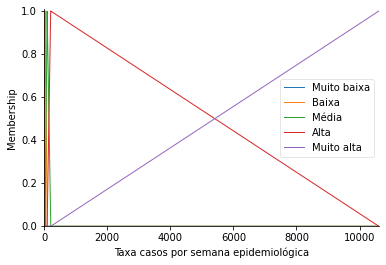

In [196]:
x_taxa_casos = np.arange(df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.min(),
                         df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.max(), 0.1)
antecedent_taxa_casos = ctrl.Antecedent(x_taxa_casos, "Taxa casos por semana epidemiológica")
antecedent_taxa_casos['Muito baixa'] = fuzz.trimf(x_taxa_casos,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.25)])
antecedent_taxa_casos['Baixa'] = fuzz.trimf(x_taxa_casos,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.25),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.median()])
antecedent_taxa_casos['Média'] = fuzz.trimf(x_taxa_casos,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.25),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.median(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.75)])
antecedent_taxa_casos['Alta'] = fuzz.trimf(x_taxa_casos,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.median(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.75),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.max()])
antecedent_taxa_casos['Muito alta'] = fuzz.trimf(x_taxa_casos,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.quantile(0.75),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.max(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.TAXA_CASOS_NOVOS.max()])
antecedent_taxa_casos.view()

/home/helder/Codigos/Python/scikit-fuzzy/skfuzzy/control/fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


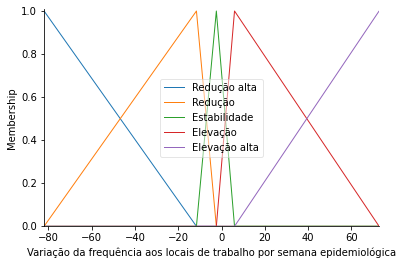

In [197]:
x_variacao_trabalho = np.arange(df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.min(),
                         df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.max(), 0.1)
antecedent_variacao_trabalho = ctrl.Antecedent(x_variacao_trabalho, "Variação da frequência aos locais de trabalho por semana epidemiológica")
antecedent_variacao_trabalho['Redução alta'] = fuzz.trimf(x_variacao_trabalho,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.25)])
antecedent_variacao_trabalho['Redução'] = fuzz.trimf(x_variacao_trabalho,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.min(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.25),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.median()])
antecedent_variacao_trabalho['Estabilidade'] = fuzz.trimf(x_variacao_trabalho,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.25),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.median(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.75)])
antecedent_variacao_trabalho['Elevação'] = fuzz.trimf(x_variacao_trabalho,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.median(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.75),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.max()])
antecedent_variacao_trabalho['Elevação alta'] = fuzz.trimf(x_variacao_trabalho,
    [df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.quantile(0.75),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.max(),
     df_mobilidade_trabalho_covid_semana_epidemiologica.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO.max()])
antecedent_variacao_trabalho.view()

/home/helder/Codigos/Python/scikit-fuzzy/skfuzzy/control/fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


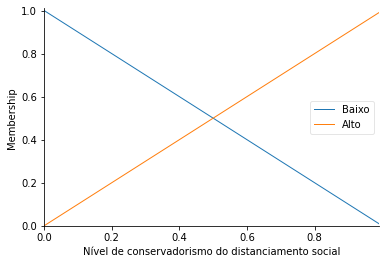

In [198]:
consequent_nivel_conservadorismo_resposta = ctrl.Consequent(np.arange(0, 1, 0.01), "Nível de conservadorismo do distanciamento social")
consequent_nivel_conservadorismo_resposta['Baixo'] = fuzz.trimf(consequent_nivel_conservadorismo_resposta.universe, [0, 0, 1])
consequent_nivel_conservadorismo_resposta['Alto'] = fuzz.trimf(consequent_nivel_conservadorismo_resposta.universe, [0, 1, 1])
consequent_nivel_conservadorismo_resposta.view()

In [199]:
regra_1 = ctrl.Rule(
    (antecedent_taxa_casos['Muito alta'] & antecedent_variacao_trabalho['Redução alta']),
    consequent_nivel_conservadorismo_resposta['Alto'])
regra_2 = ctrl.Rule(
    (antecedent_taxa_casos['Alta'] & (antecedent_variacao_trabalho['Redução'] | antecedent_variacao_trabalho['Redução alta'])),
    consequent_nivel_conservadorismo_resposta['Alto'])
regra_3 = ctrl.Rule(
    (antecedent_taxa_casos['Média'] & (antecedent_variacao_trabalho['Redução'] | antecedent_variacao_trabalho['Redução alta'])),
    consequent_nivel_conservadorismo_resposta['Alto'])
regra_4 = ctrl.Rule(
    (antecedent_taxa_casos['Baixa'] & (antecedent_variacao_trabalho['Redução'] | antecedent_variacao_trabalho['Redução alta'])),
    consequent_nivel_conservadorismo_resposta['Alto'])
regra_5 = ctrl.Rule(
    (antecedent_taxa_casos['Muito baixa'] & (
            antecedent_variacao_trabalho['Elevação'] |
            antecedent_variacao_trabalho['Estabilidade'] |
            antecedent_variacao_trabalho['Redução'] |
            antecedent_variacao_trabalho['Redução alta'])),
    consequent_nivel_conservadorismo_resposta['Alto'])
regra_6 = ctrl.Rule(
    (antecedent_taxa_casos['Muito alta'] & (antecedent_variacao_trabalho['Redução'] |
                                            antecedent_variacao_trabalho['Estabilidade'] |
                                            antecedent_variacao_trabalho['Elevação'] |
                                            antecedent_variacao_trabalho['Elevação alta'])),
    consequent_nivel_conservadorismo_resposta['Baixo'])
regra_7 = ctrl.Rule(
    (antecedent_taxa_casos['Alta'] & (antecedent_variacao_trabalho['Estabilidade'] |
                                            antecedent_variacao_trabalho['Elevação'] |
                                            antecedent_variacao_trabalho['Elevação alta'])),
    consequent_nivel_conservadorismo_resposta['Baixo'])
regra_8 = ctrl.Rule(
    (antecedent_taxa_casos['Média'] & (antecedent_variacao_trabalho['Estabilidade'] |
                                       antecedent_variacao_trabalho['Elevação'] |
                                       antecedent_variacao_trabalho['Elevação alta'])),
    consequent_nivel_conservadorismo_resposta['Baixo'])
regra_9 = ctrl.Rule(
    (antecedent_taxa_casos['Baixa'] & (antecedent_variacao_trabalho['Estabilidade'] |
                                       antecedent_variacao_trabalho['Elevação'] |
                                       antecedent_variacao_trabalho['Elevação alta'])),
    consequent_nivel_conservadorismo_resposta['Baixo'])
regra_10 = ctrl.Rule(
    (antecedent_taxa_casos['Muito baixa'] & antecedent_variacao_trabalho['Elevação alta']),
    consequent_nivel_conservadorismo_resposta['Alto'])

control_system = ctrl.ControlSystem(
    rules = [regra_1, regra_2, regra_3, regra_4, regra_5, regra_6, regra_7, regra_8, regra_9, regra_10])
simulation = ctrl.ControlSystemSimulation(control_system)

In [200]:
df_mobilidade_trabalho_covid_semana_epidemiologica['INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO'] = None
for index, row in df_mobilidade_trabalho_covid_semana_epidemiologica.iterrows():
    simulation.input["Taxa casos por semana epidemiológica"] = row['TAXA_CASOS_NOVOS']
    simulation.input["Variação da frequência aos locais de trabalho por semana epidemiológica"] = row['PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO']
    simulation.compute()
    df_mobilidade_trabalho_covid_semana_epidemiologica.loc[index, 'INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO'] = \
        simulation.output['Nível de conservadorismo do distanciamento social']

df_mobilidade_trabalho_covid_semana_epidemiologica['INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO'] = \
    df_mobilidade_trabalho_covid_semana_epidemiologica.INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO.astype(float)

df_mobilidade_trabalho_covid_semana_epidemiologica.to_csv('dados/df_mobilidade_trabalho_covid_semana_epidemiologica.csv', index=False)

In [201]:
df_mobilidade_trabalho_covid_semana_epidemiologica = pd.read_csv('dados/df_mobilidade_trabalho_covid_semana_epidemiologica.csv')
df_mobilidade_trabalho_covid_semana_epidemiologica.CODIGO_MUNICIPIO_6 = \
    df_mobilidade_trabalho_covid_semana_epidemiologica.CODIGO_MUNICIPIO_6.astype(int).astype(str)

In [202]:
df_mobilidade_trabalho_covid_media = df_mobilidade_trabalho_covid_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').mean()[
    ['INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']]
df_mobilidade_trabalho_covid_media = df_mobilidade_trabalho_covid_media.reset_index()
df_mobilidade_trabalho_covid_media.columns = ['CODIGO_MUNICIPIO_6', 'MEDIA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']
df_base = pd.merge(df_base, df_mobilidade_trabalho_covid_media, how='left', on='CODIGO_MUNICIPIO_6')

df_mobilidade_trabalho_covid_mediana = df_mobilidade_trabalho_covid_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').median()[
    ['INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']]
df_mobilidade_trabalho_covid_mediana = df_mobilidade_trabalho_covid_mediana.reset_index()
df_mobilidade_trabalho_covid_mediana.columns = ['CODIGO_MUNICIPIO_6', 'MEDIANA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']
df_base = pd.merge(df_base, df_mobilidade_trabalho_covid_mediana, how='left', on='CODIGO_MUNICIPIO_6')

df_mobilidade_trabalho_covid_3_quartile = df_mobilidade_trabalho_covid_semana_epidemiologica.groupby('CODIGO_MUNICIPIO_6').quantile(0.75)[
    ['INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']]
df_mobilidade_trabalho_covid_3_quartile = df_mobilidade_trabalho_covid_3_quartile.reset_index()
df_mobilidade_trabalho_covid_3_quartile.columns = ['CODIGO_MUNICIPIO_6', 'QUARTILE_3_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']
df_base = pd.merge(df_base, df_mobilidade_trabalho_covid_3_quartile, how='left', on='CODIGO_MUNICIPIO_6')

#### Creating new attributes

In [270]:
df_base['TAXA_CASOS'] = df_base.CASOS / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_OBITOS'] = df_base.OBITOS / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_LETALIDADE'] = df_base.OBITOS / df_base.CASOS * 100
df_base['RAZAO_POPULACAO_MASCULINA_FEMININA'] = df_base.POPULACAO_MASCULINA / df_base.POPULACAO_FEMININA
df_base['RAZAO_POPULACAO_RURAL_URBANA'] = df_base.POPULACAO_RURAL / df_base.POPULACAO_URBANA
df_base['PERCENTUAL_POPULACAO_URBANA'] = df_base.POPULACAO_URBANA / df_base.POPULACAO_TOTAL * 100
df_base['PERCENTUAL_POPULACAO_SEDE_MUNICIPAL'] = df_base.POPULACAO_SEDE_MUNICIPAL / df_base.POPULACAO_TOTAL * 100
df_base['RAZAO_POPULCAO_DOMICILIOS_ESTIMADA'] = df_base.POPULACAO_ESTIMADA / df_base.DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO
df_base['PERCENTUAL_POPULACAO_17_ANOS_OU_MENOS'] = \
    (df_base.POPULACAO_ATE_1_ANO + df_base.POPULACAO_1_A_3_ANOS + df_base.POPULACAO_4_ANOS + df_base.POPULACAO_5_ANOS +
     df_base.POPULACAO_6_A_10_ANOS + df_base.POPULACAO_11_A_14_ANOS + df_base.POPULACAO_15_A_17_ANOS) / df_base.POPULACAO_TOTAL * 100
df_base['PERCENTUAL_POPULACAO_18_ATE_39_ANOS'] = (df_base.POPULACAO_18_ANOS_OU_MAIS / df_base.POPULACAO_TOTAL * 100) - df_base.PERCENTUAL_POPULACAO_40_A_59_ANOS - df_base.PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS
df_base['DENSIDADE_DOMICILIOS'] = df_base.DOMICILIOS_PARTICULARES_OCUPADOS / df_base.AREA
df_base['PERCENTUAL_DOMICILIOS_AGLOMERADOS'] = df_base.DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS / df_base.DOMICILIOS_PARTICULARES_OCUPADOS * 100
df_base['PERCENTUAL_POPULACAO_AGLOMERADOS'] = df_base.POPULACAO_AGLOMERADOS / df_base.POPULACAO_TOTAL * 100
df_base['DENSIDADE_DOMICILIOS_ESTIMADA'] = df_base.DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO / df_base.AREA
df_base['TOTAL_VOTOS'] = df_base.VOTOS_BOLSONARO + df_base.VOTOS_HADDAD + df_base.VOTOS_NULO + df_base.VOTOS_BRANCO
df_base['PERCENTUAL_VOTOS_BOLSONARO'] = df_base.VOTOS_BOLSONARO / df_base.TOTAL_VOTOS * 100
df_base['PERCENTUAL_VOTOS_HADDAD'] = df_base.VOTOS_HADDAD / df_base.TOTAL_VOTOS * 100
df_base['TAXA_LEITOS_INTERNACAO_TOTAL_2019_12'] = df_base.LEITOS_INTERNACAO_TOTAL_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_LEITOS_UTI_TOTAL_2019_12'] = df_base.LEITOS_UTI_TOTAL_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_MEDICOS_TOTAL_2019_12'] = df_base.MEDICOS_TOTAL_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_ENFERMEIROS_TOTAL_2019_12'] = df_base.ENFERMEIROS_TOTAL_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12'] = df_base.VENTILADORES_RESPIRADORES_EM_USO_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA'] = df_base.LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA'] = df_base.LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA'] = df_base.MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA'] = df_base.ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA'] = df_base.VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA'] = df_base.LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000
df_base['TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA'] = df_base.LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000
df_base['TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA'] = df_base.MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000
df_base['TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA'] = df_base.ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000
df_base['TAXA_VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA'] = df_base.VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000

#### Analizing the attributes

In [204]:
taxa_obitos_brasil = df_base.OBITOS.sum() / df_base.POPULACAO_ESTIMADA.sum() * 100000
print('Taxa de óbitos no Brasil: '+ str(taxa_obitos_brasil))

df_regioes_brasil = df_base.groupby('REGIAO').sum()[['OBITOS','POPULACAO_ESTIMADA']]
df_regioes_brasil['TAXA_OBITOS'] = df_regioes_brasil.OBITOS / df_regioes_brasil.POPULACAO_ESTIMADA * 100000
print(df_regioes_brasil)

df_estados_brasil = df_base.groupby('ESTADO').sum()[['OBITOS','POPULACAO_ESTIMADA']]
df_estados_brasil['TAXA_OBITOS'] = df_estados_brasil.OBITOS / df_estados_brasil.POPULACAO_ESTIMADA * 100000
print(df_estados_brasil)

Taxa de óbitos no Brasil: 274.99686231729316
              OBITOS  POPULACAO_ESTIMADA  TAXA_OBITOS
REGIAO                                               
Centro-Oeste   54888            16297074   336.796654
Nordeste      114905            57071654   201.334624
Norte          45951            18430980   249.313927
Sudeste       272226            88371433   308.047511
Sul            89928            29975984   300.000160
                     OBITOS  POPULACAO_ESTIMADA  TAXA_OBITOS
ESTADO                                                      
Acre                   1813              881935   205.570705
Alagoas                6054             3337357   181.401031
Amapá                  1951              845731   230.688008
Amazonas              13677             4144597   329.995896
Bahia                 26129            14873064   175.680008
Ceará                 24015             9132078   262.974101
Distrito Federal      10007             3015268   331.877631
Espírito Santo        11976 

array([[<AxesSubplot:title={'center':'TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA'}, xlabel='[REGIAO]'>,
        <AxesSubplot:title={'center':'TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA'}, xlabel='[REGIAO]'>],
       [<AxesSubplot:title={'center':'TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA'}, xlabel='[REGIAO]'>,
        <AxesSubplot:>]], dtype=object)

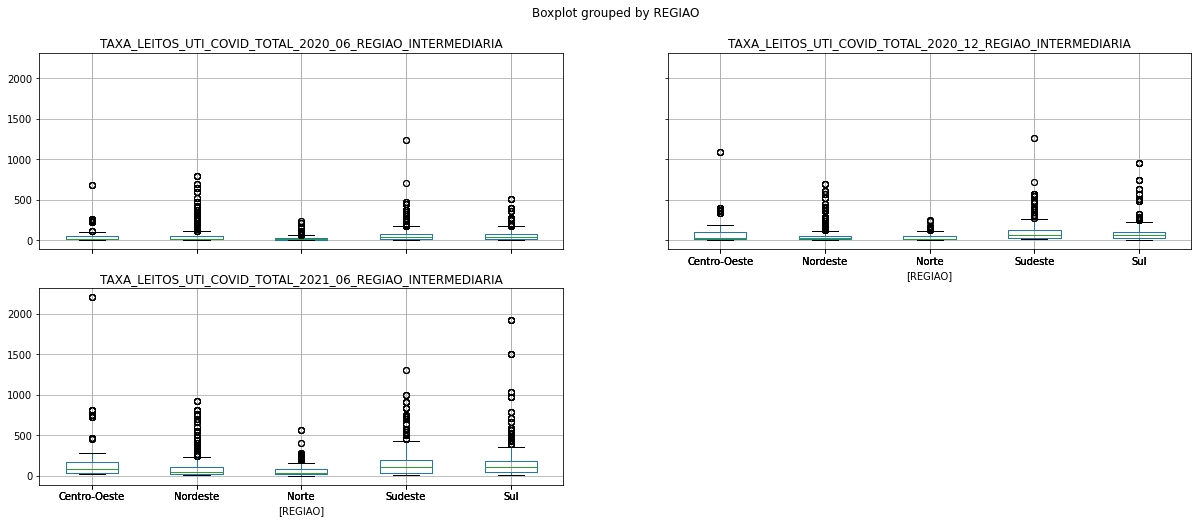

In [205]:
df_base[["TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA",
         "TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA",
         "TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA", 'REGIAO']].boxplot(by='REGIAO', figsize=(20,8))

In [206]:
from IPython.display import display

def show_analisys_attribute(df, attribute):
    display(df)
    display(df.describe())

    df[attribute].hist(legend=True)
    plt.show()
    df.boxplot(column=[attribute])
    plt.show()
    df[attribute].hist(by=df_base.REGIAO)
    plt.show()
    df[[attribute,'REGIAO']].boxplot(by='REGIAO')
    plt.show()
    ax = plt.figure(figsize = (15,20)).gca()
    df[attribute].hist(by=df_base.ESTADO, ax=ax)
    plt.show()
    df[[attribute,'SIGLA_ESTADO']].boxplot(by='SIGLA_ESTADO', figsize=(20,8))
    plt.show()
    df_mg = df[df['SIGLA_ESTADO'] == 'MG']
    ax = plt.figure(figsize = (15,20)).gca()
    df_mg[attribute].hist(by=df_mg.REGIAO_INTERMEDIARIA, ax=ax)
    plt.show()
    df_mg[[attribute,'REGIAO_INTERMEDIARIA']].boxplot(by='REGIAO_INTERMEDIARIA', figsize=(20,8))
    plt.show()
    df_regiao_moc = df[df.REGIAO_INTERMEDIARIA == 'Montes Claros']
    ax = plt.figure(figsize = (15,20)).gca()
    df_regiao_moc[attribute].hist(by=df_regiao_moc.REGIAO_IMEDIATA, ax=ax)
    plt.show()
    df_regiao_moc[[attribute,'REGIAO_IMEDIATA']].boxplot(by='REGIAO_IMEDIATA', figsize=(20,8))
    plt.show()

,MUNICIPIO,CODIGO_MUNICIPIO_6,SIGLA_ESTADO,CODIGO_ESTADO,REGIAO,REGIAO_SAUDE,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,CASOS,OBITOS,...,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA
0,Alta Floresta D'Oeste,110001,RO,11,Norte,ZONA DA MATA,11005.0,0.0,4057.0,65,...,40.589951,3.247196,157.813728,120.146254,12.988784,36.482895,2.183835,127.561671,99.171813,11.433020
1,Ariquemes,110002,RO,11,Norte,VALE DO JAMARI,11001.0,0.0,22501.0,494,...,54.239894,11.958402,85.417156,71.323325,20.927203,60.373777,12.615416,153.988174,115.040580,28.634992
2,Cabixi,110003,RO,11,Norte,CONE SUL,11006.0,0.0,907.0,21,...,12.016722,0.000000,130.286567,111.312795,10.119345,36.482895,2.183835,127.561671,99.171813,11.433020
3,Cacoal,110004,RO,11,Norte,CAFE,11002.0,0.0,14507.0,302,...,40.589951,3.247196,157.813728,120.146254,12.988784,36.482895,2.183835,127.561671,99.171813,11.433020
4,Cerejeiras,110005,RO,11,Norte,CONE SUL,11006.0,0.0,2537.0,61,...,12.016722,0.000000,130.286567,111.312795,10.119345,36.482895,2.183835,127.561671,99.171813,11.433020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,Vianópolis,522200,GO,52,Centro-Oeste,CENTRO SUL,52002.0,0.0,974.0,33,...,86.453458,7.637806,173.719449,101.404056,13.488040,131.938404,17.916559,234.593248,118.243874,28.200988
5566,Vicentinópolis,522205,GO,52,Centro-Oeste,CENTRO SUL,52002.0,0.0,1377.0,24,...,56.862393,0.000000,65.840666,94.271862,5.985515,74.278132,11.778733,127.162239,85.335718,15.865232
5567,Vila Boa,522220,GO,52,Centro-Oeste,ENTORNO NORTE,52003.0,0.0,198.0,4,...,0.000000,0.000000,63.498111,71.435375,0.000000,30.847536,0.936958,78.632387,64.866314,2.810874
5568,Vila Propício,522230,GO,52,Centro-Oeste,SAO PATRICIO II,52018.0,0.0,391.0,7,...,123.333996,8.752735,140.043764,126.118958,18.699025,111.454539,4.404561,103.794433,104.560444,12.256169


,CODIGO_ESTADO,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,CASOS,OBITOS,POPULACAO_ESTIMADA,DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO,DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO,PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO,CODIGO_REGIAO_IMEDIATA,...,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA
count,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5.570000e+03,5.570000e+03,5570.000000,5570.000000,5570.000000,...,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000
mean,32.377738,32403.123698,0.069300,3714.094434,103.751885,3.772839e+04,1.176968e+04,920.600898,1.043896,323793.462657,...,50.343383,6.197581,141.237603,113.414440,15.886186,57.550806,8.066071,160.989005,120.728879,19.166481
std,9.833862,9837.224401,0.253986,19091.629993,765.152091,2.214581e+05,7.378126e+04,12945.799490,4.509078,98340.639166,...,39.156400,7.144393,79.544378,33.585401,12.407539,31.545535,5.968023,69.462012,25.410903,9.676284
min,11.000000,11001.000000,0.000000,10.000000,0.000000,7.810000e+02,3.190000e+02,0.000000,0.000000,110001.000000,...,0.000000,0.000000,22.013312,35.609769,0.000000,0.000000,0.000000,26.054637,42.183698,0.000000
25%,25.000000,25010.000000,0.000000,450.000000,9.000000,5.446500e+03,1.698500e+03,0.000000,0.000000,250009.000000,...,18.515090,0.000000,75.856192,88.704539,5.544774,29.584962,3.673233,101.476569,102.276793,11.460727
50%,31.000000,31059.000000,0.000000,960.000000,20.000000,1.163100e+04,3.432500e+03,0.000000,0.000000,310039.000000,...,45.158062,3.764139,123.168115,106.120886,14.219747,57.716365,6.780069,165.082655,120.012020,19.725571
75%,41.000000,41015.000000,0.000000,2355.750000,51.000000,2.549050e+04,7.373000e+03,0.000000,0.000000,410019.000000,...,74.347123,9.364962,186.799997,133.714235,23.591634,79.503122,11.428339,203.706986,134.778301,25.414597
max,53.000000,53001.000000,1.000000,938981.000000,37030.000000,1.225202e+07,4.104611e+06,529921.000000,73.993700,530001.000000,...,257.652879,39.664799,490.043880,293.034134,79.658955,136.260269,39.664799,338.145730,226.665023,55.252137


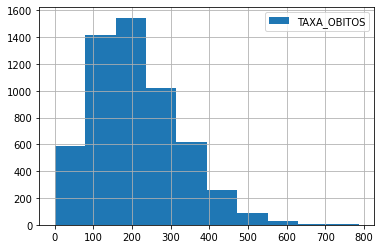

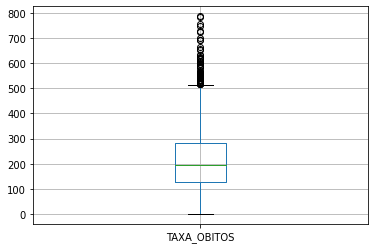

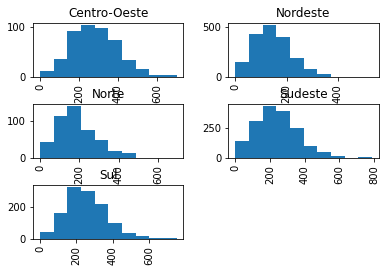

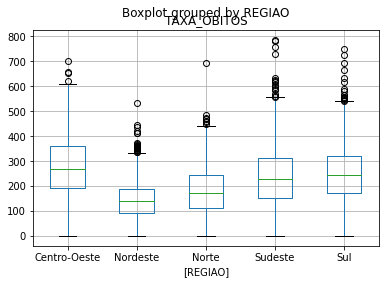

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


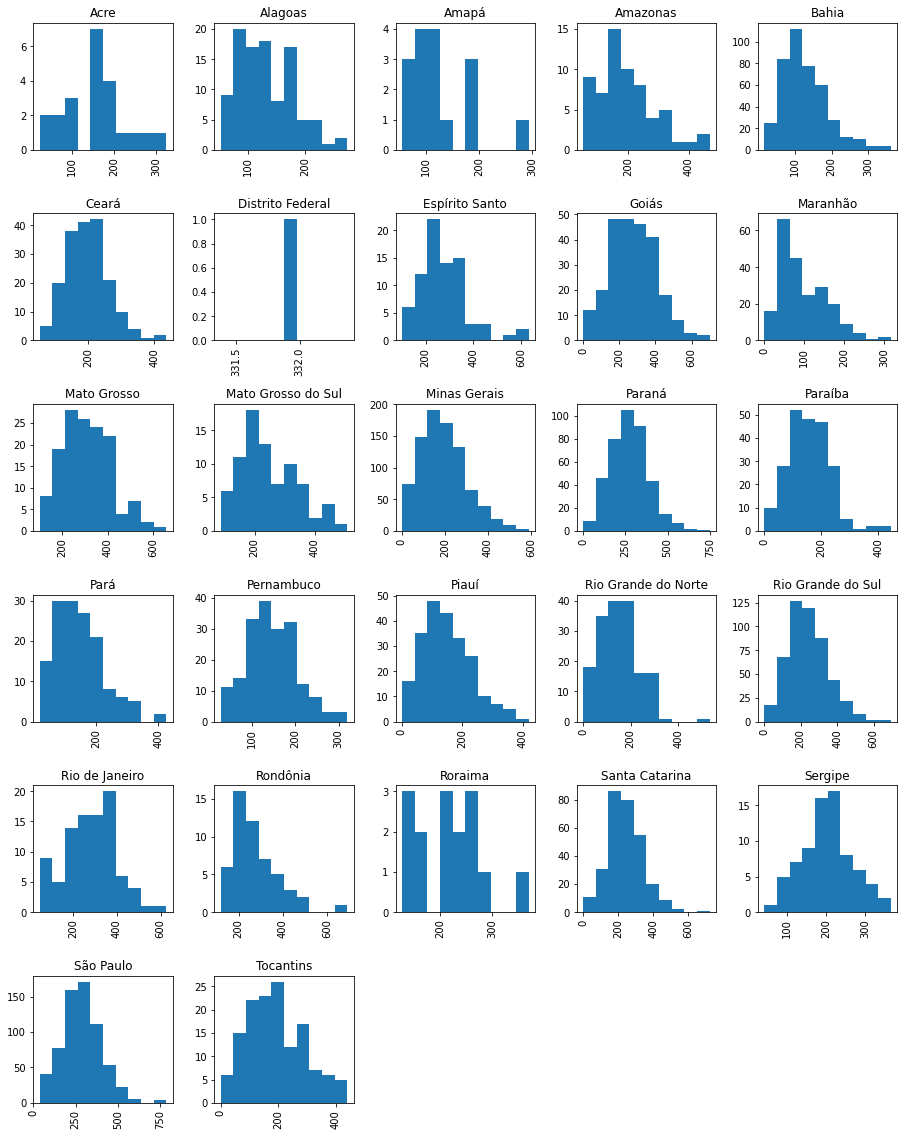

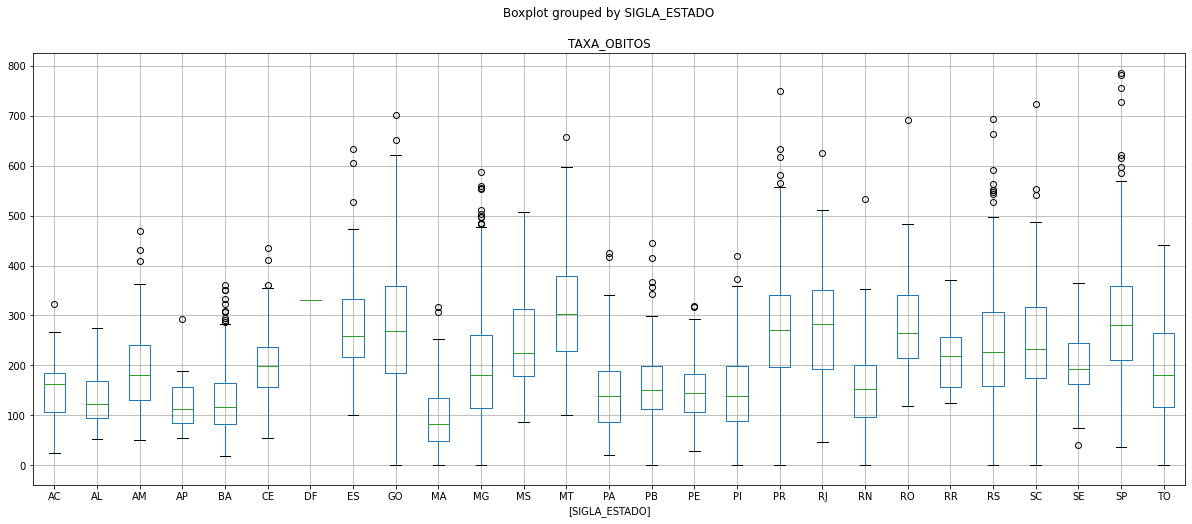

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


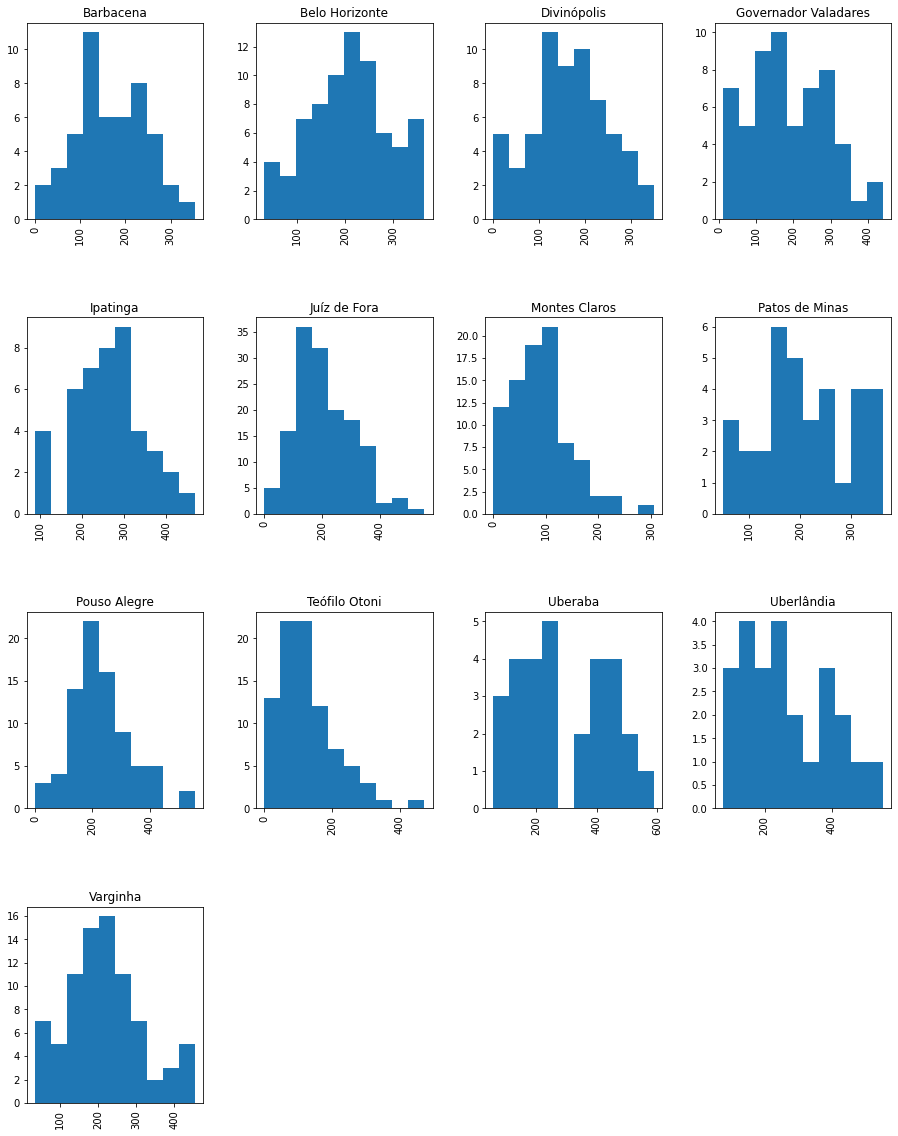

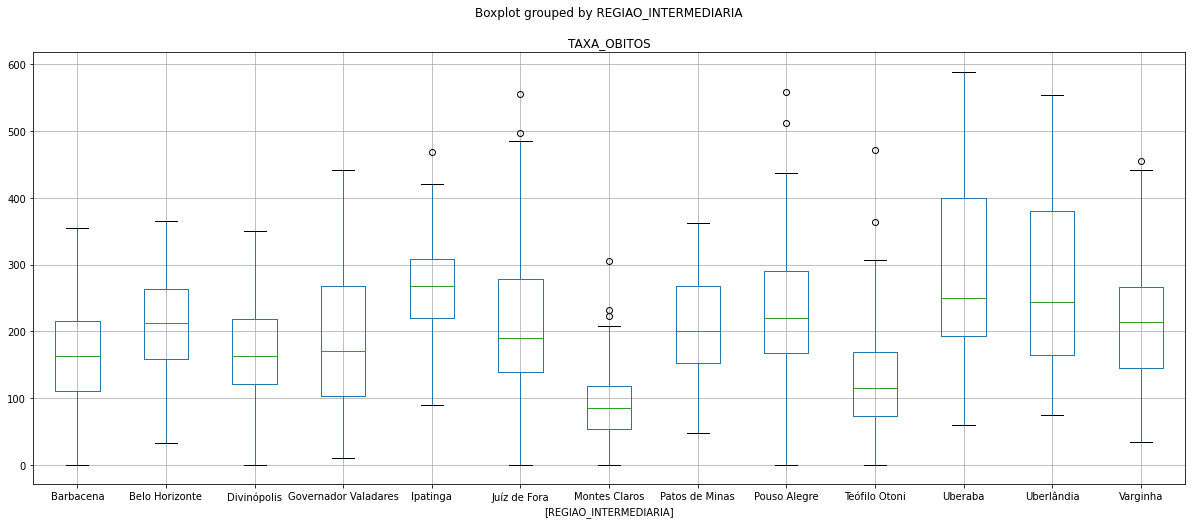

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


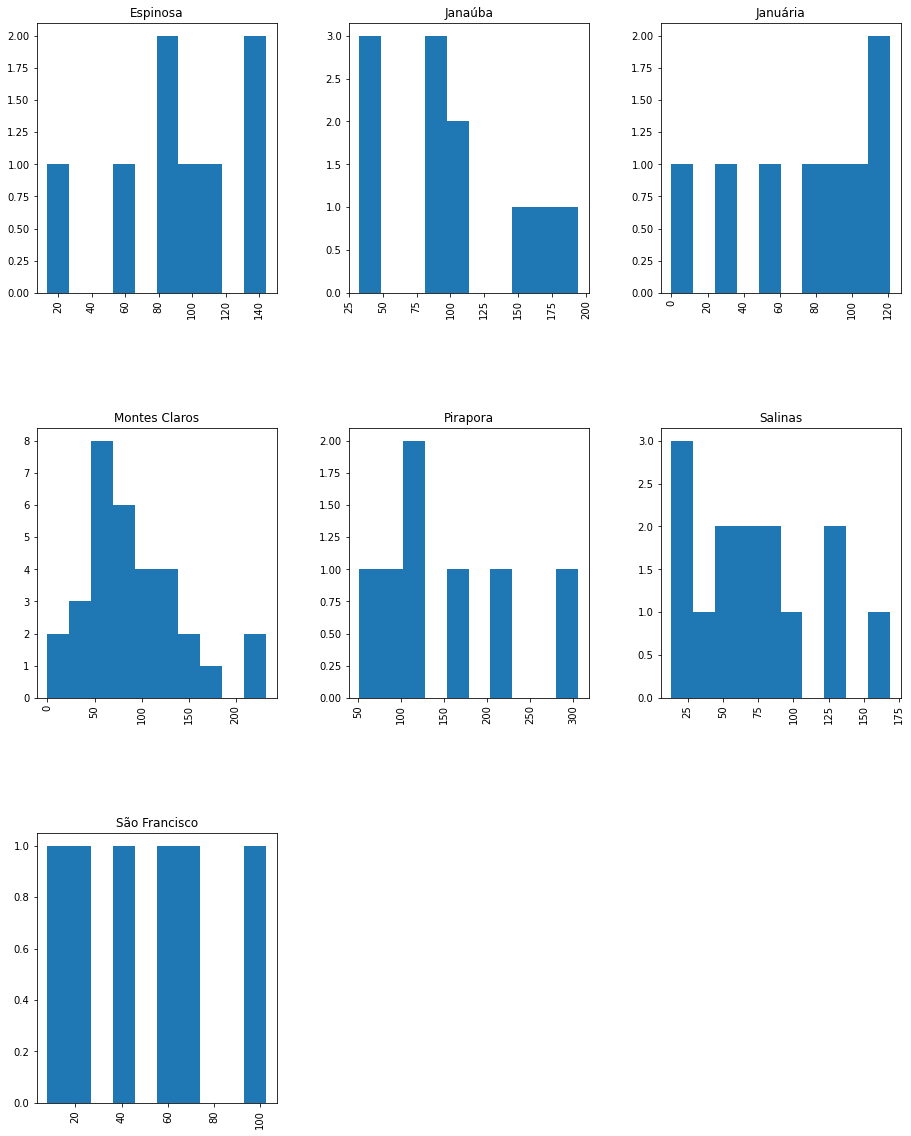

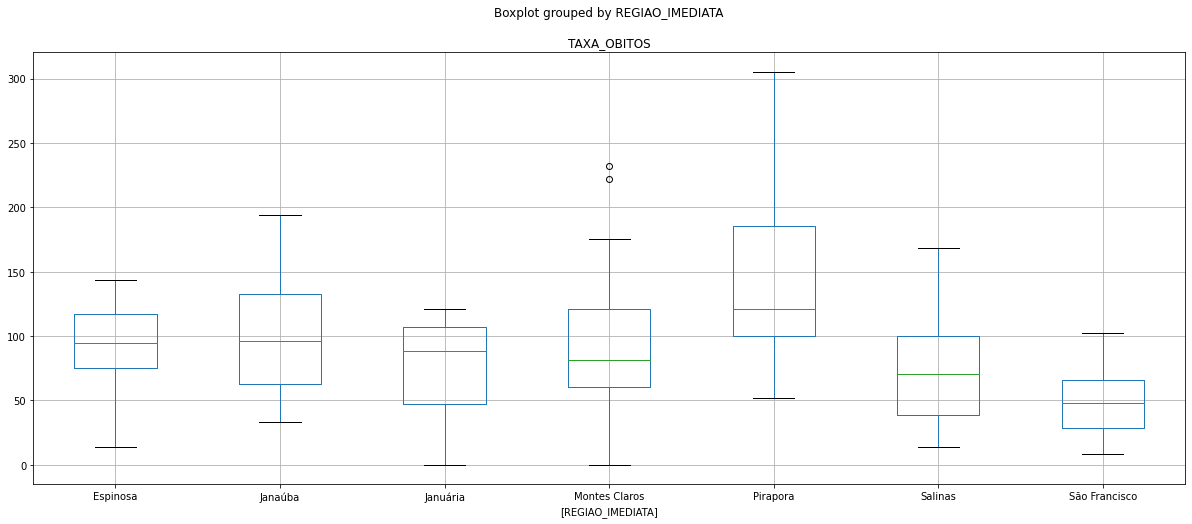

,CODIGO_MUNICIPIO_6,MEDIA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,MEDIA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS,REGIAO,SIGLA_ESTADO,REGIAO_INTERMEDIARIA,REGIAO_IMEDIATA
0,110001,NaN,12.369697,NaN,Norte,RO,Ji-Paraná,Cacoal
1,110002,NaN,9.708108,8.945946,Norte,RO,Porto Velho,Ariquemes
2,110004,NaN,6.062162,5.964865,Norte,RO,Ji-Paraná,Cacoal
3,110005,NaN,3.489951,NaN,Norte,RO,Ji-Paraná,Vilhena
4,110006,NaN,5.028125,NaN,Norte,RO,Ji-Paraná,Vilhena
...,...,...,...,...,...,...,...,...
2303,522140,-0.975676,-3.935135,11.545946,Centro-Oeste,GO,Goiânia,Goiânia
2304,522160,-44.336992,3.476056,6.425676,Centro-Oeste,GO,Porangatu - Uruaçu,Uruaçu - Niquelândia
2305,522185,17.002817,-5.797297,12.935135,Centro-Oeste,GO,Luziânia - Águas Lindas de Goiás,Luziânia
2306,522200,NaN,0.845775,NaN,Centro-Oeste,GO,Goiânia,Anápolis


,MEDIA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,MEDIA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS
count,710.000000,2285.000000,1091.000000
mean,-28.645484,-3.179237,7.502753
std,25.528351,7.395087,4.146249
min,-99.937838,-56.000000,-71.000000
25%,-46.319928,-7.642537,5.611895
50%,-32.978150,-3.000000,7.829932
75%,-16.133099,1.406557,9.820946
max,110.245540,22.698361,16.706757


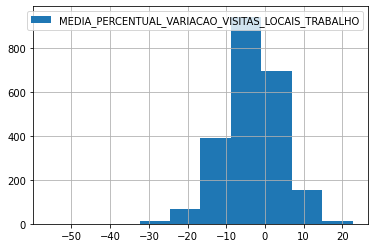

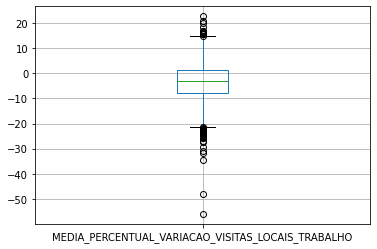

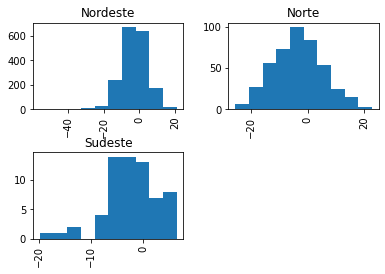

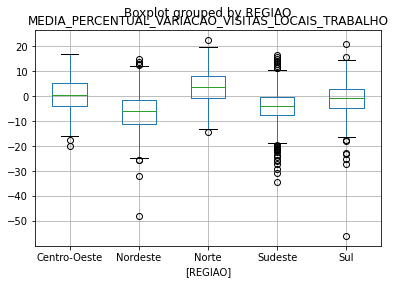

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


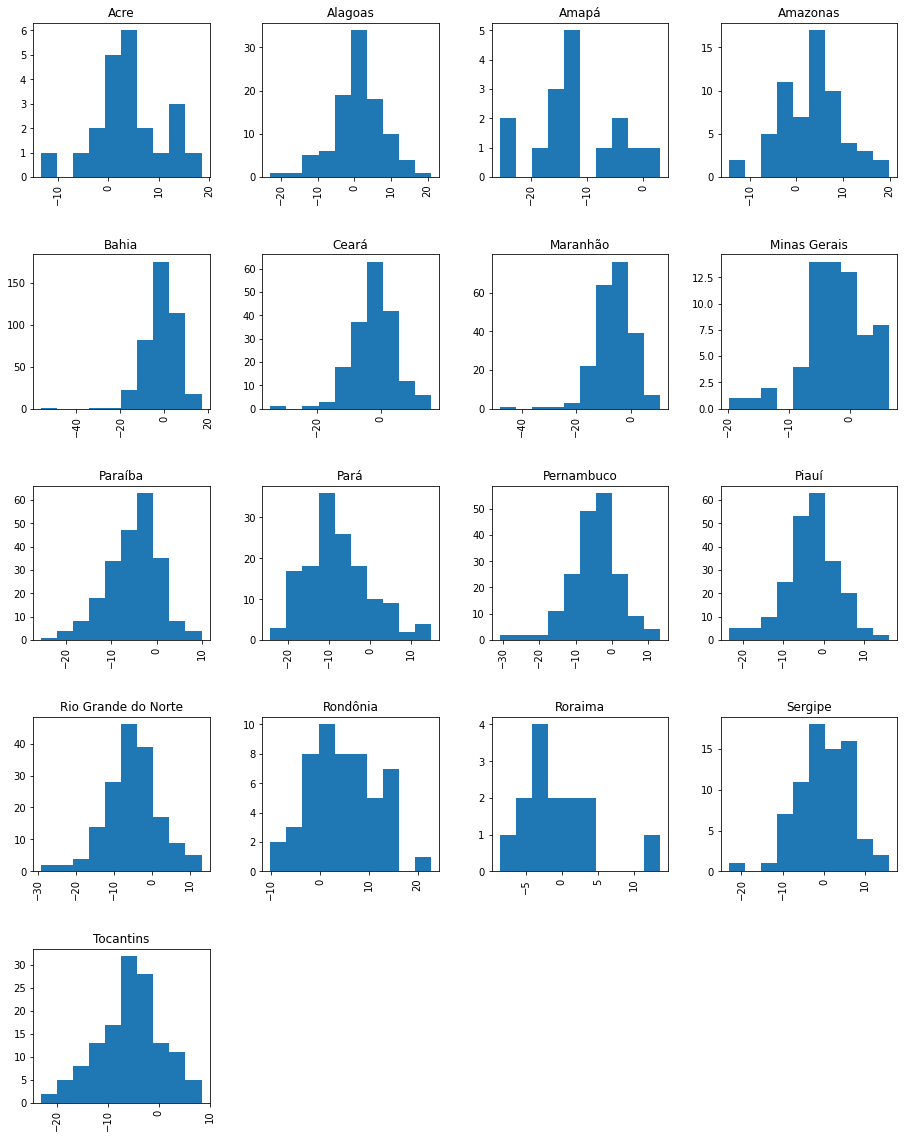

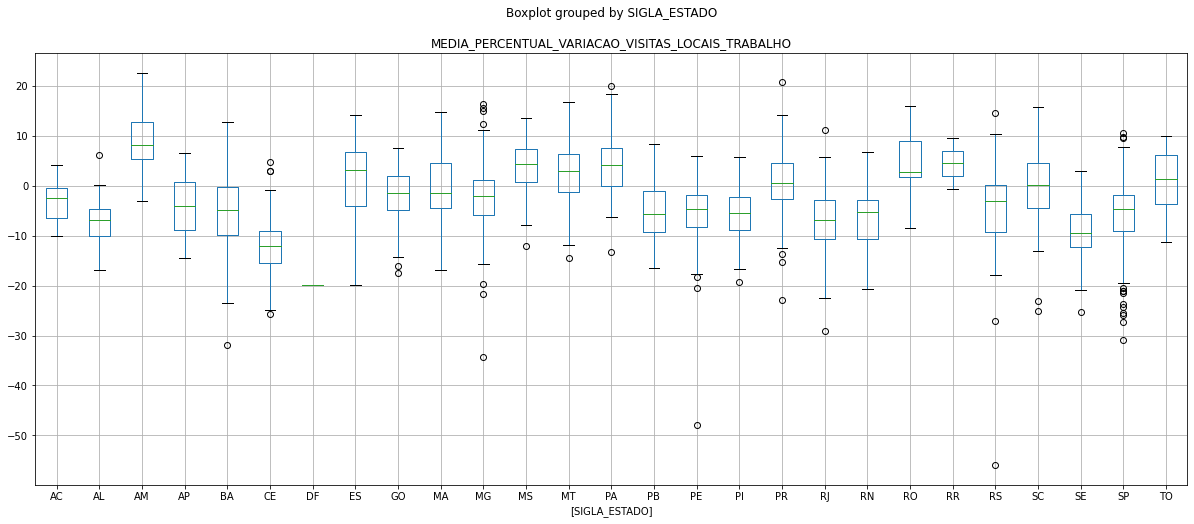

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


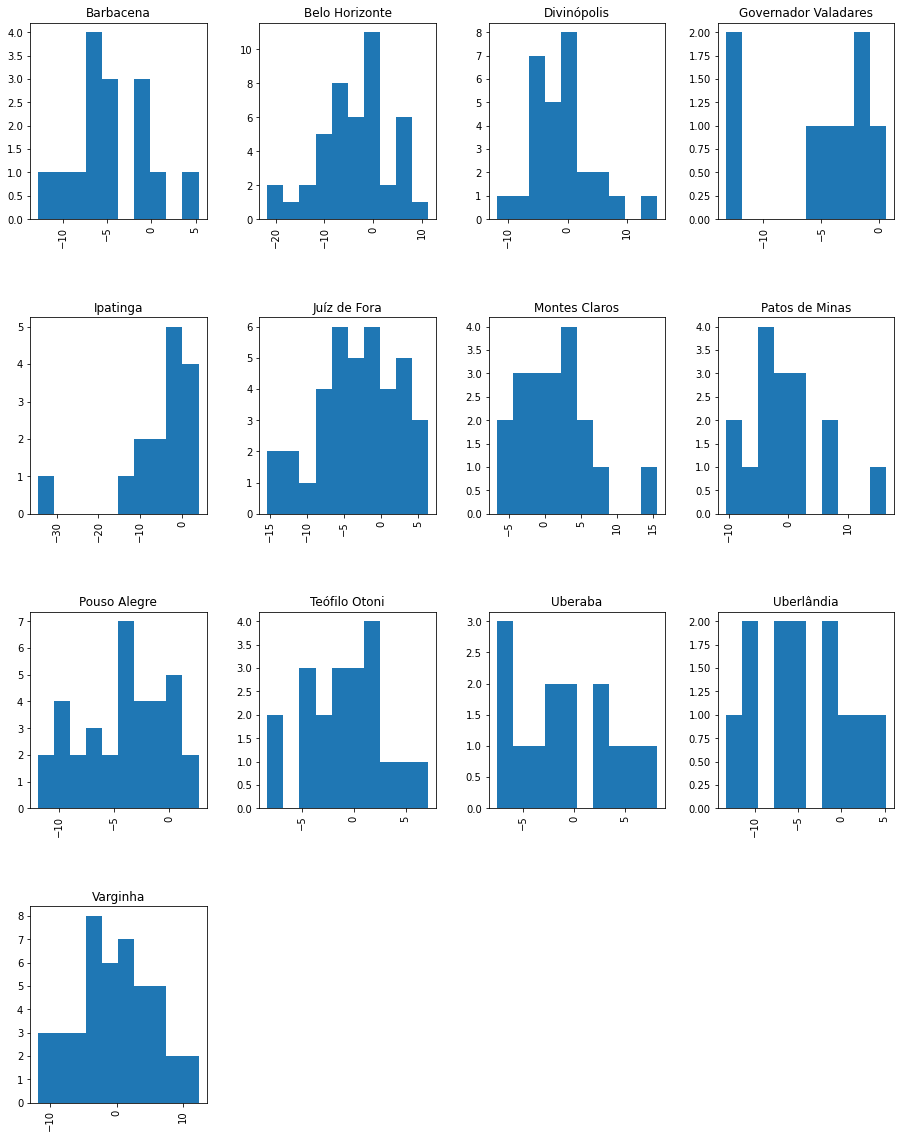

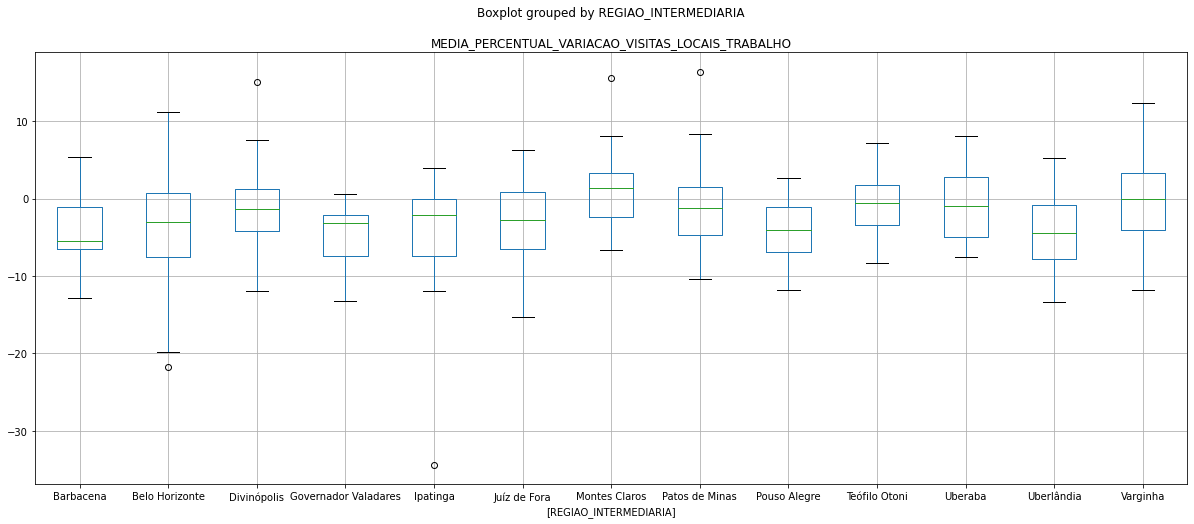

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


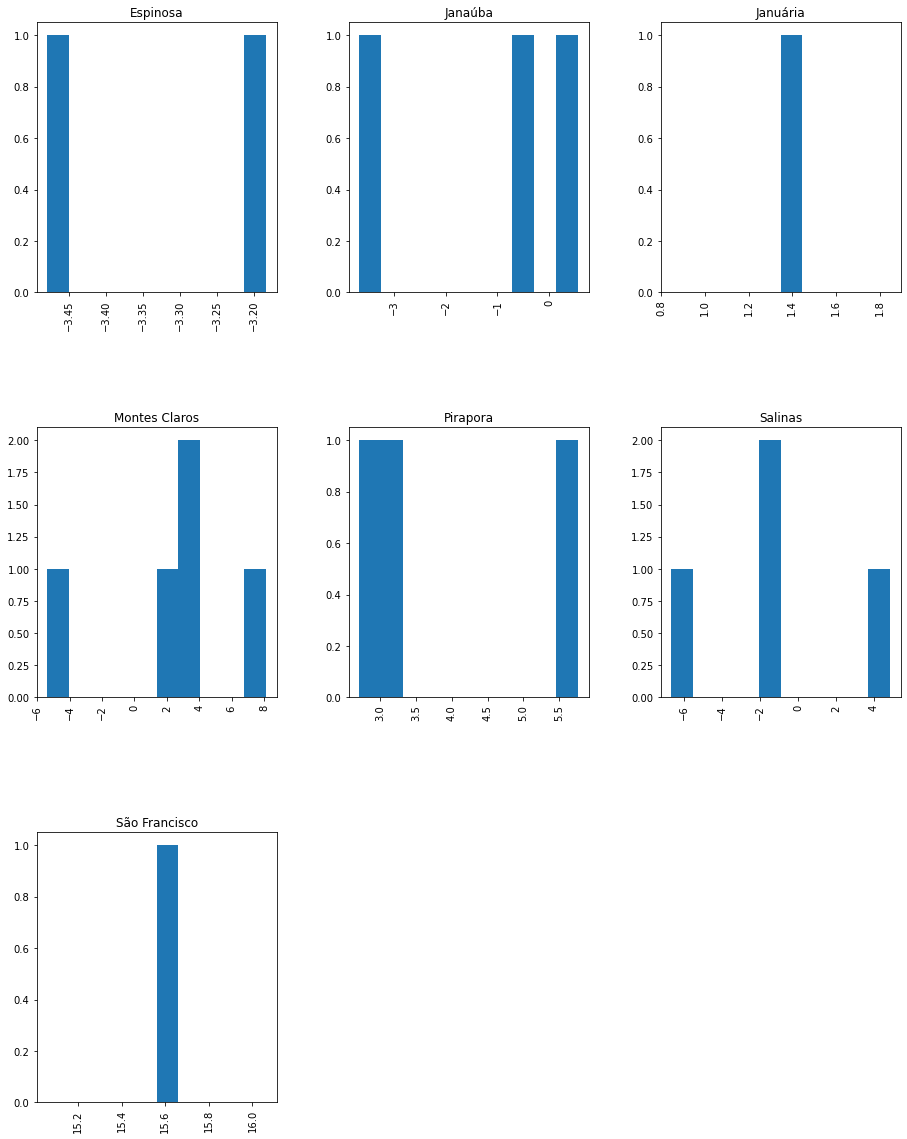

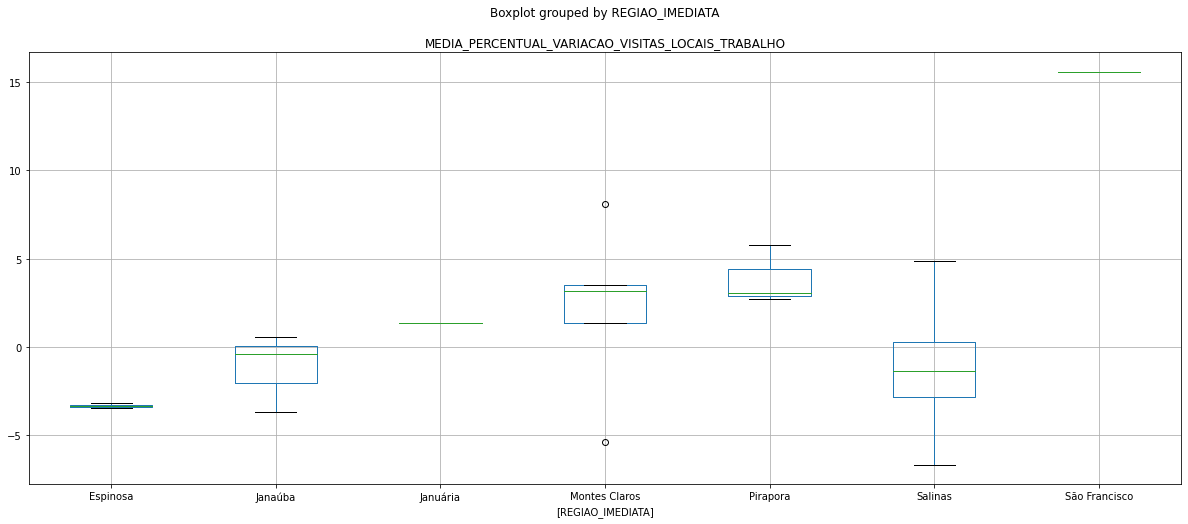

,CODIGO_MUNICIPIO_6,MEDIANA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS,REGIAO,SIGLA_ESTADO,REGIAO_INTERMEDIARIA,REGIAO_IMEDIATA
0,110001,NaN,14.9,NaN,Norte,RO,Ji-Paraná,Cacoal
1,110002,NaN,11.2,8.9,Norte,RO,Porto Velho,Ariquemes
2,110004,NaN,7.2,5.4,Norte,RO,Ji-Paraná,Cacoal
3,110005,NaN,6.5,NaN,Norte,RO,Ji-Paraná,Vilhena
4,110006,NaN,8.3,NaN,Norte,RO,Ji-Paraná,Vilhena
...,...,...,...,...,...,...,...,...
2303,522140,-2.100000,-0.8,10.9,Centro-Oeste,GO,Goiânia,Goiânia
2304,522160,-44.666667,3.8,5.8,Centro-Oeste,GO,Porangatu - Uruaçu,Uruaçu - Niquelândia
2305,522185,16.800000,-3.0,11.8,Centro-Oeste,GO,Luziânia - Águas Lindas de Goiás,Luziânia
2306,522200,NaN,2.6,NaN,Centro-Oeste,GO,Goiânia,Anápolis


,MEDIANA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS
count,710.000000,2285.000000,1091.000000
mean,-27.429930,-2.004894,6.756470
std,28.105821,6.996362,3.898822
min,-100.000000,-56.000000,-71.000000
25%,-46.575000,-6.000000,5.100000
50%,-31.150000,-1.800000,7.000000
75%,-14.025000,2.400000,8.800000
max,143.800000,22.800000,16.200000


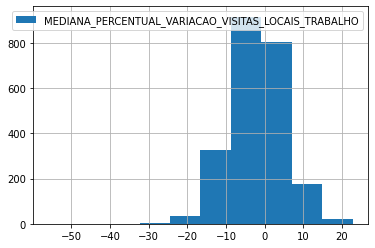

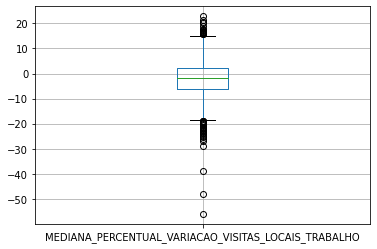

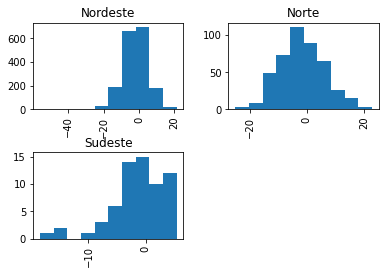

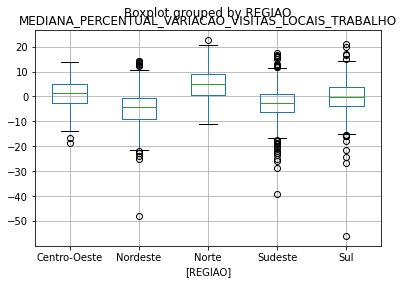

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


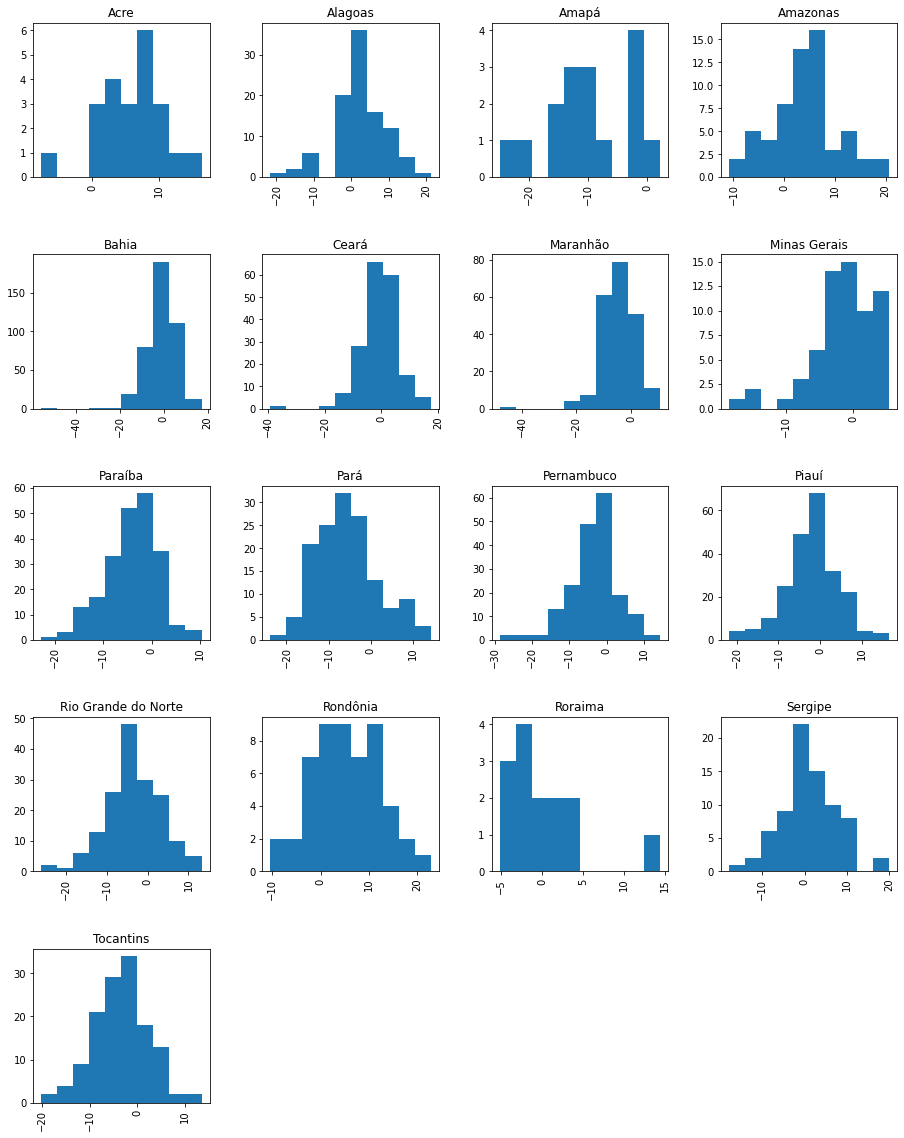

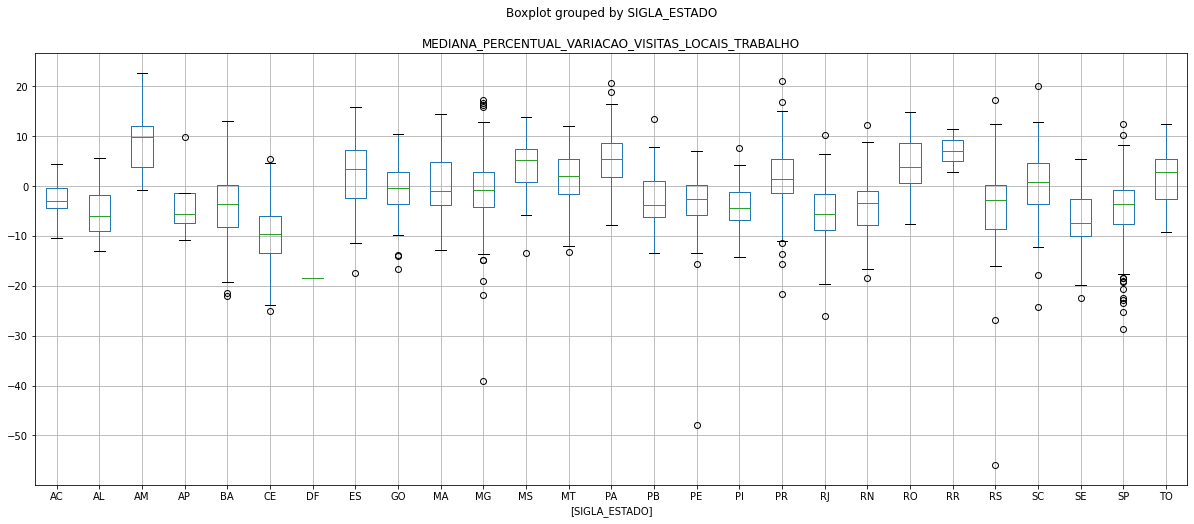

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


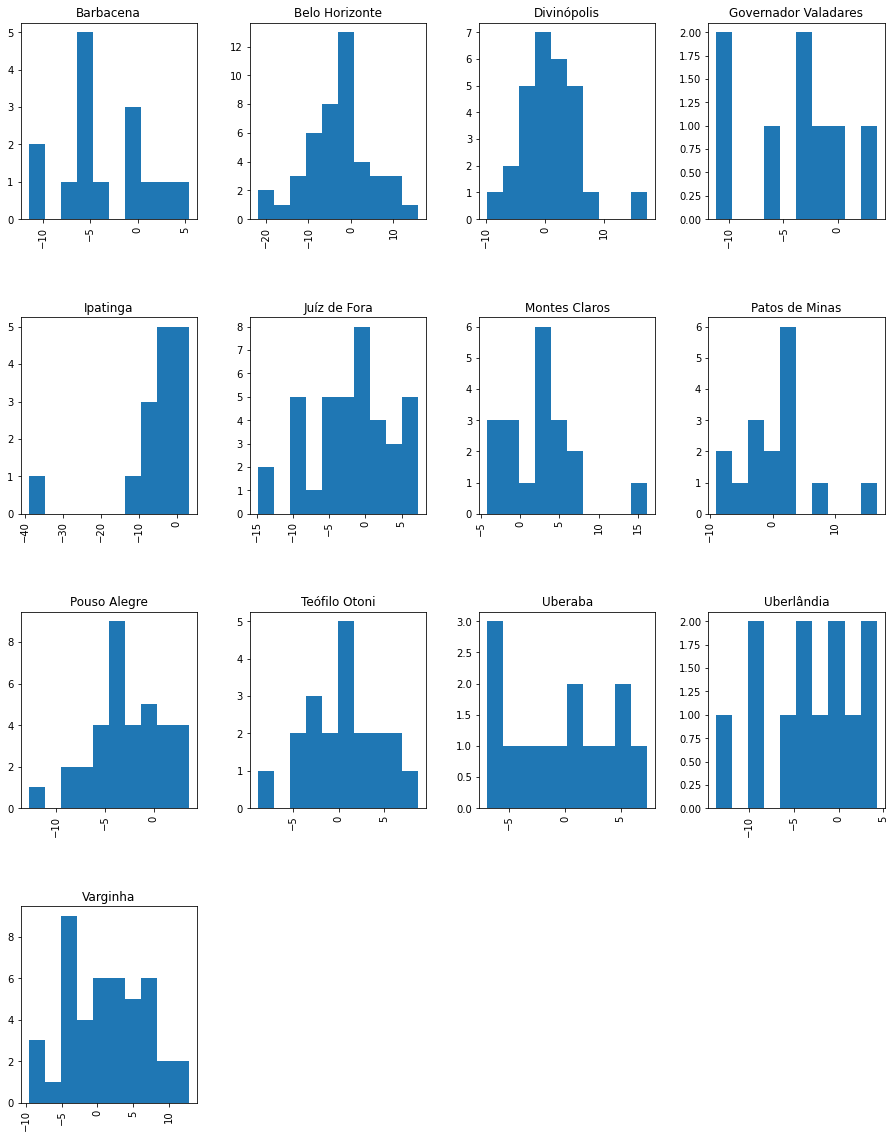

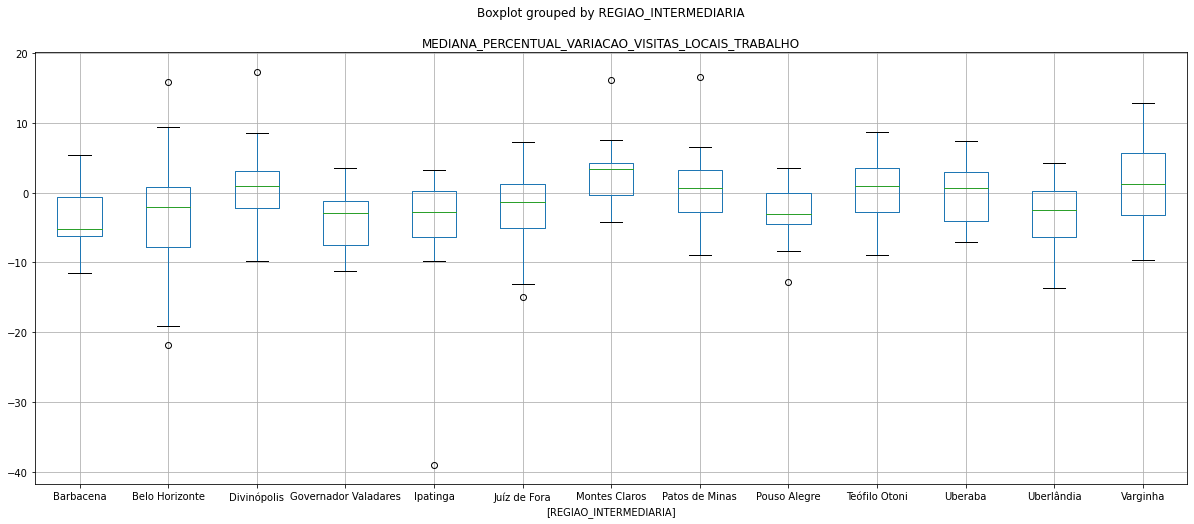

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


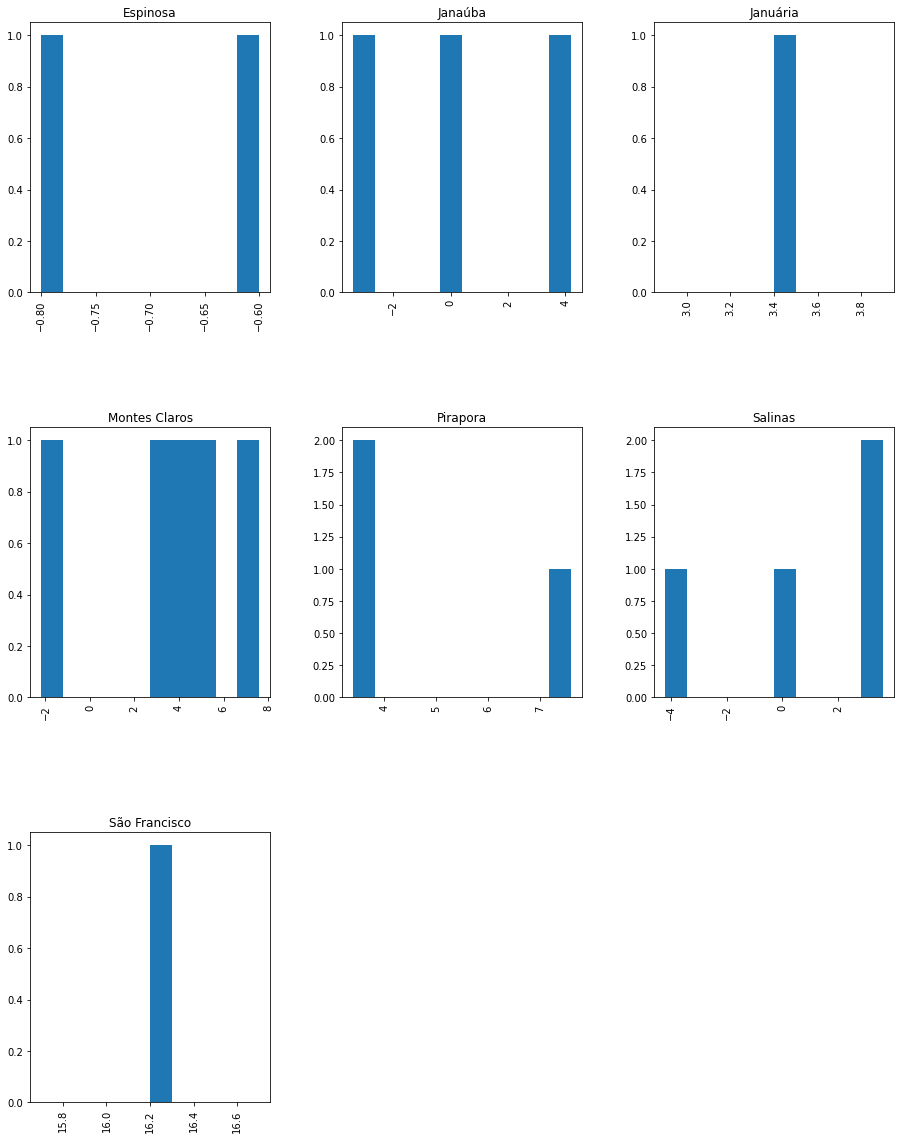

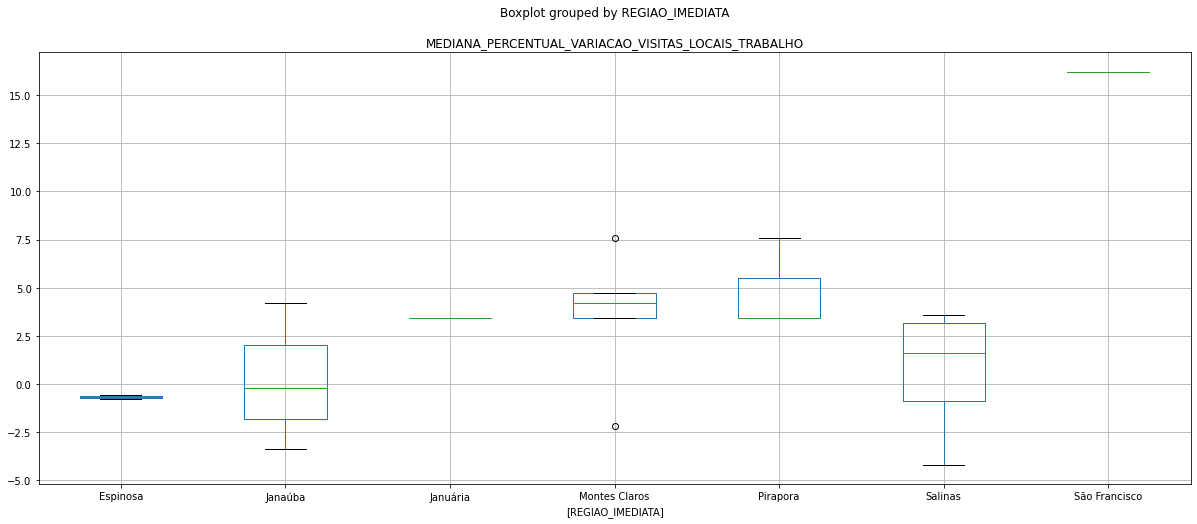

,CODIGO_MUNICIPIO_6,QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,QUARTILE_3_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS,REGIAO,SIGLA_ESTADO,REGIAO_INTERMEDIARIA,REGIAO_IMEDIATA
0,110001,NaN,23.20,NaN,Norte,RO,Ji-Paraná,Cacoal
1,110002,NaN,22.75,10.80,Norte,RO,Porto Velho,Ariquemes
2,110004,NaN,16.15,9.00,Norte,RO,Ji-Paraná,Cacoal
3,110005,NaN,12.00,NaN,Norte,RO,Ji-Paraná,Vilhena
4,110006,NaN,13.65,NaN,Norte,RO,Ji-Paraná,Vilhena
...,...,...,...,...,...,...,...,...
2303,522140,7.9,6.75,14.55,Centro-Oeste,GO,Goiânia,Goiânia
2304,522160,-35.0,13.00,10.95,Centro-Oeste,GO,Porangatu - Uruaçu,Uruaçu - Niquelândia
2305,522185,38.8,5.10,16.10,Centro-Oeste,GO,Luziânia - Águas Lindas de Goiás,Luziânia
2306,522200,NaN,6.80,NaN,Centro-Oeste,GO,Goiânia,Anápolis


,QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,QUARTILE_3_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS
count,710.000000,2285.000000,1091.000000
mean,-17.362705,4.945137,9.691789
std,32.264985,7.524165,4.494327
min,-100.000000,-55.000000,-71.000000
25%,-37.737500,0.400000,7.800000
50%,-21.900000,5.000000,10.000000
75%,-3.812500,9.500000,12.200000
max,179.400000,33.900000,19.600000


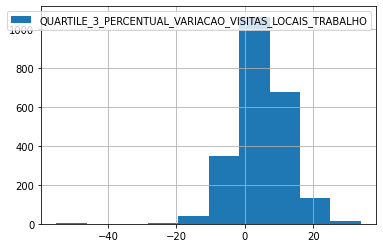

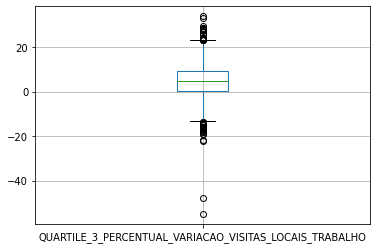

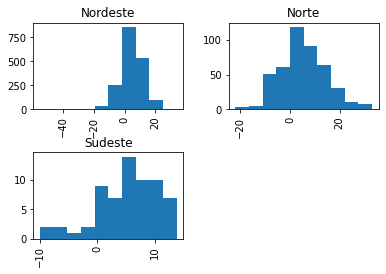

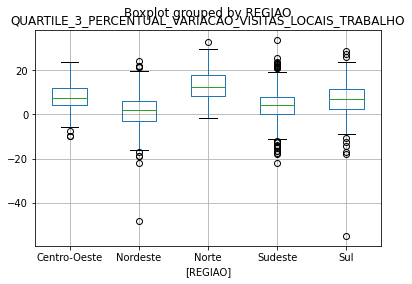

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


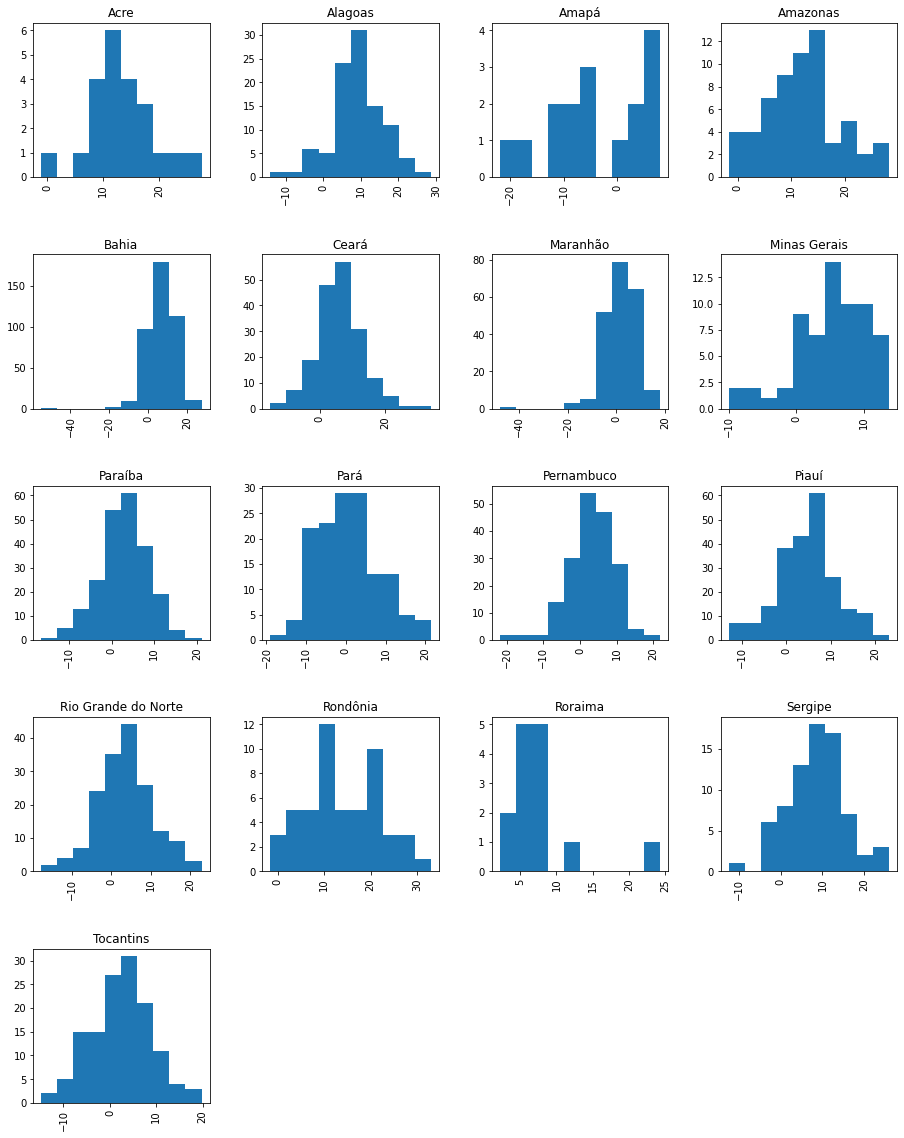

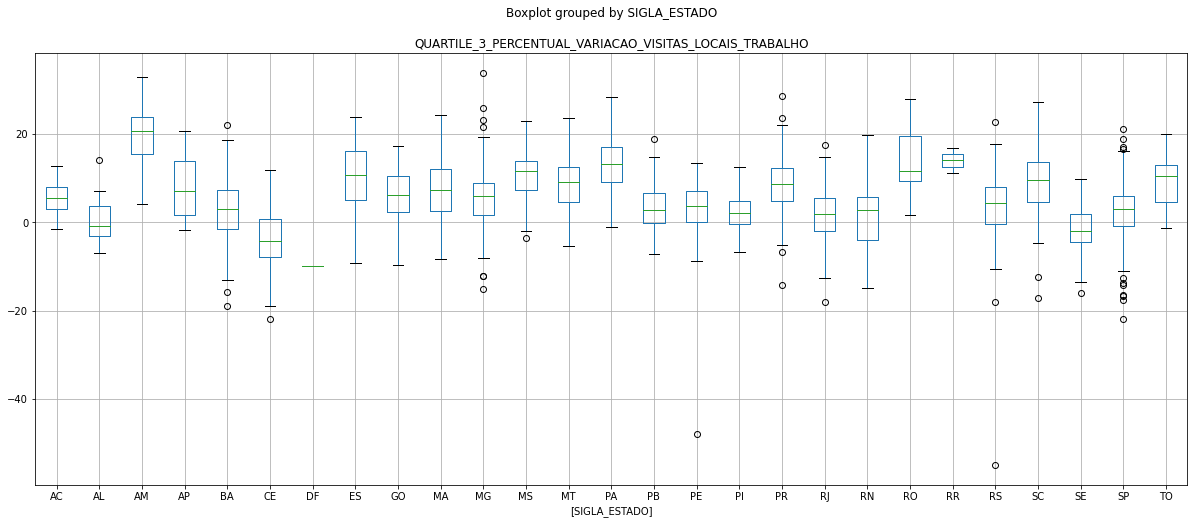

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


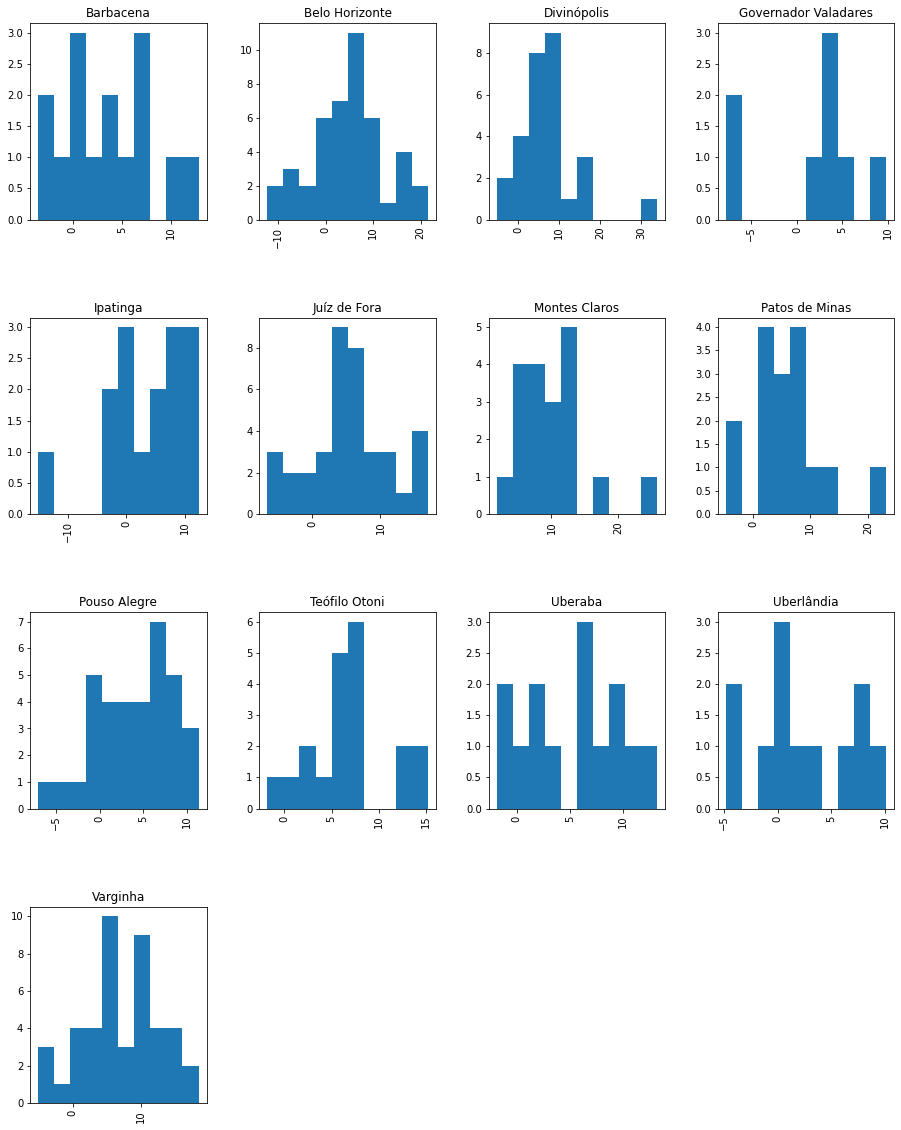

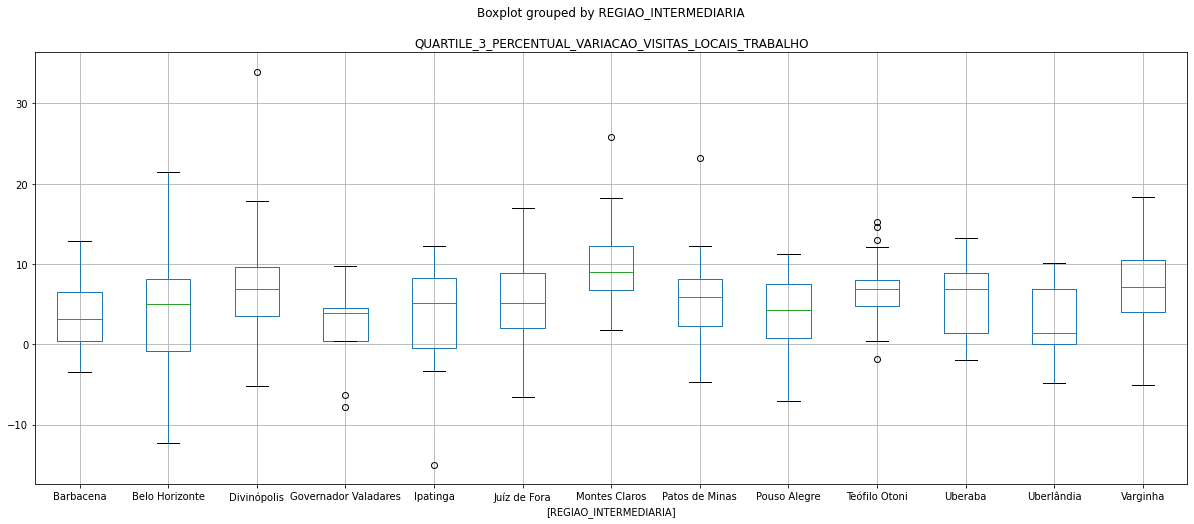

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


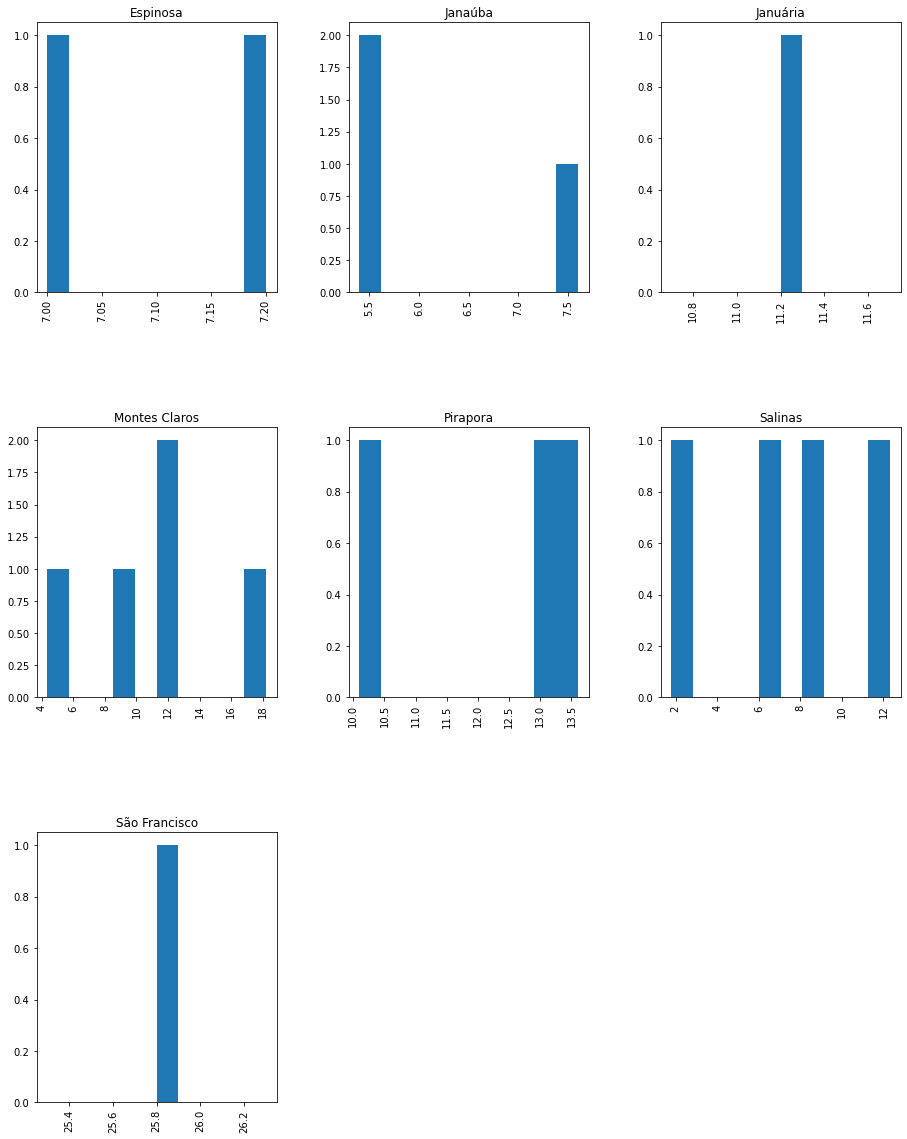

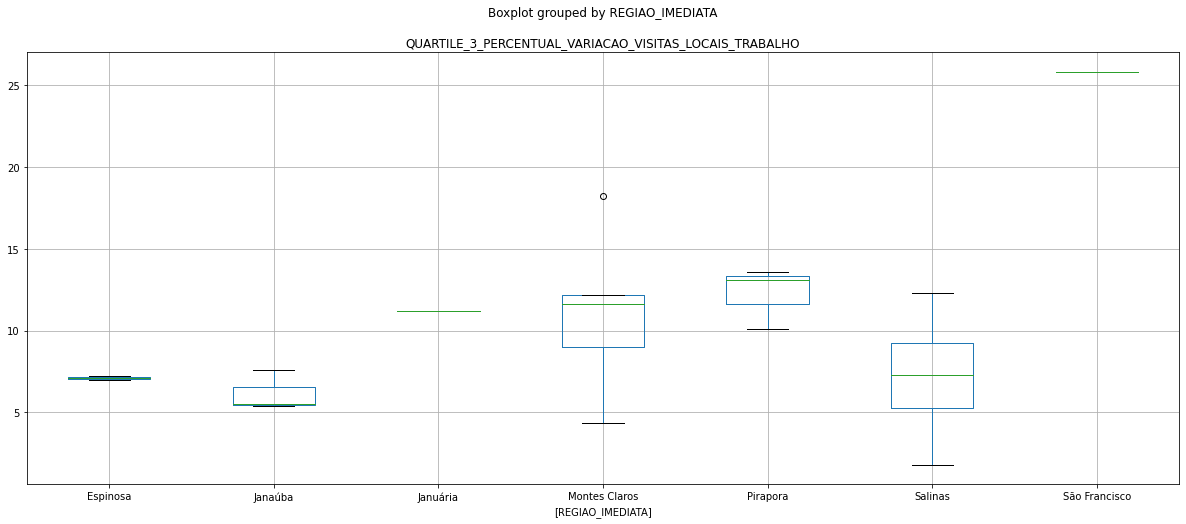

In [207]:
show_analisys_attribute(df_base, 'TAXA_OBITOS')

df_municipio = df_base[['CODIGO_MUNICIPIO_6', 'REGIAO', 'SIGLA_ESTADO', 'REGIAO_INTERMEDIARIA', 'REGIAO_IMEDIATA']]

df_mobilidade_media_visualizacao = pd.merge(df_mobilidade_media, df_municipio, how='left', on='CODIGO_MUNICIPIO_6')
show_analisys_attribute(df_mobilidade_media_visualizacao, 'MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')

df_mobilidade_mediana_visualizacao = pd.merge(df_mobilidade_mediana, df_municipio, how='left', on='CODIGO_MUNICIPIO_6')
show_analisys_attribute(df_mobilidade_mediana_visualizacao, 'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')

df_mobilidade_3_quartile_visualizacao = pd.merge(df_mobilidade_3_quartile, df_municipio, how='left', on='CODIGO_MUNICIPIO_6')
show_analisys_attribute(df_mobilidade_3_quartile_visualizacao, 'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')

,MUNICIPIO,CODIGO_MUNICIPIO_6,SIGLA_ESTADO,CODIGO_ESTADO,REGIAO,REGIAO_SAUDE,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,CASOS,OBITOS,...,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA
0,Alta Floresta D'Oeste,110001,RO,11,Norte,ZONA DA MATA,11005.0,0.0,4057.0,65,...,40.589951,3.247196,157.813728,120.146254,12.988784,36.482895,2.183835,127.561671,99.171813,11.433020
1,Ariquemes,110002,RO,11,Norte,VALE DO JAMARI,11001.0,0.0,22501.0,494,...,54.239894,11.958402,85.417156,71.323325,20.927203,60.373777,12.615416,153.988174,115.040580,28.634992
2,Cabixi,110003,RO,11,Norte,CONE SUL,11006.0,0.0,907.0,21,...,12.016722,0.000000,130.286567,111.312795,10.119345,36.482895,2.183835,127.561671,99.171813,11.433020
3,Cacoal,110004,RO,11,Norte,CAFE,11002.0,0.0,14507.0,302,...,40.589951,3.247196,157.813728,120.146254,12.988784,36.482895,2.183835,127.561671,99.171813,11.433020
4,Cerejeiras,110005,RO,11,Norte,CONE SUL,11006.0,0.0,2537.0,61,...,12.016722,0.000000,130.286567,111.312795,10.119345,36.482895,2.183835,127.561671,99.171813,11.433020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,Vianópolis,522200,GO,52,Centro-Oeste,CENTRO SUL,52002.0,0.0,974.0,33,...,86.453458,7.637806,173.719449,101.404056,13.488040,131.938404,17.916559,234.593248,118.243874,28.200988
5566,Vicentinópolis,522205,GO,52,Centro-Oeste,CENTRO SUL,52002.0,0.0,1377.0,24,...,56.862393,0.000000,65.840666,94.271862,5.985515,74.278132,11.778733,127.162239,85.335718,15.865232
5567,Vila Boa,522220,GO,52,Centro-Oeste,ENTORNO NORTE,52003.0,0.0,198.0,4,...,0.000000,0.000000,63.498111,71.435375,0.000000,30.847536,0.936958,78.632387,64.866314,2.810874
5568,Vila Propício,522230,GO,52,Centro-Oeste,SAO PATRICIO II,52018.0,0.0,391.0,7,...,123.333996,8.752735,140.043764,126.118958,18.699025,111.454539,4.404561,103.794433,104.560444,12.256169


,CODIGO_ESTADO,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,CASOS,OBITOS,POPULACAO_ESTIMADA,DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO,DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO,PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO,CODIGO_REGIAO_IMEDIATA,...,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA
count,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5.570000e+03,5.570000e+03,5570.000000,5570.000000,5570.000000,...,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000
mean,32.377738,32403.123698,0.069300,3714.094434,103.751885,3.772839e+04,1.176968e+04,920.600898,1.043896,323793.462657,...,50.343383,6.197581,141.237603,113.414440,15.886186,57.550806,8.066071,160.989005,120.728879,19.166481
std,9.833862,9837.224401,0.253986,19091.629993,765.152091,2.214581e+05,7.378126e+04,12945.799490,4.509078,98340.639166,...,39.156400,7.144393,79.544378,33.585401,12.407539,31.545535,5.968023,69.462012,25.410903,9.676284
min,11.000000,11001.000000,0.000000,10.000000,0.000000,7.810000e+02,3.190000e+02,0.000000,0.000000,110001.000000,...,0.000000,0.000000,22.013312,35.609769,0.000000,0.000000,0.000000,26.054637,42.183698,0.000000
25%,25.000000,25010.000000,0.000000,450.000000,9.000000,5.446500e+03,1.698500e+03,0.000000,0.000000,250009.000000,...,18.515090,0.000000,75.856192,88.704539,5.544774,29.584962,3.673233,101.476569,102.276793,11.460727
50%,31.000000,31059.000000,0.000000,960.000000,20.000000,1.163100e+04,3.432500e+03,0.000000,0.000000,310039.000000,...,45.158062,3.764139,123.168115,106.120886,14.219747,57.716365,6.780069,165.082655,120.012020,19.725571
75%,41.000000,41015.000000,0.000000,2355.750000,51.000000,2.549050e+04,7.373000e+03,0.000000,0.000000,410019.000000,...,74.347123,9.364962,186.799997,133.714235,23.591634,79.503122,11.428339,203.706986,134.778301,25.414597
max,53.000000,53001.000000,1.000000,938981.000000,37030.000000,1.225202e+07,4.104611e+06,529921.000000,73.993700,530001.000000,...,257.652879,39.664799,490.043880,293.034134,79.658955,136.260269,39.664799,338.145730,226.665023,55.252137


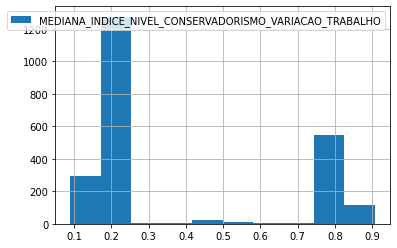

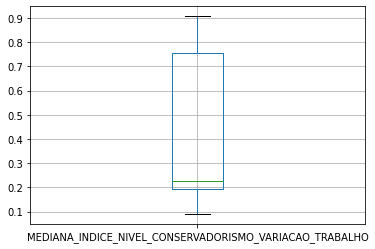

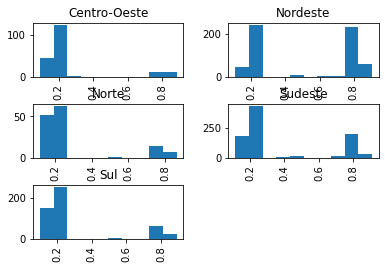

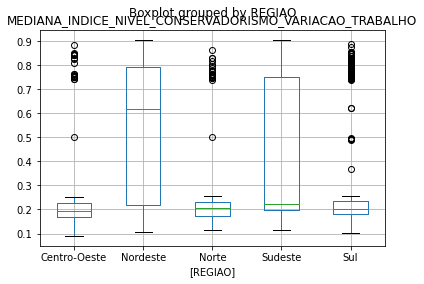

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


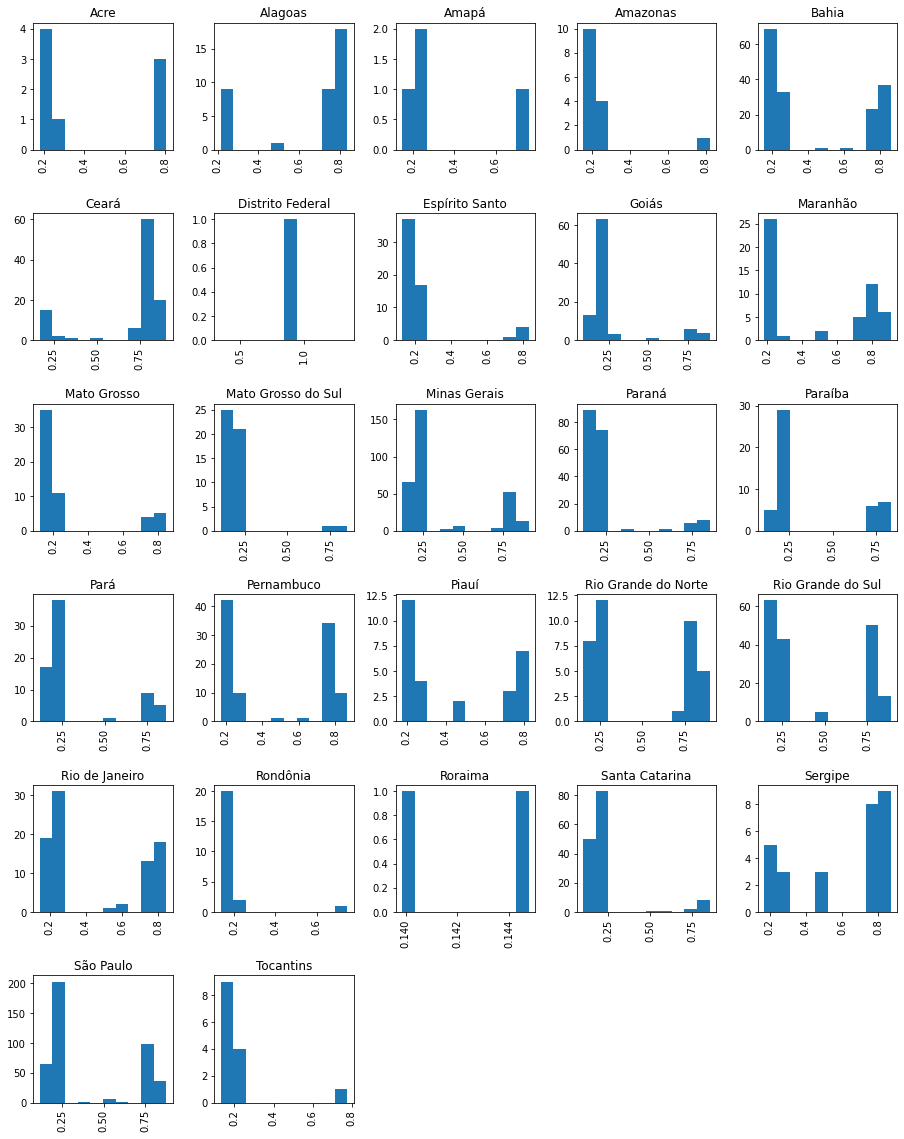

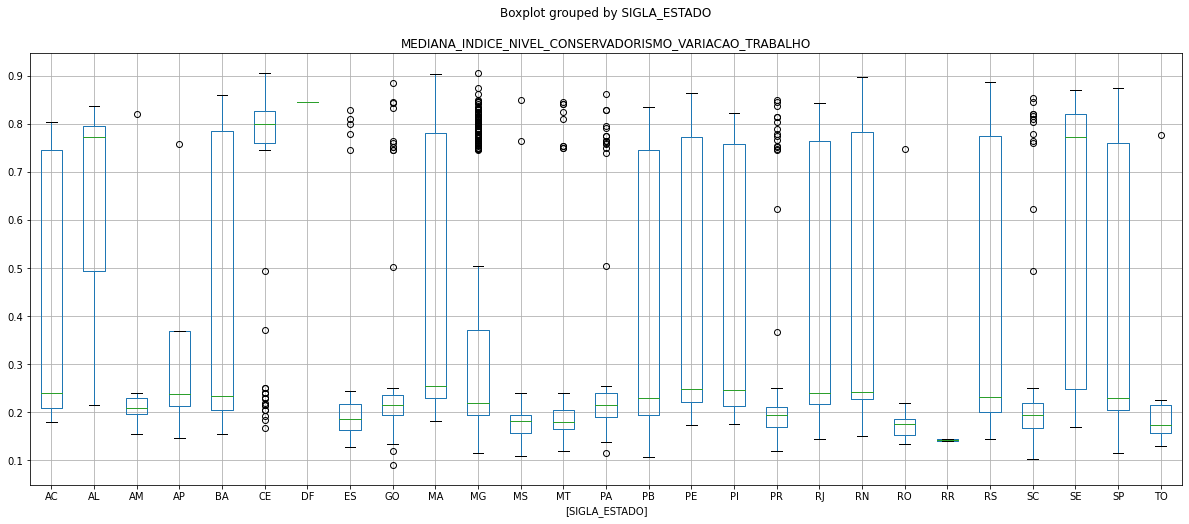

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


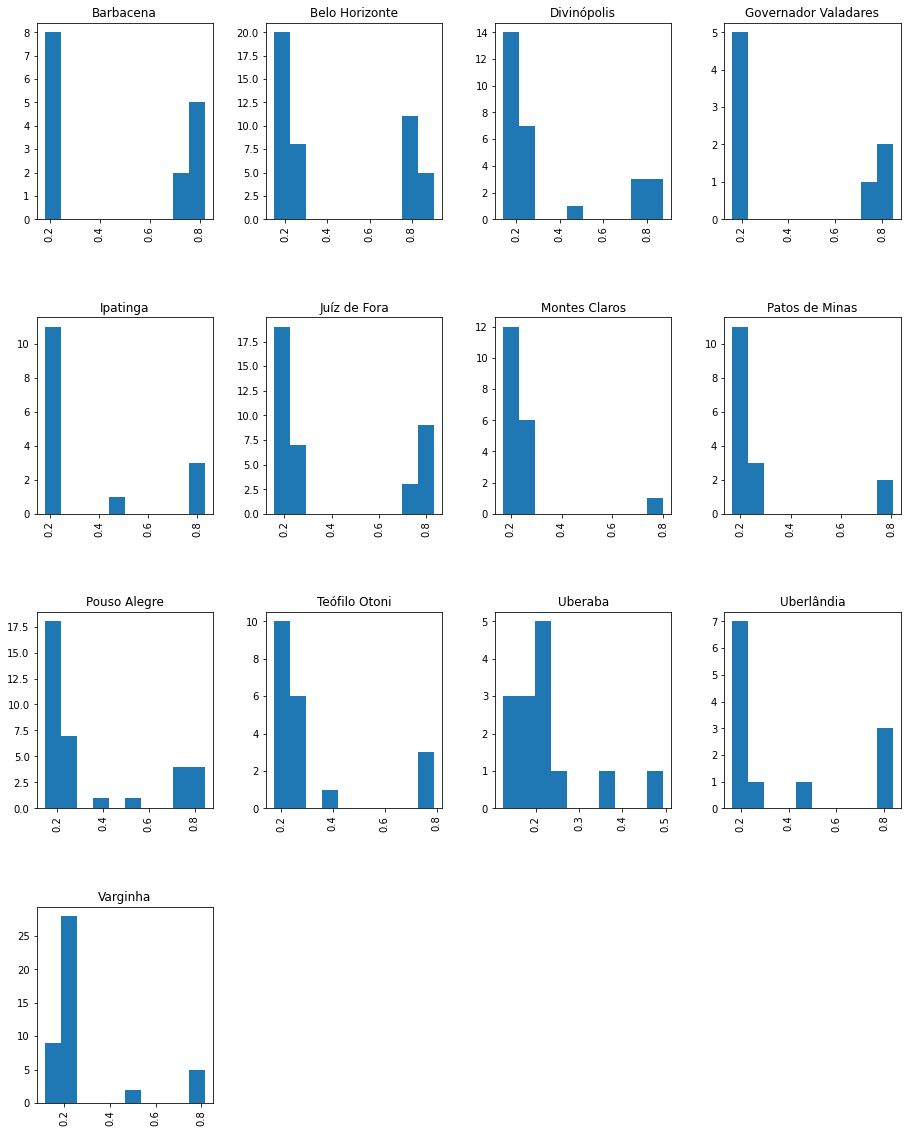

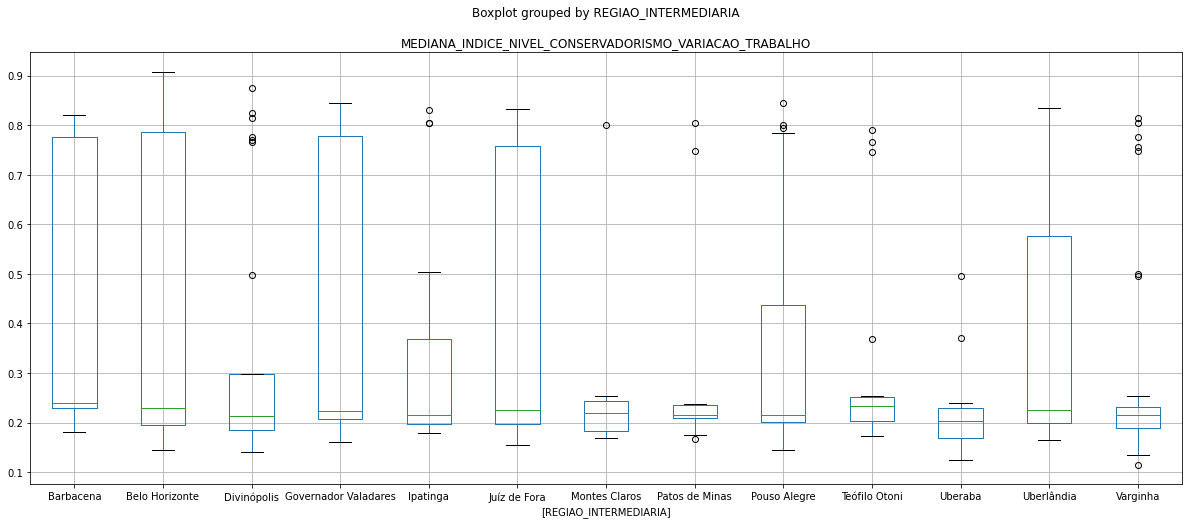

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


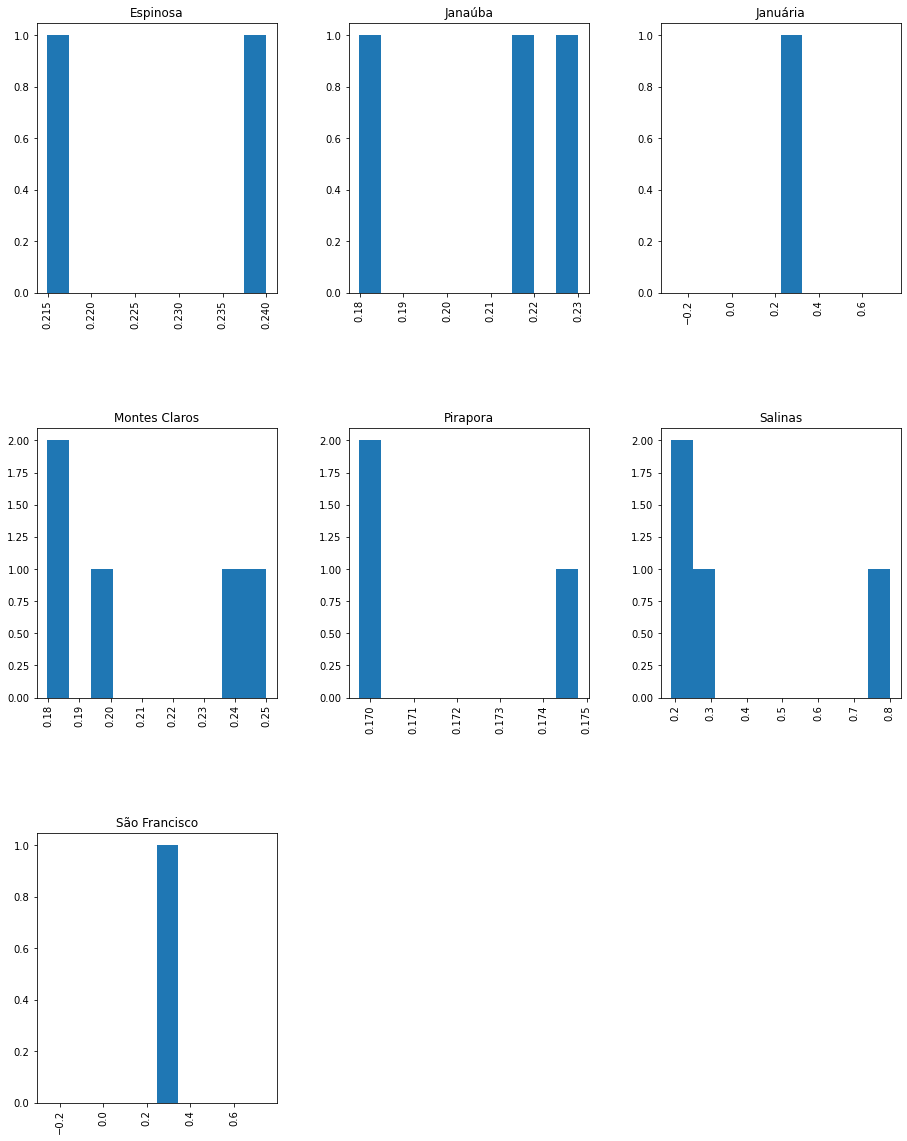

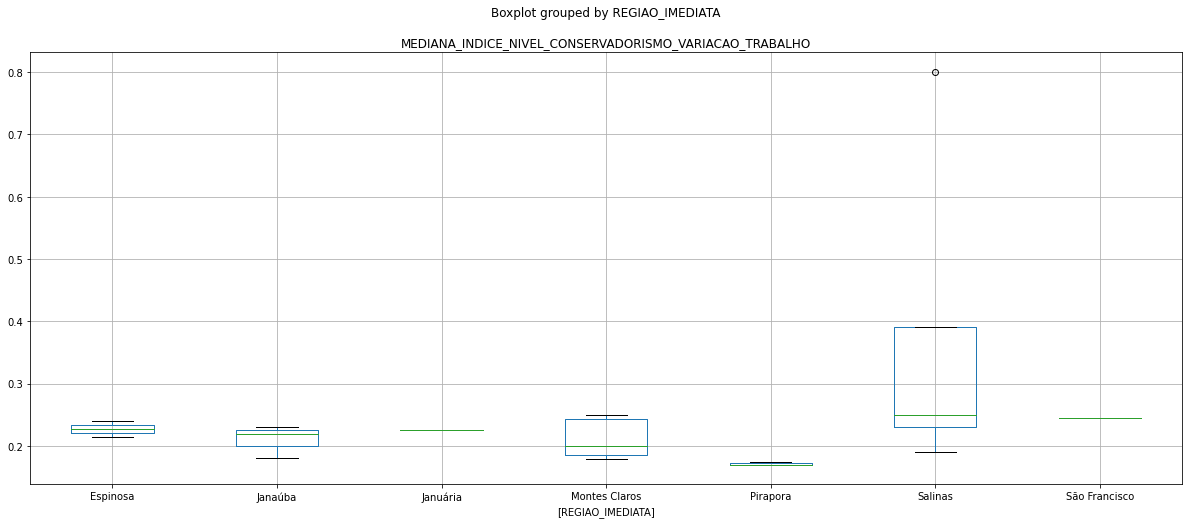

In [208]:
show_analisys_attribute(df_base, 'MEDIANA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO')

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/home/helder/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/helder/.local/lib/python3.8/site-packages/matplotlib/ticker.py:652: UserWarning: Warning: converting a masked element to nan.
  s = self.format % xp


Text(0, 0.5, 'Taxa óbitos')

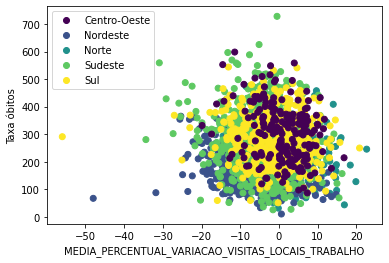

In [209]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

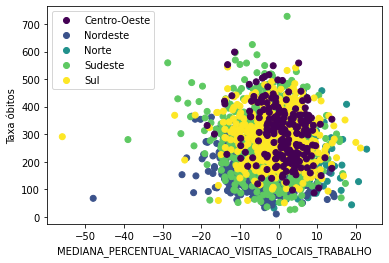

In [210]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

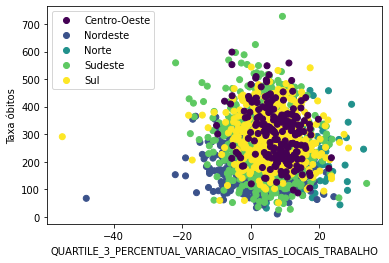

In [211]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base['QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO'], y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

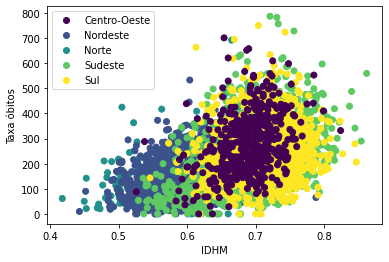

In [212]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.IDHM, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('IDHM')
plt.ylabel('Taxa óbitos')


Text(0, 0.5, 'Taxa óbitos')

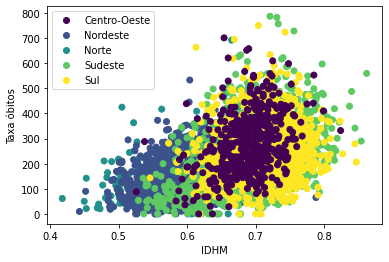

In [213]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.IDHM, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('IDHM')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

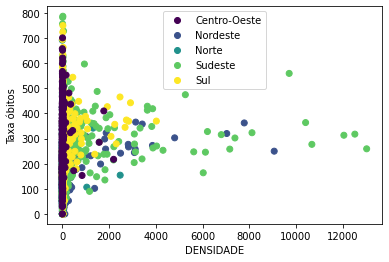

In [214]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.DENSIDADE, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('DENSIDADE')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

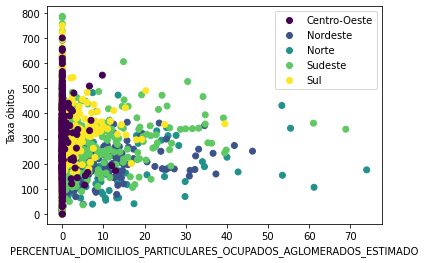

In [215]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

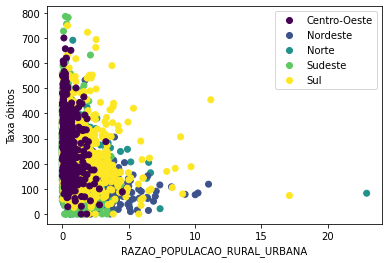

In [216]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.RAZAO_POPULACAO_RURAL_URBANA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('RAZAO_POPULACAO_RURAL_URBANA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

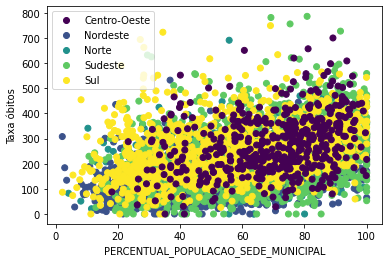

In [217]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_POPULACAO_SEDE_MUNICIPAL, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_POPULACAO_SEDE_MUNICIPAL')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

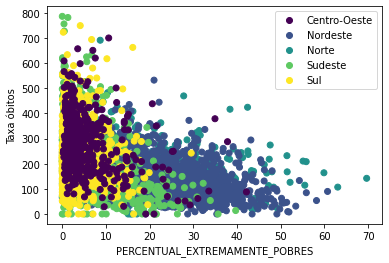

In [218]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_EXTREMAMENTE_POBRES, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_EXTREMAMENTE_POBRES')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

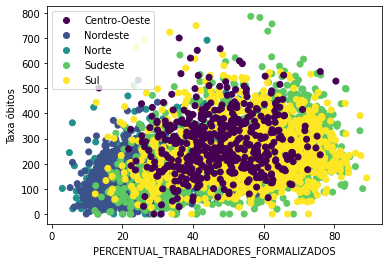

In [219]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_TRABALHADORES_FORMALIZADOS, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_TRABALHADORES_FORMALIZADOS')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

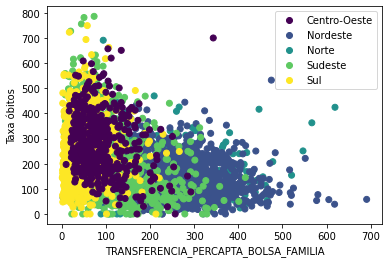

In [220]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

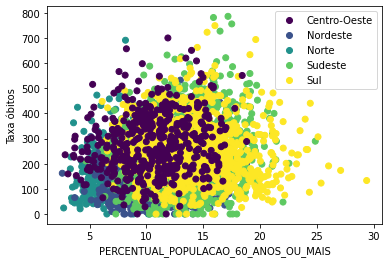

In [221]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

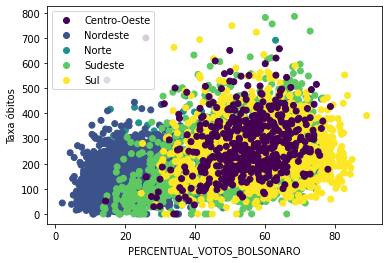

In [222]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_VOTOS_BOLSONARO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_VOTOS_BOLSONARO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

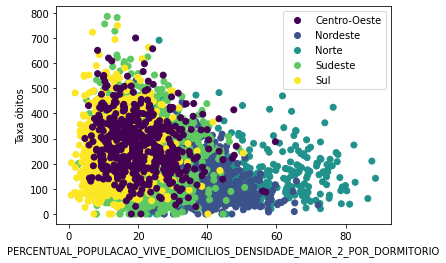

In [223]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_DENSIDADE_MAIOR_2_POR_DORMITORIO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_DENSIDADE_MAIOR_2_POR_DORMITORIO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

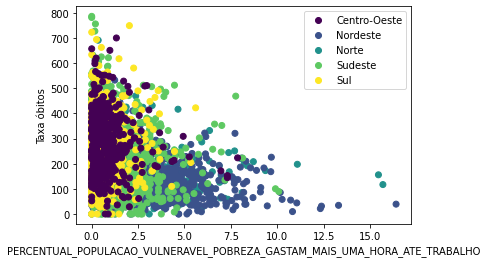

In [224]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_POPULACAO_VULNERAVEL_POBREZA_GASTAM_MAIS_UMA_HORA_ATE_TRABALHO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_POPULACAO_VULNERAVEL_POBREZA_GASTAM_MAIS_UMA_HORA_ATE_TRABALHO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

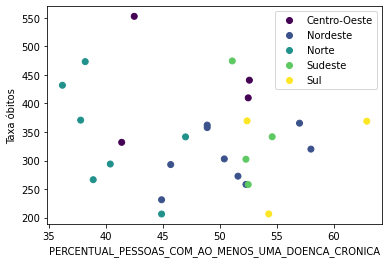

In [225]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_PESSOAS_COM_AO_MENOS_UMA_DOENCA_CRONICA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_PESSOAS_COM_AO_MENOS_UMA_DOENCA_CRONICA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

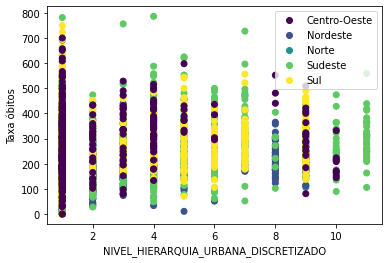

In [226]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('NIVEL_HIERARQUIA_URBANA_DISCRETIZADO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

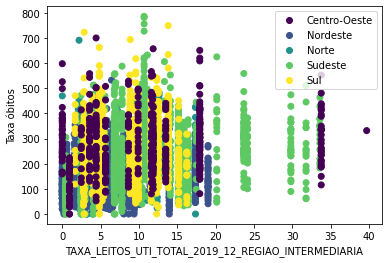

In [227]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

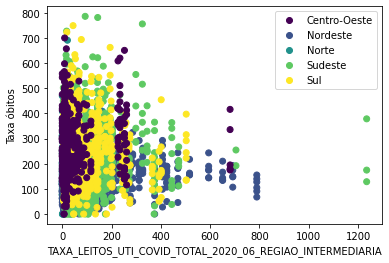

In [228]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

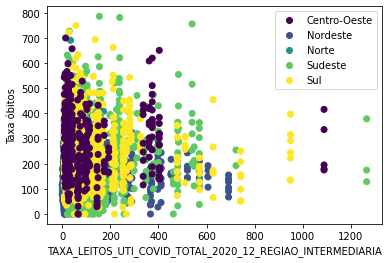

In [229]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

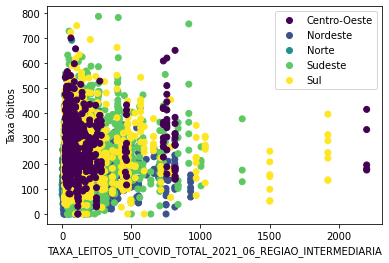

In [230]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA')
plt.ylabel('Taxa óbitos')

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


array([[<AxesSubplot:title={'center':'Capital Regional A'}>,
        <AxesSubplot:title={'center':'Capital Regional B'}>,
        <AxesSubplot:title={'center':'Capital Regional C'}>],
       [<AxesSubplot:title={'center':'Centro Local'}>,
        <AxesSubplot:title={'center':'Centro Sub-Regional A'}>,
        <AxesSubplot:title={'center':'Centro Sub-Regional B'}>],
       [<AxesSubplot:title={'center':'Centro de Zona A'}>,
        <AxesSubplot:title={'center':'Centro de Zona B'}>,
        <AxesSubplot:title={'center':'Grande Metrópole Nacional'}>],
       [<AxesSubplot:title={'center':'Metrópole'}>,
        <AxesSubplot:title={'center':'Metrópole Nacional'}>,
        <AxesSubplot:>]], dtype=object)

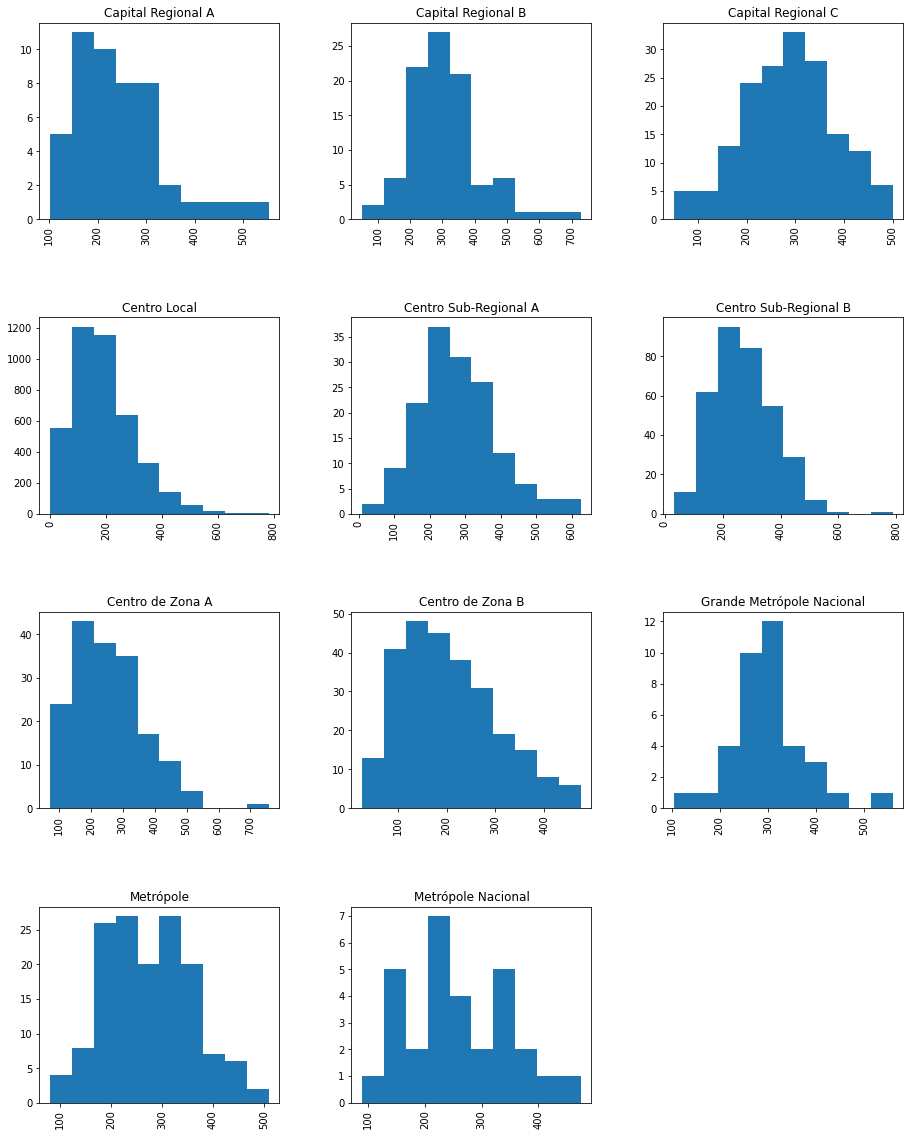

In [231]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_base.TAXA_OBITOS.hist(by=df_base.HIERARQUIA_URBANA, ax=ax)

<AxesSubplot:title={'center':'TAXA_OBITOS'}, xlabel='[HIERARQUIA_URBANA]'>

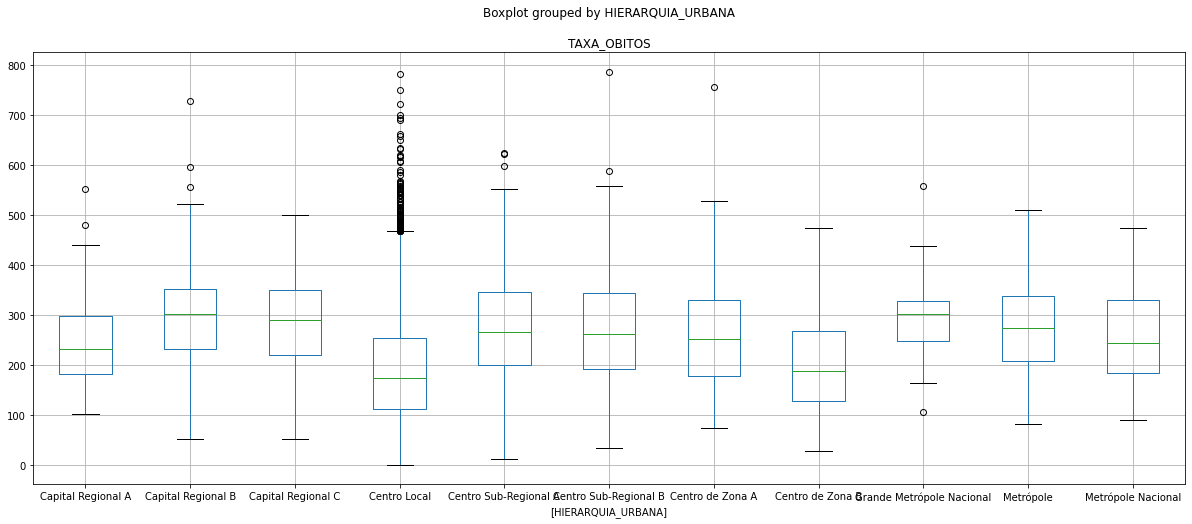

In [232]:
df_base[["TAXA_OBITOS",'HIERARQUIA_URBANA']].boxplot(by='HIERARQUIA_URBANA', figsize=(20,8))

<AxesSubplot:title={'center':'TAXA_OBITOS'}, xlabel='[NIVEL_HIERARQUIA_URBANA_DISCRETIZADO]'>

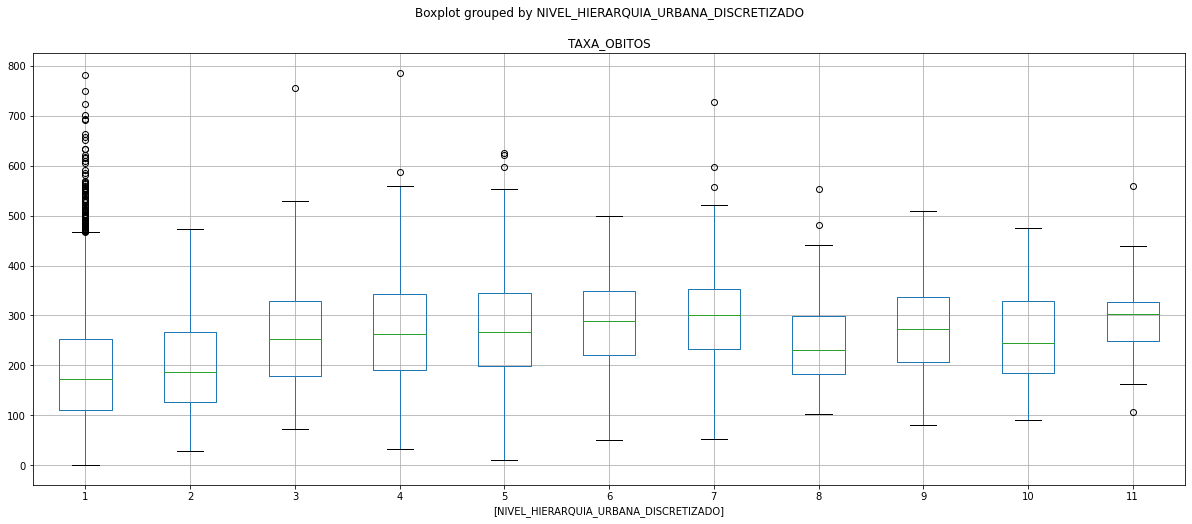

In [233]:
df_base[["TAXA_OBITOS",'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO']].boxplot(by='NIVEL_HIERARQUIA_URBANA_DISCRETIZADO', figsize=(20,8))

In [234]:
df_base[df_base.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO >= 4].sum().POPULACAO_ESTIMADA / df_base.sum().POPULACAO_ESTIMADA * 100

69.86338690096284

In [235]:
df_base.groupby('HIERARQUIA_URBANA').count().POPULACAO_ESTIMADA

HIERARQUIA_URBANA
Capital Regional A             48
Capital Regional B             92
Capital Regional C            168
Centro Local                 4115
Centro Sub-Regional A         151
Centro Sub-Regional B         345
Centro de Zona A              173
Centro de Zona B              264
Grande Metrópole Nacional      37
Metrópole                     147
Metrópole Nacional             30
Name: POPULACAO_ESTIMADA, dtype: int64

In [236]:
df_hierarquia_urbana_brasil = df_base.groupby('HIERARQUIA_URBANA').sum()[['OBITOS','POPULACAO_ESTIMADA']]
df_hierarquia_urbana_brasil['TAXA_OBITOS'] = df_hierarquia_urbana_brasil.OBITOS / df_hierarquia_urbana_brasil.POPULACAO_ESTIMADA * 100000
print(df_hierarquia_urbana_brasil)

                           OBITOS  POPULACAO_ESTIMADA  TAXA_OBITOS
HIERARQUIA_URBANA                                                 
Capital Regional A          31941             9918266   322.042180
Capital Regional B          40084            12955894   309.388144
Capital Regional C          61232            19542042   313.334707
Centro Local                94015            51038490   184.204117
Centro Sub-Regional A       33225            11555268   287.531194
Centro Sub-Regional B       49855            18260630   273.019058
Centro de Zona A            15291             6150831   248.600555
Centro de Zona B            12014             6141905   195.607063
Grande Metrópole Nacional   68029            21673440   313.881876
Metrópole                  113059            36142341   312.815930
Metrópole Nacional          59153            16768018   352.772761


In [237]:
df_hierarquia_urbana_brasil_mean = df_base.groupby('HIERARQUIA_URBANA').mean()[['TAXA_OBITOS']]
df_hierarquia_urbana_brasil_mean.columns = ['TAXA_OBITOS_MEDIA']
df_hierarquia_urbana_brasil_std = df_base.groupby('HIERARQUIA_URBANA').std()[['TAXA_OBITOS']]
df_hierarquia_urbana_brasil_std.columns = ['TAXA_OBITOS_DESVIO_PADRAO']
df_hierarquia_urbana_brasil = pd.merge(df_hierarquia_urbana_brasil_mean, df_hierarquia_urbana_brasil_std, left_index=True, right_index=True)
print(df_hierarquia_urbana_brasil)

                           TAXA_OBITOS_MEDIA  TAXA_OBITOS_DESVIO_PADRAO
HIERARQUIA_URBANA                                                      
Capital Regional A                248.050284                  92.029852
Capital Regional B                308.448243                 105.879825
Capital Regional C                285.718193                  95.080357
Centro Local                      192.163479                 110.954311
Centro Sub-Regional A             278.247784                 111.796648
Centro Sub-Regional B             272.734771                 107.954469
Centro de Zona A                  258.365390                 109.751624
Centro de Zona B                  204.211244                  97.514632
Grande Metrópole Nacional         300.059889                  81.235885
Metrópole                         276.100087                  85.448548
Metrópole Nacional                255.921555                  90.440288


In [238]:
df_base.groupby('HIERARQUIA_URBANA').count()[['TAXA_OBITOS', 'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE', 'MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']]

,TAXA_OBITOS,MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS
HIERARQUIA_URBANA,,,,
Capital Regional A,48,39,19,31
Capital Regional B,92,77,46,58
Capital Regional C,168,138,85,110
Centro Local,4115,1038,113,186
Centro Sub-Regional A,151,130,85,107
Centro Sub-Regional B,345,301,148,266
Centro de Zona A,173,156,43,122
Centro de Zona B,264,197,18,32
Grande Metrópole Nacional,37,37,36,35


In [239]:
df_base.groupby('CAPITAL').count()[['TAXA_OBITOS', 'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE', 'MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']]

,TAXA_OBITOS,MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS
CAPITAL,,,,
0,5543,2258,683,1064
1,27,27,27,27


In [240]:
df_base.groupby('HIERARQUIA_URBANA').mean()[['TAXA_OBITOS', 'POPULACAO_ESTIMADA', 'IDHM']]

,TAXA_OBITOS,POPULACAO_ESTIMADA,IDHM
HIERARQUIA_URBANA,,,
Capital Regional A,248.050284,206630.541667,0.678125
Capital Regional B,308.448243,140824.934783,0.746152
Capital Regional C,285.718193,116321.678571,0.735500
Centro Local,192.163479,12403.035237,0.641924
Centro Sub-Regional A,278.247784,76524.953642,0.729106
Centro Sub-Regional B,272.734771,52929.362319,0.709928
Centro de Zona A,258.365390,35553.936416,0.701902
Centro de Zona B,204.211244,23264.791667,0.656098
Grande Metrópole Nacional,300.059889,585768.648649,0.762000


In [241]:
#Será considerado a mobilidade apenas de municípios de maior centralidade (Hierarquia urbana >= Centro Sub-regionais)
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO <= 3,
            ['MEDIA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
             'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
             'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
             'MEDIA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
             'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
             'QUARTILE_3_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
             'MEDIA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS',
             'MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS',
             'QUARTILE_3_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS',
             'MEDIA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO',
             'MEDIANA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO',
             'QUARTILE_3_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO']] = None

In [242]:
# df_base = df_base_general

In [273]:
df = df_base[
    [ 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO', 'REGIAO_METROPOLITANA', 'CAPITAL', 'POPULACAO_ESTIMADA',
      'PERCENTUAL_POPULACAO_0_A_5_ANOS',
      'PERCENTUAL_POPULACAO_6_A_14_ANOS', 'PERCENTUAL_POPULACAO_15_A_24_ANOS', 'PERCENTUAL_POPULACAO_25_A_39_ANOS',
      'PERCENTUAL_POPULACAO_40_A_59_ANOS', 'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS', 'DENSIDADE',
      'RAZAO_POPULCAO_DOMICILIOS_ESTIMADA', 'PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO',
      'DENSIDADE_DEMOGRAFICA_AGLOMERADOS', 'DENSIDADE_DOMICILIOS_AGLOMERADOS','TAXA_FECUNDIDADE',
      'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_BANHEIRO_AGUA',
      'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_DENSIDADE_MAIOR_2_POR_DORMITORIO','RAZAO_POPULACAO_MASCULINA_FEMININA',
     'RAZAO_POPULACAO_RURAL_URBANA', 'PERCENTUAL_POPULACAO_URBANA', 'PERCENTUAL_POPULACAO_SEDE_MUNICIPAL',
     'DENSIDADE_DOMICILIOS', 'PERCENTUAL_DOMICILIOS_AGLOMERADOS', 'PERCENTUAL_POPULACAO_AGLOMERADOS',
     'DENSIDADE_DOMICILIOS_ESTIMADA', 'IDHM', 'IDHM_EDUCACAO', 'IDHM_LONGEVIDADE', 'IDHM_RENDA', 'GINI',
     'PERCENTUAL_EXTREMAMENTE_POBRES', 'PERCENTUAL_POBRES',
     'PERCENTUAL_VULNERAVEIS_POBREZA', 'RAZAO_10_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES',
     'RAZAO_20_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES', 'RENDA_PER_CAPTA_MEDIA_EXTREMAMENTE_POBRES',
     'RENDA_PER_CAPTA_MEDIA_POBRES', 'RENDA_PER_CAPTA_MEDIA_VULNERAVEIS_POBREZA', 'THEIL', 'RAZAO_DEPENDENCIA',
     'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA', 'PERCENTUAL_TRABALHADORES_CONTA_PROPRIA', 'PERCENTUAL_OCUPADOS_AGROPECUARIA', 'PERCENTUAL_OCUPADOS_COMERCIO',
     'PERCENTUAL_OCUPADOS_CONSTRUCAO', 'PERCENTUAL_OCUPADOS_MINERACAO', 'PERCENTUAL_OCUPADOS_SERVICO',
     'PERCENTUAL_OCUPADOS_SERVICOS_INDUSTRIAIS_UTILIDADE_PUBLICA', 'PERCENTUAL_OCUPADOS_INDUSTRIA',
     'PERCENTUAL_TRABALHADORES_FORMALIZADOS', 'PERCENTUAL_OCUPADOS_SEM_RENDA', 'TAXA_ATIVIDADE', 'TAXA_DESOCUPACAO',
     'PERCENTUAL_TRABALHADORES_PUBLICOS', 'PERCENTUAL_POPULACAO_VULNERAVEL_POBREZA_GASTAM_MAIS_UMA_HORA_ATE_TRABALHO',
     'PERCENTUAL_INTERNACAOES_DOENCAS_SANEAMENTO_INADEQUADO', 'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE',
     'PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA', 'PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE', 'PERCENTUAL_AVC', 'PERCENTUAL_COLESTEROL_ALTO',
     'PERCENTUAL_DOENCA_CORACAO', 'PERCENTUAL_PESSOAS_COM_AO_MENOS_UMA_DOENCA_CRONICA', 'PERCENTUAL_HIPERTENSAO',
     'PERCENTUAL_AUTO_AVALIACAO_POSITIVA_SAUDE', 'PERCENTUAL_ASMA', 'PERCENTUAL_CANCER',
     'PERCENTUAL_INSUFICIENCIA_RENAL_CRONICA', 'PERCENTUAL_DIABETES',  'TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
      'TAXA_LEITOS_INTERNACAO_TOTAL_2020_06_REGIAO_INTERMEDIARIA',  'TAXA_LEITOS_INTERNACAO_TOTAL_2020_12_REGIAO_INTERMEDIARIA',
      'TAXA_LEITOS_INTERNACAO_TOTAL_2021_06_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_TOTAL_2020_06_REGIAO_INTERMEDIARIA',
      'TAXA_LEITOS_UTI_TOTAL_2020_12_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_TOTAL_2021_06_REGIAO_INTERMEDIARIA', 'TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
      'TAXA_MEDICOS_TOTAL_2020_06_REGIAO_INTERMEDIARIA', 'TAXA_MEDICOS_TOTAL_2020_12_REGIAO_INTERMEDIARIA', 'TAXA_MEDICOS_TOTAL_2021_06_REGIAO_INTERMEDIARIA',
      'TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA', 'TAXA_ENFERMEIROS_TOTAL_2020_06_REGIAO_INTERMEDIARIA', 'TAXA_ENFERMEIROS_TOTAL_2020_12_REGIAO_INTERMEDIARIA',
       'TAXA_ENFERMEIROS_TOTAL_2021_06_REGIAO_INTERMEDIARIA', 'TAXA_VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA',
      'TAXA_VENTILADORES_RESPIRADORES_EM_USO_2020_06_REGIAO_INTERMEDIARIA', 'TAXA_VENTILADORES_RESPIRADORES_EM_USO_2020_12_REGIAO_INTERMEDIARIA',
      'TAXA_VENTILADORES_RESPIRADORES_EM_USO_2021_06_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA',
      'TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA',
      'MEDIA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO', 'MEDIANA_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO',
      'QUARTILE_3_INDICE_NIVEL_CONSERVADORISMO_VARIACAO_TRABALHO', 'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO',
      'MEDIANA_PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE', 'MEDIANA_PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS',
      'PERCENTUAL_VOTOS_BOLSONARO', 'PERCENTUAL_VOTOS_HADDAD','TAXA_CASOS', 'TAXA_LETALIDADE', 'TAXA_OBITOS']]


In [274]:
df_correlation = df.corr(method="spearman")

df_correlation_pvalue = pd.DataFrame(columns=['correlation_pearson', 'pvalue_pearson', 'correlation_spearman', 'pvalue_spearman'])
for column in df:
    if pd.api.types.is_numeric_dtype(df[column]) and column != 'TAXA_OBITOS':
        has_null_values = np.logical_or(df.TAXA_OBITOS.isnull(), df[column].isnull())
        correlation_pearson, pvalue_pearson = stats.pearsonr(df[~has_null_values].TAXA_OBITOS, df[~has_null_values][column])
        correlation_spearman, pvalue_spearman = stats.spearmanr(df[~has_null_values].TAXA_OBITOS, df[~has_null_values][column])
        df_correlation_pvalue.loc[column] = [round(correlation_pearson, 4), round(pvalue_pearson, 4),
                                             round(correlation_spearman, 4), round(pvalue_spearman, 4)]

#### Removing outliers

In [245]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

#### Análsie geral: considerando todos os municípios ignorando dados sobre mobilidade, estrutura de saúde prévia e preferência política

In [428]:
df_antecedent = df_base[
    ['PERCENTUAL_POPULACAO_0_A_5_ANOS',
      'PERCENTUAL_POPULACAO_6_A_14_ANOS',
      'PERCENTUAL_POPULACAO_15_A_24_ANOS',
      'PERCENTUAL_POPULACAO_25_A_39_ANOS',
      'PERCENTUAL_POPULACAO_40_A_59_ANOS',
      'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS',
      'TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
      'DENSIDADE',
      'RAZAO_POPULCAO_DOMICILIOS_ESTIMADA',
      'PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO',
      'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_BANHEIRO_AGUA',
      'PERCENTUAL_POPULACAO_URBANA',
      'IDHM_RENDA',
      'RAZAO_20_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES',
      'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA',
      'PERCENTUAL_OCUPADOS_AGROPECUARIA',
      'PERCENTUAL_OCUPADOS_COMERCIO',
     'PERCENTUAL_OCUPADOS_SERVICO',
     'PERCENTUAL_OCUPADOS_INDUSTRIA',
     'PERCENTUAL_TRABALHADORES_FORMALIZADOS',
      'PERCENTUAL_OCUPADOS_SEM_RENDA',
      'TAXA_ATIVIDADE',
     'PERCENTUAL_INTERNACAOES_DOENCAS_SANEAMENTO_INADEQUADO',
      'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE',
      'PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE']]

df_base_antecedent = df_base.copy()
df_null = df_antecedent.isnull().any(axis=1)
df_base_antecedent = df_base_antecedent[df_null == False]
df_antecedent = df_antecedent[df_null == False]

df_consequent = df_base_antecedent[['TAXA_OBITOS', 'TAXA_CASOS', 'TAXA_LETALIDADE']]

#### Normalizing data

In [429]:
scaler_antecedents = preprocessing.MinMaxScaler()
antecedents_normalized = scaler_antecedents.fit_transform(df_antecedent.values)
df_antecedents_normalized = pd.DataFrame(antecedents_normalized, columns=df_antecedent.columns)

scaler_concequents = preprocessing.MinMaxScaler()
concequents_normalized = scaler_concequents.fit_transform(df_consequent.values)
df_concequents_normalized = pd.DataFrame(concequents_normalized, columns=df_consequent.columns)

#### Executing fcmenas

In [382]:
m = 2
epsilon = 10 ** (-4)

def plot_clusters(centers, u, x_not_normalized, y_not_normalized, df_not_normalized, scaler):
    cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization
    fig, ax = plt.subplots()

    for j in range(len(centers)):
        ax.plot(x_not_normalized.values[cluster_membership == j],
                y_not_normalized.values[cluster_membership == j], '.', label="Cluster " + str(j))
        ax.set_xlabel(x_not_normalized.name)
        ax.set_ylabel(y_not_normalized.name)
    ax.legend()

    # centers_not_normalized = scaler.inverse_transform(centers)
    # xi = df_not_normalized.columns.get_loc(x_not_normalized.name)
    # yi = df_not_normalized.columns.get_loc(y_not_normalized.name)
    # for pt in centers_not_normalized:
    #     ax.plot(pt[xi], pt[yi], 'rs')

    plt.show()


def describe_clusters(centers, u, df_not_normalized):
    cluster_membership = np.argmax(u, axis=0)
    for j in range(len(centers)):
        print("===================Cluster {0}==================".format(j))
        for column  in df_not_normalized.columns:
            print(df_not_normalized[cluster_membership == j][column].describe())
            print("\n")


def show_results(ra, centers, u, fpc, df_not_normalized, scaler, df_analysis):
    if ra is not None:
        print('RA = {0} - Subtractive Centers = {1}; FPC = {2:.2f}'.format(ra, len(centers), fpc))
    else:
        print('Centers = {0}; FPC = {1:.2f}'.format(len(centers), fpc))
    attributes = df_not_normalized.columns

    # for i in range(len(attributes) - 1):
    #     for j in range(i + 1, len(attributes)):
    #         plot_clusters(centers, u, df_not_normalized[attributes[i]], df_not_normalized[attributes[j]],
    #                       df_not_normalized, scaler)
    j = randrange(len(attributes))
    plot_clusters(centers, u, df_analysis['TAXA_OBITOS'], df_not_normalized[attributes[j]], df_not_normalized,
                  scaler)

    print("Describing results")
    describe_clusters(centers, u, df_analysis)

    print("Describing clusters")
    describe_clusters(centers, u, df_not_normalized)

In [430]:
df_analysis = df_base_antecedent[['TAXA_OBITOS']]

In [431]:
centers_2, u_2, u0, d, jm, p, fpc_2 = cluster.cmeans(
    df_antecedents_normalized.values.T, c=2, m=m, error=epsilon, maxiter=1000, init=None)

Centers = 2; FPC = 0.67


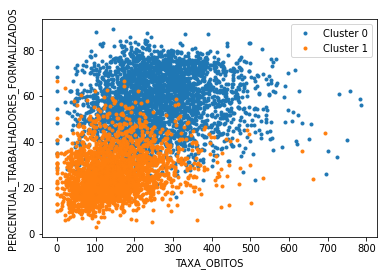

Describing results
===================Cluster 0==================
count    3081.000000
mean      260.140668
std       111.117569
min         0.000000
25%       180.427951
50%       250.376608
75%       328.474646
max       786.672837
Name: TAXA_OBITOS, dtype: float64


===================Cluster 1==================
count    2484.000000
mean      149.068120
std        83.316651
min         0.000000
25%        89.246662
50%       137.657529
75%       192.260369
max       691.562932
Name: TAXA_OBITOS, dtype: float64


Describing clusters
===================Cluster 0==================
count    3081.000000
mean        7.921136
std         1.350441
min         2.810000
25%         7.050000
50%         7.820000
75%         8.740000
max        12.970000
Name: PERCENTUAL_POPULACAO_0_A_5_ANOS, dtype: float64


count    3081.000000
mean       14.431629
std         1.898987
min         4.590000
25%        13.210000
50%        14.350000
75%        15.620000
max        21.340000
Name: PERCENTUAL_POP

In [432]:
show_results(None, centers_2, u_2, fpc_2, df_antecedent, scaler_antecedents, df_analysis)

In [433]:
df_u_2 = pd.DataFrame(u_2).T
df_u_2.columns = ['GRUPO_0', 'GRUPO_1']
df_u_2.describe()
df_u_2['GRUPO'] = '?'

In [434]:
df_u_2.loc[df_u_2.GRUPO_0 >= 0.6, 'GRUPO'] = '0'
df_u_2.loc[df_u_2.GRUPO_1 >= 0.6, 'GRUPO'] = '1'
df_antecedent['GRUPO'] = df_u_2.GRUPO
df_base_antecedent['GRUPO'] = df_u_2.GRUPO

In [435]:
df_base_antecedent.groupby(['HIERARQUIA_URBANA', 'GRUPO']).count()[['MUNICIPIO']]

MUNICIPIO
HIERARQUIA_URBANA         GRUPO           
Capital Regional A        0             12
                          1             31
                          ?              5
Capital Regional B        0             66
                          1             15
                          ?             11
Capital Regional C        0            126
                          1             24
                          ?             18
Centro Local              0           1845
                          1           1789
                          ?            472
Centro Sub-Regional A     0            104
                          1             29
                          ?             18
Centro Sub-Regional B     0            210
                          1             95
                          ?             40
Centro de Zona A          0             97
                          1             52
                          ?             24
Centro de Zona B          0            115
                          1            117
                          ?             32
Grande Metrópole Nacional 0             37
Metrópole                 0             82
                          1             35
                          ?             30
Metrópole Nacional        0             25
                          ?              4

In [436]:
df_base_geral_group = df_base_antecedent.groupby(['GRUPO']).mean()[[
    'PERCENTUAL_POPULACAO_0_A_5_ANOS',
      'PERCENTUAL_POPULACAO_6_A_14_ANOS',
      'PERCENTUAL_POPULACAO_15_A_24_ANOS',
      'PERCENTUAL_POPULACAO_25_A_39_ANOS',
      'PERCENTUAL_POPULACAO_40_A_59_ANOS',
      'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS',
      'TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
      'DENSIDADE',
      'RAZAO_POPULCAO_DOMICILIOS_ESTIMADA',
      'PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO',
      'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_BANHEIRO_AGUA',
      'PERCENTUAL_POPULACAO_URBANA',
      'IDHM_RENDA',
      'RAZAO_20_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES',
      'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA',
      'PERCENTUAL_OCUPADOS_AGROPECUARIA',
      'PERCENTUAL_OCUPADOS_COMERCIO',
     'PERCENTUAL_OCUPADOS_SERVICO',
     'PERCENTUAL_OCUPADOS_INDUSTRIA',
     'PERCENTUAL_TRABALHADORES_FORMALIZADOS',
      'PERCENTUAL_OCUPADOS_SEM_RENDA',
      'TAXA_ATIVIDADE',
     'PERCENTUAL_INTERNACAOES_DOENCAS_SANEAMENTO_INADEQUADO',
      'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE',
      'PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE']]

In [437]:
df_base_geral_group

,PERCENTUAL_POPULACAO_0_A_5_ANOS,PERCENTUAL_POPULACAO_6_A_14_ANOS,PERCENTUAL_POPULACAO_15_A_24_ANOS,PERCENTUAL_POPULACAO_25_A_39_ANOS,PERCENTUAL_POPULACAO_40_A_59_ANOS,PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA,DENSIDADE,RAZAO_POPULCAO_DOMICILIOS_ESTIMADA,PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO,...,PERCENTUAL_OCUPADOS_AGROPECUARIA,PERCENTUAL_OCUPADOS_COMERCIO,PERCENTUAL_OCUPADOS_SERVICO,PERCENTUAL_OCUPADOS_INDUSTRIA,PERCENTUAL_TRABALHADORES_FORMALIZADOS,PERCENTUAL_OCUPADOS_SEM_RENDA,TAXA_ATIVIDADE,PERCENTUAL_INTERNACAOES_DOENCAS_SANEAMENTO_INADEQUADO,PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE,PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE
GRUPO,,,,,,,,,,,,,,,,,,,,,
0,8.063255,14.801052,16.992670,22.694281,24.495734,12.952935,74.294428,144.963744,3.137587,0.984111,...,30.698507,10.927161,33.585325,12.503884,53.831070,8.012674,59.416616,1.941975,12.430964,84.342387
1,10.362099,18.253759,19.063914,22.117993,19.320357,10.882190,35.413747,71.651244,3.611029,1.048036,...,41.194755,10.182318,31.361408,5.979154,30.221459,20.364015,49.640078,4.844842,3.316845,97.570078
?,8.657783,15.823058,17.508180,22.180336,23.282523,12.548609,61.645117,77.695826,3.266974,1.280925,...,36.953318,10.426422,31.387554,9.741560,44.907309,12.741193,57.748226,2.603884,8.138043,90.237446


In [438]:
centers, u, u0, d, jm, p, fpc = cluster.cmeans(
    df_concequents_normalized.values.T, c=2, m=m, error=epsilon, maxiter=1000, init=None)

Centers = 2; FPC = 0.77


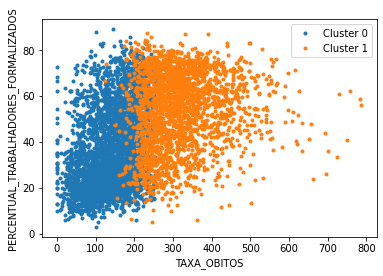

Describing results
===================Cluster 0==================
count    3293.000000
mean      136.149793
std        56.490601
min         0.000000
25%        93.301589
50%       139.535882
75%       179.639851
max       259.099165
Name: TAXA_OBITOS, dtype: float64


===================Cluster 1==================
count    2272.000000
mean      318.414322
std        86.683196
min       123.051682
25%       256.833678
50%       302.052390
75%       361.393284
max       786.672837
Name: TAXA_OBITOS, dtype: float64


Describing clusters
===================Cluster 0==================
count    3293.000000
mean        9.568882
std         2.221249
min         2.810000
25%         8.070000
50%         9.340000
75%        10.780000
max        23.060000
Name: PERCENTUAL_POPULACAO_0_A_5_ANOS, dtype: float64


count    3293.000000
mean       17.203006
std         3.020504
min         4.590000
25%        15.030000
50%        17.190000
75%        19.150000
max        29.360000
Name: PERCENTUAL_POP

In [439]:
show_results(None, centers, u, fpc, df_antecedent, scaler_antecedents, df_analysis)

In [440]:
df_u = pd.DataFrame(u).T
df_u.columns = ['GRUPO_0', 'GRUPO_1']
df_u.describe()
df_u['GRUPO_RESULTADO'] = '?'

In [441]:
df_u.loc[df_u.GRUPO_0 >= 0.6, 'GRUPO_RESULTADO'] = '0'
df_u.loc[df_u.GRUPO_1 >= 0.6, 'GRUPO_RESULTADO'] = '1'
df_antecedent['GRUPO_RESULTADO'] = df_u.GRUPO_RESULTADO
df_base_antecedent['GRUPO_RESULTADO'] = df_u.GRUPO_RESULTADO

In [442]:
df_base_antecedent.groupby(['HIERARQUIA_URBANA', 'GRUPO_RESULTADO']).count()[['MUNICIPIO']]

MUNICIPIO
HIERARQUIA_URBANA         GRUPO_RESULTADO           
Capital Regional A        0                       31
                          1                       14
                          ?                        3
Capital Regional B        0                       37
                          1                       49
                          ?                        6
Capital Regional C        0                       68
                          1                       78
                          ?                       22
Centro Local              0                     2324
                          1                     1411
                          ?                      371
Centro Sub-Regional A     0                       72
                          1                       71
                          ?                        8
Centro Sub-Regional B     0                      173
                          1                      137
                          ?                       35
Centro de Zona A          0                       81
                          1                       75
                          ?                       17
Centro de Zona B          0                      151
                          1                       86
                          ?                       27
Grande Metrópole Nacional 0                        7
                          1                       26
                          ?                        4
Metrópole                 0                       69
                          1                       60
                          ?                       18
Metrópole Nacional        0                       13
                          1                       14
                          ?                        2

In [443]:
df_base_geral_group = df_base_antecedent.groupby(['GRUPO_RESULTADO']).mean()[[
    'PERCENTUAL_POPULACAO_0_A_5_ANOS',
      'PERCENTUAL_POPULACAO_6_A_14_ANOS',
      'PERCENTUAL_POPULACAO_15_A_24_ANOS',
      'PERCENTUAL_POPULACAO_25_A_39_ANOS',
      'PERCENTUAL_POPULACAO_40_A_59_ANOS',
      'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS',
      'TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
      'DENSIDADE',
      'RAZAO_POPULCAO_DOMICILIOS_ESTIMADA',
      'PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO',
      'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_BANHEIRO_AGUA',
      'PERCENTUAL_POPULACAO_URBANA',
      'IDHM_RENDA',
      'RAZAO_20_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES',
      'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA',
      'PERCENTUAL_OCUPADOS_AGROPECUARIA',
      'PERCENTUAL_OCUPADOS_COMERCIO',
     'PERCENTUAL_OCUPADOS_SERVICO',
     'PERCENTUAL_OCUPADOS_INDUSTRIA',
     'PERCENTUAL_TRABALHADORES_FORMALIZADOS',
      'PERCENTUAL_OCUPADOS_SEM_RENDA',
      'TAXA_ATIVIDADE',
     'PERCENTUAL_INTERNACAOES_DOENCAS_SANEAMENTO_INADEQUADO',
      'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE',
      'PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE',
      'PERCENTUAL_VOTOS_BOLSONARO']]

In [444]:
df_base_geral_group

,PERCENTUAL_POPULACAO_0_A_5_ANOS,PERCENTUAL_POPULACAO_6_A_14_ANOS,PERCENTUAL_POPULACAO_15_A_24_ANOS,PERCENTUAL_POPULACAO_25_A_39_ANOS,PERCENTUAL_POPULACAO_40_A_59_ANOS,PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA,DENSIDADE,RAZAO_POPULCAO_DOMICILIOS_ESTIMADA,PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO,...,PERCENTUAL_OCUPADOS_COMERCIO,PERCENTUAL_OCUPADOS_SERVICO,PERCENTUAL_OCUPADOS_INDUSTRIA,PERCENTUAL_TRABALHADORES_FORMALIZADOS,PERCENTUAL_OCUPADOS_SEM_RENDA,TAXA_ATIVIDADE,PERCENTUAL_INTERNACAOES_DOENCAS_SANEAMENTO_INADEQUADO,PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE,PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE,PERCENTUAL_VOTOS_BOLSONARO
GRUPO_RESULTADO,,,,,,,,,,,,,,,,,,,,,
0,9.511015,17.014739,18.312935,22.231497,21.162274,11.767713,48.743143,92.317482,3.444209,0.993237,...,10.388850,31.879636,7.979091,37.885578,16.308926,52.943047,3.837323,6.407928,93.250750,35.149607
1,8.390544,15.254151,17.262771,22.685972,23.901781,12.505062,69.712012,136.712014,3.180329,1.112642,...,10.893286,33.275364,11.999327,51.482712,9.229396,58.715952,2.269223,11.239644,85.885423,52.224871
?,8.792339,15.980643,17.628070,22.344795,22.888402,12.365185,61.184392,89.713606,3.343857,1.074843,...,10.422164,32.584932,9.844211,45.111248,12.966628,56.556277,2.692008,8.324172,89.623372,45.878363


In [445]:
df_base_antecedent[(df_base_antecedent.HIERARQUIA_URBANA == 'Metrópole Nacional') & (df_base_antecedent.GRUPO_RESULTADO == '?')]

,MUNICIPIO,CODIGO_MUNICIPIO_6,SIGLA_ESTADO,CODIGO_ESTADO,REGIAO,REGIAO_SAUDE,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,CASOS,OBITOS,...,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA,RAZAO_POPULCAO_DOMICILIOS_ESTIMADA,GRUPO,GRUPO_RESULTADO
3203,Itaboraí,330190,RJ,33,Sudeste,METROPOLITANA II,33006.0,1.0,14155.0,799,...,144.357953,37.282949,81.658409,29.789255,252.517484,143.599096,36.655519,2.78763,0,?
3224,Nova Iguaçu,330350,RJ,33,Sudeste,METROPOLITANA I,33005.0,1.0,22546.0,1899,...,144.357953,37.282949,81.658409,29.789255,252.517484,143.599096,36.655519,3.13153,0,?


In [447]:
df_base_antecedent.loc[df_base_antecedent.GRUPO == '0', 'GRUPO'] = 'Mais desenvolvido'
df_base_antecedent.loc[df_base_antecedent.GRUPO == '1', 'GRUPO'] = 'Menos desenvolvido'
df_base_antecedent.loc[df_base_antecedent.GRUPO == '?', 'GRUPO'] = 'Desenvolvido intermediário'
df_base_antecedent.loc[df_base_antecedent.GRUPO_RESULTADO == '0', 'GRUPO_RESULTADO'] = 'Impacto menor'
df_base_antecedent.loc[df_base_antecedent.GRUPO_RESULTADO == '1', 'GRUPO_RESULTADO'] = 'Impacto maior'
df_base_antecedent.loc[df_base_antecedent.GRUPO_RESULTADO == '?', 'GRUPO_RESULTADO'] = 'Impacto intermediário'
df_base_antecedent.groupby(['GRUPO', 'GRUPO_RESULTADO']).count()['MUNICIPIO']

GRUPO                       GRUPO_RESULTADO      
Desenvolvido intermediário  Impacto intermediário      73
                            Impacto maior             201
                            Impacto menor             380
Mais desenvolvido           Impacto intermediário     285
                            Impacto maior            1581
                            Impacto menor             853
Menos desenvolvido          Impacto intermediário     155
                            Impacto maior             239
                            Impacto menor            1793
Name: MUNICIPIO, dtype: int64

In [448]:
df_analise = df_base_antecedent.groupby(['GRUPO', 'GRUPO_RESULTADO', 'HIERARQUIA_URBANA']).count()['MUNICIPIO']
df_analise = df_analise.reset_index()
df_analise

,GRUPO,GRUPO_RESULTADO,HIERARQUIA_URBANA,MUNICIPIO
0,Desenvolvido intermediário,Impacto intermediário,Capital Regional B,1
1,Desenvolvido intermediário,Impacto intermediário,Capital Regional C,1
2,Desenvolvido intermediário,Impacto intermediário,Centro Local,55
3,Desenvolvido intermediário,Impacto intermediário,Centro Sub-Regional A,2
4,Desenvolvido intermediário,Impacto intermediário,Centro Sub-Regional B,5
...,...,...,...,...
81,Menos desenvolvido,Impacto menor,Centro Sub-Regional A,27
82,Menos desenvolvido,Impacto menor,Centro Sub-Regional B,76
83,Menos desenvolvido,Impacto menor,Centro de Zona A,42
84,Menos desenvolvido,Impacto menor,Centro de Zona B,95


In [256]:
# ra_25=0.25
# centers_25, u_25, u0, d, jm, p, fpc_25 = cluster.cmeans(
#     df_antecedents.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#     subtractive_clustering_influence_range=ra_25)

In [257]:
# centers_25_c, u_25_c, u0, d, jm, p, fpc_25_c = cluster.cmeans(
#     df_concequents.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#     subtractive_clustering_influence_range=ra_25)

In [258]:
# show_results(ra_25, centers_25, u_25, fpc_25, df_antecedents_not_normalized, scaler_antecedents)
# show_results(ra_25, centers_25_c, u_25_c, fpc_25_c, df_consequents_not_normalized, scaler_concequents)

In [259]:
# ra_19=0.19
# centers_19, u_19, u0, d, jm, p, fpc_19 = cluster.cmeans(
#     df_antecedents.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#     subtractive_clustering_influence_range=ra_19)

In [260]:
# centers_19_c, u_19_c, u0, d, jm, p, fpc_19_c = cluster.cmeans(
#     df_concequents.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#     subtractive_clustering_influence_range=ra_19)

In [261]:
# show_results(ra_19, centers_19, u_19, fpc_19, df_antecedents_not_normalized, scaler_antecedents)
# show_results(ra_19, centers_19_c, u_19_c, fpc_19_c, df_consequents_not_normalized, scaler_concequents)
#